# Multi-Agent RAG System
* ÏãùÌíàÍ∞úÎ∞úÌåÄ ÌéòÎ•¥ÏÜåÎÇò Í∏∞Î∞ò
* Rag WorkFlow : https://flying-spinach-b72.notion.site/6-30-222853f7819580c0a092e22438a2dd5a?source=copy_link
* Mock DB(mock_databases.py) ÏÑ∏ÏÖò Ï†ÄÏû•ÏÜåÏóê ÏóÖÎ°úÎìú ÌïÑÏöî



# ÏãúÏä§ÌÖú Ï¥àÍ∏∞Ìôî Î∞è Íµ¨ÏÑ± ÏöîÏÜå Ï†ïÏùò

## Í∏∞Î≥∏ ÎùºÏù¥Î∏åÎü¨Î¶¨ Import & API Key ÏÑ§Ï†ï

In [2]:
!pip install langgraph langchain langchain-openai pydantic
!pip install langchain-community python-dotenv
!pip install graphviz

In [3]:
import os
import time
import json
import asyncio
import random
from datetime import datetime
from typing import Dict, List, Any, Optional, Literal, AsyncGenerator
from enum import Enum
from pydantic import BaseModel, Field
from google.colab import userdata

# API ÌÇ§ ÏÑ§Ï†ï
try:
    os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
    print(">> OPENAI_API_KEY ÏÑ§Ï†ï ÏôÑÎ£å")
except:
    print(">> Colab SecretsÏóê 'OPENAI_API_KEY' Ï∂îÍ∞Ä ÌïÑÏöî")

>> OPENAI_API_KEY ÏÑ§Ï†ï ÏôÑÎ£å


## Í∏∞Î≥∏ Îç∞Ïù¥ÌÑ∞ Î™®Îç∏ Ï†ïÏùò

In [4]:
class AgentType(str, Enum):
    """Agent Type Ï†ïÏùò"""
    PLANNING = "planning" # ÏøºÎ¶¨ Î∂ÑÏÑù Î∞è ÏûëÏóÖ ÌîåÎûú ÏàòÎ¶Ω
    RETRIEVER_X = "retriever_x" # Graph DB Ï§ëÏã¨Ïùò Í¥ÄÍ≥Ñ ÌÉêÏÉâ Îã¥Îãπ Í≤ÄÏÉâ ÏóêÏù¥Ï†ÑÌä∏
    RETRIEVER_Y = "retriever_y" # Multi-source Í≤ÄÏÉâ Îã¥Îãπ (Vector, RDB, Web Îì±)
    CRITIC_1 = "critic_1" # Ï†ïÎ≥¥Îüâ Ï∂©Î∂ÑÏÑ± ÌèâÍ∞Ä Îã¥Îãπ
    CRITIC_2 = "critic_2" # Ïª®ÌÖçÏä§Ìä∏ ÌíàÏßà Î∞è Ïã†Î¢∞ÎèÑ ÌèâÍ∞Ä Îã¥Îãπ
    CONTEXT_INTEGRATOR = "context_integrator" # Î™®Îì† Í≤ÄÏÉâ Í≤∞Í≥ºÎ•º ÌÜµÌï©Ìï¥ Íµ¨Ï°∞ÌôîÎêú Î¨∏ÏÑú ÏÉùÏÑ±
    REPORT_GENERATOR = "report_generator" # ÏµúÏ¢Ö Î≥¥Í≥†ÏÑú Î∞è ÏÇ¨Ïö©Ïûê ÏùëÎãµ Î¨∏ÏÑú ÏÉùÏÑ±
    SIMPLE_ANSWERER = "simple_answerer" # Îã®Ïàú ÏøºÎ¶¨Ïóê ÎåÄÌï¥ Îπ†Î•∏ ÏùëÎãµ ÏÉùÏÑ±


class MessageType(str, Enum):
    """Agent Í∞Ñ Ï£ºÍ≥† Î∞õÎäî Î©îÏÑ∏ÏßÄ ÌÉÄÏûÖ Ï†ïÏùò"""
    REAL_TIME_HINT = "real_time_hint"
    SEARCH_REQUEST = "search_request"
    INTERESTING_FINDING = "interesting_finding"
    FEEDBACK = "feedback"
    RESULT = "result"
    # ÏΩîÎìú ÏÉÅÏóêÏÑú Ìï¥Îãπ Î©îÏãúÏßÄÍ∞Ä Ïñ¥Îñ§ Ï¢ÖÎ•òÏùò Î©îÏãúÏßÄ TypeÏù∏ÏßÄÎ•º ÎÇòÌÉÄÎÉÑ

class DatabaseType(str, Enum):
    """Îç∞Ïù¥ÌÑ∞Î≤†Ïù¥Ïä§ ÌÉÄÏûÖ"""
    GRAPH_DB = "graph_db"
    VECTOR_DB = "vector_db"
    RDB = "rdb"
    API = "api"
    WEB = "web"


class AgentMessage(BaseModel):
    """Agent Í∞Ñ Ïã§ÏãúÍ∞Ñ Î©îÏãúÏßÄ"""
    from_agent: AgentType
    to_agent: AgentType
    message_type: MessageType
    content: str # Ï£ºÏöî ÌÖçÏä§Ìä∏ ÎÇ¥Ïö©
    data: Dict[str, Any] = Field(default_factory=dict) # Î∂ÄÍ∞Ä Îç∞Ïù¥ÌÑ∞(ÌûåÌä∏, ÌÇ§ÏõåÎìú, Î©îÌÉÄ Ï†ïÎ≥¥, ...)
    timestamp: str = Field(default_factory=lambda: datetime.now().isoformat())
    priority: int = Field(default=1, description="1=highest, 5=lowest")
    # ÏóêÏù¥Ï†ÑÌä∏ Í∞Ñ Îç∞Ïù¥ÌÑ∞Î•º Ï†ÑÎã¨ÌïòÎäî Íµ¨Ï°∞ Í∑∏ ÏûêÏ≤¥


class SearchResult(BaseModel):
    """Í≤ÄÏÉâ Í≤∞Í≥º ÌëúÏ§Ä ÌòïÌÉú"""
    source: str # Îç∞Ïù¥ÌÑ∞ ÏÜåÏä§ Ïù¥Î¶Ñ(graph_db, vector_db, ...)
    content: str # Í≤ÄÏÉâ Í≤∞Í≥º ÎÇ¥Ïö©
    relevance_score: float = Field(ge=0.0, le=1.0) # Í≤ÄÏÉâ Í≤∞Í≥ºÏùò Í¥ÄÎ†®ÎèÑ
    metadata: Dict[str, Any] = Field(default_factory=dict)
    timestamp: str = Field(default_factory=lambda: datetime.now().isoformat())
    search_query: str = "" # Í≤ÄÏÉâÌïú ÏøºÎ¶¨ Í∑∏ ÏûêÏ≤¥


class QueryPlan(BaseModel):
    """Planning AgentÍ∞Ä ÏÉùÏÑ±ÌïòÎäî ÏøºÎ¶¨ Í≥ÑÌöç"""
    original_query: str
    sub_queries: List[str] = Field(default_factory=list)
    required_databases: List[DatabaseType] = Field(default_factory=list)
    priority: int = Field(default=1, ge=1, le=5)
    reasoning: str = "" # ÌòÑÏû¨ Í≥ÑÌöç ÏàòÎ¶Ω Í∏∞Ï§Ä
    estimated_complexity: str = Field(default="medium")  # low, medium, high


class CriticResult(BaseModel):
    """Critic AgentÏùò ÌèâÍ∞Ä Í≤∞Í≥º"""
    status: Literal["sufficient", "insufficient"]
    suggestion: str # Î∂ÄÏ°±Ìïú Î∂ÄÎ∂ÑÏóê ÎåÄÌïú Î≥¥ÏôÑ Ï†úÏïà
    confidence: float # Ïã†Î¢∞ÎèÑ Ï†êÏàò
    reasoning: str # Ï∂©Î∂Ñ/Î∂àÏ∂©Î∂ÑÏóê ÎåÄÌïú ÎÖºÎ¶¨Ï†Å Ïù¥Ïú†

## Ïã§ÏãúÍ∞Ñ ÌîºÎìúÎ∞± Ï±ÑÎÑê

In [5]:
class RealTimeFeedbackChannel:
    """
    Agent Í∞Ñ Ïã§ÏãúÍ∞Ñ ÌîºÎìúÎ∞± Ï±ÑÎÑê
    Î©îÎ™®Î¶¨ Í∏∞Î∞ò ÌÅê(asyncio.Queue) ÏÇ¨Ïö©
    Î©îÏãúÏßÄÎ•º ÎπÑÎèôÍ∏∞Ï†ÅÏúºÎ°ú Ï£ºÍ≥† Î∞õÏùå
    """

    def __init__(self):
        self.x_to_y_queue = asyncio.Queue() # X -> Y
        self.y_to_x_queue = asyncio.Queue() # Y -> X
        self.active = asyncio.Event() # Ï±ÑÎÑê Active Ïó¨Î∂Ä
        self.active.set() # Ï¥àÍ∏∞ Actve Îê®
        self.message_history: List[AgentMessage] = [] # Î™®Îì† ÏÜ°ÏàòÏã† Î©îÏãúÏßÄÏùò Î°úÍ∑∏ Í∏∞Î°ù

    async def send_x_to_y(self, message: AgentMessage):
        """X ‚Üí Y Î©îÏãúÏßÄ Ï†ÑÏÜ°"""
        self.message_history.append(message)
        await self.x_to_y_queue.put(message)

    async def send_y_to_x(self, message: AgentMessage):
        """Y ‚Üí X Î©îÏãúÏßÄ Ï†ÑÏÜ°"""
        self.message_history.append(message)
        await self.y_to_x_queue.put(message)

    async def get_messages_for_y(self) -> AsyncGenerator[AgentMessage, None]: # Ïã§ÏãúÍ∞Ñ Ïä§Ìä∏Î¶¨Î∞ç ÏßÄÏõê
        """YÍ∞Ä XÎ°úÎ∂ÄÌÑ∞ Î∞õÏùÑ Î©îÏãúÏßÄÎì§ Ïä§Ìä∏Î¶¨Î∞ç"""
        while self.active.is_set():
            try:
                message = await asyncio.wait_for(self.x_to_y_queue.get(), timeout=0.5)
                yield message
            except asyncio.TimeoutError:
                continue

    async def get_messages_for_x(self) -> AsyncGenerator[AgentMessage, None]:
        """XÍ∞Ä YÎ°úÎ∂ÄÌÑ∞ Î∞õÏùÑ Î©îÏãúÏßÄÎì§ Ïä§Ìä∏Î¶¨Î∞ç"""
        while self.active.is_set():
            try:
                message = await asyncio.wait_for(self.y_to_x_queue.get(), timeout=0.5)
                yield message
            except asyncio.TimeoutError:
                continue

    def stop(self):
        """Ï±ÑÎÑê Ï¢ÖÎ£å"""
        self.active.clear()

    def get_message_count(self) -> Dict[str, int]:
        """Î©îÏãúÏßÄ ÌÜµÍ≥Ñ"""
        x_to_y = sum(1 for msg in self.message_history if msg.from_agent == AgentType.RETRIEVER_X)
        y_to_x = sum(1 for msg in self.message_history if msg.from_agent == AgentType.RETRIEVER_Y)
        return {"x_to_y": x_to_y, "y_to_x": y_to_x, "total": len(self.message_history)}


## Í∞úÎ≥Ñ Agent Memory ÏÑ§Ï†ï

In [6]:
class AgentMemory(BaseModel):
    """Í∞Å AgentÏùò Í∞úÎ≥Ñ Î©îÎ™®Î¶¨"""
    agent_type: AgentType
    internal_state: Dict[str, Any] = Field(default_factory=dict) # ÏûÑÏãú Î≥ÄÏàòÎÇò ÏÉÅÌÉú Ï†ÄÏû•Ïö©
    message_history: List[AgentMessage] = Field(default_factory=list)
    findings: List[str] = Field(default_factory=list) # ÏóêÏù¥Ï†ÑÌä∏Í∞Ä Í≥ºÏ†ï Ï§ë Î∞úÍ≤¨Ìïú Ï£ºÏöî Ïù∏ÏÇ¨Ïù¥Ìä∏/Ìå®ÌÑ¥/ÏùòÎØ∏ ÏûàÎäî Î°úÍ∑∏
    performance_metrics: Dict[str, float] = Field(default_factory=dict) # ÏÑ±Îä• ÏßÄÌëú (Í≤ÄÏÉâ ÏÜçÎèÑ, Ï§ëÎ≥µ Ï†úÍ±∞ ÎπÑÏú®, ÏùëÎãµ ÏÑ±Í≥µÎ•†, ...)

    def add_finding(self, finding: str):
        """ÏÉàÎ°úÏö¥ Î∞úÍ≤¨ Ï∂îÍ∞Ä"""
        self.findings.append(f"[{datetime.now().strftime('%H:%M:%S')}] {finding}")

    def update_metric(self, metric_name: str, value: float):
        """ÏÑ±Îä• ÏßÄÌëú ÏóÖÎç∞Ïù¥Ìä∏"""
        self.performance_metrics[metric_name] = value


## Î©îÏù∏ State Ï†ïÏùò


In [7]:
class StreamingAgentState(BaseModel):
    """Ïã§ÏãúÍ∞Ñ Ïä§Ìä∏Î¶¨Î∞ç Multi-Agent ÏÉÅÌÉú"""

    # Î©îÏù∏ Ï†ïÎ≥¥
    original_query: str
    current_iteration: int = Field(default=0, ge=0) # ÌòÑÏû¨ Î∞òÎ≥µ ÌöüÏàò
    max_iterations: int = Field(default=2, ge=1, le=5) # ÏµúÎåÄ Î∞òÎ≥µ ÌöüÏàò
    start_time: str = Field(default_factory=lambda: datetime.now().isoformat()) # ÏÑ∏ÏÖò ÏãúÏûë ÏãúÍ∞Ñ(ÏßàÏùò Ï≤òÎ¶¨ ÏÜåÏöî ÏãúÍ∞Ñ)

    # Planning Í≤∞Í≥º
    query_plan: Optional[QueryPlan] = None
    planning_complete: bool = False

    # Ïã§ÏãúÍ∞Ñ Í≤ÄÏÉâ Í≤∞Í≥º Ïä§Ìä∏Î¶º
    graph_results_stream: List[SearchResult] = Field(default_factory=list)
    multi_source_results_stream: List[SearchResult] = Field(default_factory=list)

    # Retriever ÌôúÏÑ± ÏÉÅÌÉú
    x_active: bool = False
    y_active: bool = False
    search_complete: bool = False

    # Agent Î©îÎ™®Î¶¨
    agent_memories: Dict[str, AgentMemory] = Field(default_factory=dict)

    # Critic ÌèâÍ∞Ä Í≤∞Í≥º
    critic1_result: Optional[CriticResult] = None
    critic2_result: Optional[CriticResult] = None
    info_sufficient: bool = False
    context_sufficient: bool = False

    # ÌÜµÌï© Î∞è ÏµúÏ¢Ö ÏÉùÏÑ± Í≤∞Í≥º
    integrated_context: str = ""
    final_answer: str = ""

    # ÏÑ±Îä• Î∞è ÌÜµÍ≥Ñ
    total_search_results: int = 0
    total_messages_exchanged: int = 0
    processing_time_seconds: float = 0.0

    class Config:
        arbitrary_types_allowed = True # ÎπÑÏ†ïÌòï Í∞ùÏ≤¥ ÌóàÏö© ÏÑ§Ï†ï

    def __init__(self, **data):
        super().__init__(**data)
        # Agent Î©îÎ™®Î¶¨ Ï¥àÍ∏∞Ìôî(Î™®Îì† AgentÏóê ÎåÄÌï¥ AgentMemoryÎ•º ÏÉùÏÑ±)
        for agent_type in AgentType:
            agent_key = agent_type.value
            if agent_key not in self.agent_memories:
                self.agent_memories[agent_key] = AgentMemory(agent_type=agent_type)

    def get_agent_memory(self, agent_type: AgentType) -> AgentMemory:
        """ÌäπÏ†ï Agent Î©îÎ™®Î¶¨ Î∞òÌôò"""
        return self.agent_memories[agent_type.value]

    def add_graph_result(self, result: SearchResult):
        """Graph Í≤ÄÏÉâ Í≤∞Í≥º Ï∂îÍ∞Ä"""
        self.graph_results_stream.append(result)
        self.total_search_results += 1

    def add_multi_source_result(self, result: SearchResult):
        """Multi-source Í≤ÄÏÉâ Í≤∞Í≥º Ï∂îÍ∞Ä"""
        self.multi_source_results_stream.append(result)
        self.total_search_results += 1

    def get_all_results(self) -> List[SearchResult]: # ÌòÑÏû¨Îäî ÏÇ¨Ïö© ÏïàÌï®(Context integratorÏóêÏÑú ÏÇ¨Ïö© Í∞ÄÎä•)
        """Î™®Îì† Í≤ÄÏÉâ Í≤∞Í≥º Î∞òÌôò"""
        return self.graph_results_stream + self.multi_source_results_stream

    def get_latest_results(self, limit: int = 10) -> List[SearchResult]: # ÌòÑÏû¨Îäî ÏÇ¨Ïö© ÏïàÌï®
        """ÏµúÏã† Í≤ÄÏÉâ Í≤∞Í≥º Î∞òÌôò"""
        all_results = self.get_all_results()
        sorted_results = sorted(all_results, key=lambda x: x.timestamp, reverse=True)
        return sorted_results[:limit]

    def get_performance_summary(self) -> Dict[str, Any]: # ÌèâÍ∞Ä ÌïÑÏöîÏãú ÏÇ¨Ïö©
        """ÏÑ±Îä• ÏöîÏïΩ Î∞òÌôò"""
        return {
            "total_iterations": self.current_iteration,
            "total_search_results": self.total_search_results,
            "graph_results": len(self.graph_results_stream),
            "multi_source_results": len(self.multi_source_results_stream),
            "messages_exchanged": self.total_messages_exchanged,
            "processing_time": self.processing_time_seconds,
            "info_sufficient": self.info_sufficient,
            "context_sufficient": self.context_sufficient,
            "planning_complete": self.planning_complete
        }

    def reset_for_new_iteration(self): # CriticÏóêÏÑú Ï†ïÎ≥¥ Î∂àÏ∂©Î∂ÑÏúºÎ°ú Ïù∏Ìï¥ ÏÉàÎ°úÏö¥ Î∞òÎ≥µÏù¥ ÏßÑÌñâÎê† Îïå Ïù¥Ï†Ñ Ï†ïÎ≥¥Î•º Î¶¨ÏÖã
        """ÏÉà Î∞òÎ≥µÏùÑ ÏúÑÌïú ÏÉÅÌÉú Î¶¨ÏÖã"""
        self.x_active = False
        self.y_active = False
        self.search_complete = False
        self.current_iteration += 1

    def should_terminate(self) -> bool:
        """ÏµúÎåÄ Î∞òÎ≥µ ÎèÑÎã¨ Ïó¨Î∂Ä"""
        return self.current_iteration >= self.max_iterations


## Ìó¨Ìçº Ìï®Ïàò

In [8]:
def create_agent_message(
    from_agent: AgentType,
    to_agent: AgentType,
    message_type: MessageType,
    content: str,
    data: Dict[str, Any] = None,
    priority: int = 1
) -> AgentMessage: # RetrieverAgentWithFeedbackÏóêÏÑú ÌîºÎìúÎ∞± Ï†ÑÏÜ°Ïãú ÏÇ¨Ïö©

    """Agent Î©îÏãúÏßÄ ÏÉùÏÑ± Ìó¨Ìçº"""
    return AgentMessage(
        from_agent=from_agent,
        to_agent=to_agent,
        message_type=message_type,
        content=content,
        data=data or {},
        priority=priority
    )

def create_search_result(
    source: str,
    content: str,
    relevance_score: float,
    metadata: Dict[str, Any] = None,
    search_query: str = ""
) -> SearchResult: # DB Í≤ÄÏÉâ Í≤∞Í≥ºÎ•º Search ResultÎ°ú Ìè¨Îß∑ÌåÖ
    """Í≤ÄÏÉâ Í≤∞Í≥º ÏÉùÏÑ± Ìó¨Ìçº"""
    return SearchResult(
        source=source,
        content=content,
        relevance_score=relevance_score,
        metadata=metadata or {},
        search_query=search_query
    )

def create_critic_result(
    status: Literal["sufficient", "insufficient"],
    suggestions: str,
    confidence: float,
    reasoning: str,
    improvement_areas: List[str] = None
) -> CriticResult:
    """Critic Í≤∞Í≥º ÏÉùÏÑ± Ìó¨Ìçº"""
    return CriticResult(
        status=status,
        suggestions=suggestions,
        confidence=confidence,
        reasoning=reasoning,
        improvement_areas=improvement_areas or []
    )

def create_query_plan(
    original_query: str,
    sub_queries: List[str],
    required_databases: List[DatabaseType],
    reasoning: str = "",
    priority: int = 1,
    estimated_complexity: str = "medium"
) -> QueryPlan: # Planning AgentÏùò Plan ÏÉùÏÑ±
    """ÏøºÎ¶¨ Í≥ÑÌöç ÏÉùÏÑ± Ìó¨Ìçº"""
    return QueryPlan(
        original_query=original_query,
        sub_queries=sub_queries,
        required_databases=required_databases,
        reasoning=reasoning,
        priority=priority,
        estimated_complexity=estimated_complexity
    )

# Ï¥àÍ∏∞ ÏÉÅÌÉú ÏÉùÏÑ± Ìï®Ïàò
def create_initial_state(query: str, max_iterations: int = 3) -> tuple[StreamingAgentState, RealTimeFeedbackChannel]:
    """Ï¥àÍ∏∞ ÏÉÅÌÉú + ÌîºÎìúÎ∞± Ï±ÑÎÑê ÏÉùÏÑ±"""
    state = StreamingAgentState(
        original_query=query,
        max_iterations=max_iterations
    ) # Workflow Ïã§Ìñâ Ïãú & Test Ìï®Ïàò Ïã§Ìñâ Ïãú State, Feedback Channel Ï¥àÍ∏∞Ìôî

    # ÌîºÎìúÎ∞± Ï±ÑÎÑê Î≥ÑÎèÑ ÏÉùÏÑ±
    feedback_channel = RealTimeFeedbackChannel()

    print(f"- Ï¥àÍ∏∞ ÏÉÅÌÉú ÏÉùÏÑ± ÏôÑÎ£å")
    print(f"- ÏøºÎ¶¨: {query}")
    print(f"- ÏµúÎåÄ Î∞òÎ≥µ: {max_iterations}")
    print(f"- ÌîºÎìúÎ∞± Ï±ÑÎÑê: ÌôúÏÑ±Ìôî")

    return state, feedback_channel

def validate_state(state: StreamingAgentState) -> bool: # StateÍ∞Ä Ï†ïÏÉÅÏ†ÅÏúºÎ°ú ÏÉùÏÑ±ÎêêÎäîÏßÄ Ïó¨Î∂ÄÎ•º Í≤ÄÏ¶ù
    """ÏÉÅÌÉú Ïú†Ìö®ÏÑ± Í≤ÄÏ¶ù"""
    try:
        # Í∏∞Î≥∏ ÌïÑÎìú Í≤ÄÏ¶ù
        assert state.original_query, "ÏõêÎ≥∏ ÏøºÎ¶¨Í∞Ä ÎπÑÏñ¥ÏûàÏùå" # Í∞íÏù¥ ÏóÜÏúºÎ©¥ Ïò§Î•ò Î©îÏãúÏßÄ "ÏõêÎ≥∏ ÏøºÎ¶¨Í∞Ä ÎπÑÏñ¥ÏûàÏùå" Î∞òÌôò
        assert 0 <= state.current_iteration <= state.max_iterations, "Î∞òÎ≥µ ÌöüÏàò Î≤îÏúÑ Ïò§Î•ò"

        # Agent Î©îÎ™®Î¶¨ Í≤ÄÏ¶ù
        assert len(state.agent_memories) == len(AgentType), "Agent Î©îÎ™®Î¶¨ Í∞úÏàò Î∂àÏùºÏπò"

        print(f"- ÏÉÅÌÉú Í≤ÄÏ¶ù ÌÜµÍ≥º")
        return True

    except AssertionError as e:
        print(f"\n>> ÏÉÅÌÉú Í≤ÄÏ¶ù Ïã§Ìå®: {e}")
        return False
    except Exception as e:
        print(f"\n>> ÏÉÅÌÉú Í≤ÄÏ¶ù Ïò§Î•ò: {e}")
        return False


# Pydantic Î™®Îç∏ ÌÖåÏä§Ìä∏Ïö© ÏÉòÌîå Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ±
def create_sample_data():
    """ÌÖåÏä§Ìä∏Ïö© ÏÉòÌîå Îç∞Ïù¥ÌÑ∞"""

    # ÏÉòÌîå ÏøºÎ¶¨ Í≥ÑÌöç
    sample_plan = create_query_plan(
        original_query="ÏåÄ Í∞ÄÍ≤© ÏÉÅÏäπ ÏõêÏù∏ Î∂ÑÏÑù",
        sub_queries=[
            "ÏåÄ Í∞ÄÍ≤© ÏÉÅÏäπ ÌòÑÌô©ÏùÄ?",
            "Ï£ºÏöî ÏõêÏù∏ ÏöîÏÜåÎì§ÏùÄ?",
            "Ìñ•ÌõÑ Ï†ÑÎßùÏùÄ?"
        ],
        required_databases=[DatabaseType.GRAPH_DB, DatabaseType.RDB, DatabaseType.WEB],
        reasoning="Îã§Í∞ÅÎèÑ Î∂ÑÏÑùÏùÑ ÏúÑÌï¥ Í∑∏ÎûòÌîÑ, Ï†ïÌòïÎç∞Ïù¥ÌÑ∞, Ïõπ Ï†ïÎ≥¥ ÌïÑÏöî"
    )

    # ÏÉòÌîå Í≤ÄÏÉâ Í≤∞Í≥º
    sample_result = create_search_result(
        source="graph_db",
        content="ÏåÄ-Í∞ÄÍ≤©ÏÉÅÏäπ-Í∏∞ÌõÑÏöîÏù∏ Í¥ÄÍ≥Ñ Î∞úÍ≤¨",
        relevance_score=0.85,
        metadata={"entity": "ÏåÄ", "relations": ["Í∞ÄÍ≤©ÏÉÅÏäπ", "Í∏∞ÌõÑÏöîÏù∏"]},
        search_query="ÏåÄ Í∞ÄÍ≤© Í¥ÄÍ≥Ñ"
    )

    # ÏÉòÌîå Î©îÏãúÏßÄ
    sample_message = create_agent_message(
        from_agent=AgentType.RETRIEVER_X,
        to_agent=AgentType.RETRIEVER_Y,
        message_type=MessageType.REAL_TIME_HINT,
        content="ÏåÄ-Í∏∞ÌõÑÏöîÏù∏ Í¥ÄÍ≥Ñ Î∞úÍ≤¨, Í¥ÄÎ†® ÏµúÏã† Îç∞Ïù¥ÌÑ∞ Í≤ÄÏÉâ ÌïÑÏöî",
        data={"entities": ["ÏåÄ", "Í∏∞ÌõÑÏöîÏù∏"], "priority": "high"}
    )

    return {
        "query_plan": sample_plan,
        "search_result": sample_result,
        "agent_message": sample_message
    }

## Pydantic Model Test

In [9]:
# Pydantic Model Test : Ï†ÑÏ≤¥ ÏãúÏä§ÌÖúÏóêÏÑú ÏÇ¨Ïö©ÌïòÎäî Pydantic Î™®Îç∏(AgentMessage, SearchResult, QueryPlan, ...) Ï†ïÏÉÅ ÏûëÎèô Í≤ÄÏ¶ù
def test_pydantic_models():
    """Pydantic Î™®Îç∏ ÌÖåÏä§Ìä∏"""
    print(">>> Pydantic Î™®Îç∏ ÌÖåÏä§Ìä∏ ÏãúÏûë...")

    try:
        # ÏÉòÌîå Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ±
        samples = create_sample_data()
        print("- ÏÉòÌîå Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ± ÏÑ±Í≥µ")

        # Ï¥àÍ∏∞ ÏÉÅÌÉú + ÌîºÎìúÎ∞± Ï±ÑÎÑê ÏÉùÏÑ±
        state, feedback_channel = create_initial_state("ÌÖåÏä§Ìä∏ ÏøºÎ¶¨") # original_query == "ÌÖåÏä§Ìä∏ ÏøºÎ¶¨"
        print("- Ï¥àÍ∏∞ ÏÉÅÌÉú + ÌîºÎìúÎ∞± Ï±ÑÎÑê ÏÉùÏÑ± ÏÑ±Í≥µ")

        # ÏÉÅÌÉúÏóê ÏÉòÌîå Îç∞Ïù¥ÌÑ∞ Ï∂îÍ∞Ä
        state.query_plan = samples["query_plan"]
        state.add_graph_result(samples["search_result"])
        print("- ÏÉÅÌÉú ÏóÖÎç∞Ïù¥Ìä∏ ÏÑ±Í≥µ")

        # ÌîºÎìúÎ∞± Ï±ÑÎÑê ÌÖåÏä§Ìä∏
        message_stats = feedback_channel.get_message_count()
        print(f"- ÌîºÎìúÎ∞± Ï±ÑÎÑê ÌÜµÍ≥Ñ: {message_stats}")

        # ÏÉÅÌÉú Í≤ÄÏ¶ù
        validate_state(state)

        # ÏÑ±Îä• ÏöîÏïΩ ÌÖåÏä§Ìä∏
        summary = state.get_performance_summary()
        print(f"- ÏÑ±Îä• ÏöîÏïΩ: {summary}")

        # ÌîºÎìúÎ∞± Ï±ÑÎÑê Ï†ïÎ¶¨
        feedback_channel.stop()
        print("- ÌîºÎìúÎ∞± Ï±ÑÎÑê Ï†ïÎ¶¨ ÏôÑÎ£å")

        print("\n>>> Î™®Îì† Pydantic Î™®Îç∏ ÌÖåÏä§Ìä∏ ÌÜµÍ≥º")
        return True

    except Exception as e:
        print(f"\n>>> ÌÖåÏä§Ìä∏ Ïã§Ìå®: {e}")
        import traceback
        traceback.print_exc()
        return False

# Ïã§Ìñâ
test_result = test_pydantic_models()
print(f"\nÏµúÏ¢Ö Í≤∞Í≥º: {'ÏÑ±Í≥µ' if test_result else 'Ïã§Ìå®'}")

>>> Pydantic Î™®Îç∏ ÌÖåÏä§Ìä∏ ÏãúÏûë...
- ÏÉòÌîå Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ± ÏÑ±Í≥µ
- Ï¥àÍ∏∞ ÏÉÅÌÉú ÏÉùÏÑ± ÏôÑÎ£å
- ÏøºÎ¶¨: ÌÖåÏä§Ìä∏ ÏøºÎ¶¨
- ÏµúÎåÄ Î∞òÎ≥µ: 3
- ÌîºÎìúÎ∞± Ï±ÑÎÑê: ÌôúÏÑ±Ìôî
- Ï¥àÍ∏∞ ÏÉÅÌÉú + ÌîºÎìúÎ∞± Ï±ÑÎÑê ÏÉùÏÑ± ÏÑ±Í≥µ
- ÏÉÅÌÉú ÏóÖÎç∞Ïù¥Ìä∏ ÏÑ±Í≥µ
- ÌîºÎìúÎ∞± Ï±ÑÎÑê ÌÜµÍ≥Ñ: {'x_to_y': 0, 'y_to_x': 0, 'total': 0}
- ÏÉÅÌÉú Í≤ÄÏ¶ù ÌÜµÍ≥º
- ÏÑ±Îä• ÏöîÏïΩ: {'total_iterations': 0, 'total_search_results': 1, 'graph_results': 1, 'multi_source_results': 0, 'messages_exchanged': 0, 'processing_time': 0.0, 'info_sufficient': False, 'context_sufficient': False, 'planning_complete': False}
- ÌîºÎìúÎ∞± Ï±ÑÎÑê Ï†ïÎ¶¨ ÏôÑÎ£å

>>> Î™®Îì† Pydantic Î™®Îç∏ ÌÖåÏä§Ìä∏ ÌÜµÍ≥º

ÏµúÏ¢Ö Í≤∞Í≥º: ÏÑ±Í≥µ


## Feedback Channel Test

In [10]:
# Feedback Channel Test
async def test_feedback_channel():
    """ÌîºÎìúÎ∞± Ï±ÑÎÑê ÎπÑÎèôÍ∏∞ ÌÖåÏä§Ìä∏"""
    print(">>> ÌîºÎìúÎ∞± Ï±ÑÎÑê ÎπÑÎèôÍ∏∞ ÌÖåÏä§Ìä∏ ÏãúÏûë...")

    try:
        # ÏÉÅÌÉú Î∞è Ï±ÑÎÑê ÏÉùÏÑ±
        state, channel = create_initial_state("ÎπÑÎèôÍ∏∞ ÌÖåÏä§Ìä∏")

        # ÌÖåÏä§Ìä∏ Î©îÏãúÏßÄ ÏÉùÏÑ±
        test_message = create_agent_message(
            from_agent=AgentType.RETRIEVER_X,
            to_agent=AgentType.RETRIEVER_Y,
            message_type=MessageType.REAL_TIME_HINT,
            content="ÌÖåÏä§Ìä∏ ÌûåÌä∏ Î©îÏãúÏßÄ"
        )

        # Î©îÏãúÏßÄ Ï†ÑÏÜ°
        await channel.send_x_to_y(test_message)
        print("- Î©îÏãúÏßÄ Ï†ÑÏÜ° ÏÑ±Í≥µ")

        # Î©îÏãúÏßÄ ÏàòÏã† ÌÖåÏä§Ìä∏
        received_count = 0
        async for message in channel.get_messages_for_y():
            print(f"- ÏàòÏã†: {message.content}")
            received_count += 1
            if received_count >= 1:  # ÏùºÎã® 1Í∞úÎßå Î∞õÍ≥† Ï§ëÎã®
                break

        print("- Î©îÏãúÏßÄ ÏàòÏã† ÏÑ±Í≥µ")

        # ÌÜµÍ≥Ñ ÌôïÏù∏
        stats = channel.get_message_count()
        print(f"- Î©îÏãúÏßÄ ÌÜµÍ≥Ñ: {stats}")

        # Ï±ÑÎÑê Ï†ïÎ¶¨
        channel.stop()
        print("- Ï±ÑÎÑê Ï†ïÎ¶¨ ÏôÑÎ£å")

        print(">>> ÌîºÎìúÎ∞± Ï±ÑÎÑê ÎπÑÎèôÍ∏∞ ÌÖåÏä§Ìä∏ ÏôÑÎ£å")
        return True

    except Exception as e:
        print(f"\n>> ÎπÑÎèôÍ∏∞ ÌÖåÏä§Ìä∏ Ïã§Ìå®: {e}")
        return False

# ÎπÑÎèôÍ∏∞ ÌÖåÏä§Ìä∏ Ïã§Ìñâ
async_result = await test_feedback_channel()
print(f"\n>>> ÎπÑÎèôÍ∏∞ ÌÖåÏä§Ìä∏ Í≤∞Í≥º: {'ÏÑ±Í≥µ' if async_result else 'Ïã§Ìå®'}")

>>> ÌîºÎìúÎ∞± Ï±ÑÎÑê ÎπÑÎèôÍ∏∞ ÌÖåÏä§Ìä∏ ÏãúÏûë...
- Ï¥àÍ∏∞ ÏÉÅÌÉú ÏÉùÏÑ± ÏôÑÎ£å
- ÏøºÎ¶¨: ÎπÑÎèôÍ∏∞ ÌÖåÏä§Ìä∏
- ÏµúÎåÄ Î∞òÎ≥µ: 3
- ÌîºÎìúÎ∞± Ï±ÑÎÑê: ÌôúÏÑ±Ìôî
- Î©îÏãúÏßÄ Ï†ÑÏÜ° ÏÑ±Í≥µ
- ÏàòÏã†: ÌÖåÏä§Ìä∏ ÌûåÌä∏ Î©îÏãúÏßÄ
- Î©îÏãúÏßÄ ÏàòÏã† ÏÑ±Í≥µ
- Î©îÏãúÏßÄ ÌÜµÍ≥Ñ: {'x_to_y': 1, 'y_to_x': 0, 'total': 1}
- Ï±ÑÎÑê Ï†ïÎ¶¨ ÏôÑÎ£å
>>> ÌîºÎìúÎ∞± Ï±ÑÎÑê ÎπÑÎèôÍ∏∞ ÌÖåÏä§Ìä∏ ÏôÑÎ£å

>>> ÎπÑÎèôÍ∏∞ ÌÖåÏä§Ìä∏ Í≤∞Í≥º: ÏÑ±Í≥µ


## Mock DB Import & DB Î™®Îç∏ Íµ¨Ï°∞

In [11]:
from mock_databases import MockGraphDB, MockVectorDB, MockRDB, MockWebSearch, create_mock_databases

# Îç∞Ïù¥ÌÑ∞Î≤†Ïù¥Ïä§Îì§ ÏÉùÏÑ±
graph_db, vector_db, rdb, web_search = create_mock_databases()

# ÎîîÎ≤ÑÍπÖ ÏΩîÎìú
# print(">> Mock Database Î°úÎìú ÏôÑÎ£å")
# result = graph_db.search("ÏôÑÎëêÏΩ©")
# print(">> Graph DB Í≤ÄÏÉâ Í≤∞Í≥º")
# print(result)

>> Enhanced Eco-Trend Mock Databases Ï¥àÍ∏∞Ìôî ÏãúÏûë
>> Mock Graph DB Ï¥àÍ∏∞Ìôî ÏãúÏûë
- Enhanced Mock Graph DB Ï¥àÍ∏∞Ìôî ÏôÑÎ£å
>> Enhanced Mock Vector DB Ï¥àÍ∏∞Ìôî ÏãúÏûë
- Enhanced Mock Vector DB Ï¥àÍ∏∞Ìôî ÏôÑÎ£å
>> Enhanced Mock RDB Ï¥àÍ∏∞Ìôî ÏãúÏûë
- Enhanced Mock RDB Ï¥àÍ∏∞Ìôî ÏôÑÎ£å
>> Enhanced Mock Web Search Ï¥àÍ∏∞Ìôî ÏãúÏûë
- Enhanced Mock Web Search Ï¥àÍ∏∞Ìôî ÏôÑÎ£å
======= Enhanced Eco-Trend Mock Databases Ï¥àÍ∏∞Ìôî ÏôÑÎ£å =======
Graph DB: 68Í∞ú ÎÖ∏Îìú (ÏπúÌôòÍ≤Ω Ìä∏Î†åÎìú ÏãùÏû¨Î£å ÎåÄÌè≠ Ï∂îÍ∞Ä)
Vector DB: 13Í∞ú Î¨∏ÏÑú (ÏπúÌôòÍ≤Ω Ïó∞Íµ¨ÏûêÎ£å ÌíçÎ∂Ä)
RDB: 6Í∞ú ÌÖåÏù¥Î∏î (Í∞ÄÍ≤©, ÏòÅÏñë, ÏãúÏû•, ÏÜåÎπÑÏûêÌä∏Î†åÎìú, Ïù∏Ï¶ù, Ïã†Ï†úÌíàÍ∞úÎ∞ú)
Web Search: 11Í∞ú Ïπ¥ÌÖåÍ≥†Î¶¨ (ÏπúÌôòÍ≤Ω Îâ¥Ïä§ ÎåÄÌè≠ ÌôïÏû•)


### MockGraphDB

* Node
```
{
  "id": "ingredient_pea",
  "labels": ["Ingredient"],
  "properties": {
    "name": "ÏôÑÎëêÏΩ©",
    "english_name": "pea",
    "category": "legume",
    "protein_rich": true
  }
}
```

* Relationship
```
{
  "id": "rel_001",
  "type": "HAS_PRICE",
  "start_node": "ingredient_pea",
  "end_node": "price_pea_2024",
  "properties": {
    "market_stability": "stable"
  }
}
```

### MockVectorDB

* Í∏∞Î≥∏ Íµ¨Ï°∞
```
{
  "id": "doc_001",
  "title": "ÏôÑÎëêÏΩ© Îã®Î∞±Ïßà ÏãúÏû• 2025ÎÖÑ 1000Ïñµ ÎèåÌåå Ï†ÑÎßù",
  "content": "Íµ≠ÎÇ¥ ÏôÑÎëêÏΩ© Í∏∞Î∞ò ÏãùÎ¨ºÏÑ± Îã®Î∞±Ïßà ÏãúÏû•Ïù¥ Í∏âÏÑ±Ïû•ÌïòÎ©∞...",
  "metadata": {
    "source": "ÎÜçÎØºÏã†Î¨∏",
    "category": "ÏãúÏû•Î∂ÑÏÑù",
    "reliability": 0.92
  },
  "similarity_score": 0.95
}
```

### MockRDB

* Í∞ÄÍ≤© Ï†ïÎ≥¥
```
{
  "item": "ÏôÑÎëêÏΩ©",
  "date": "2024-03-15",
  "region": "ÏÑúÏö∏",
  "market": "Í∞ÄÎùΩÏãúÏû•",
  "avg_price": 1250,
  "unit": "Ïõê/kg",
  "grade": "ÏÉÅÌíà",
  "supply_volume": 450,
  "price_change": "+3.2%"
}
```

* ÏòÅÏñë Ï†ïÎ≥¥
```
{
  "item": "ÌÄ¥ÎÖ∏ÏïÑ",
  "serving_size": "100g",
  "calories": 368,
  "protein": 14.1,
  "fat": 6.1,
  "carbohydrate": 64.2,
  "fiber": 7.0
}
```

* ÏãúÏû• Îç∞Ïù¥ÌÑ∞
```
{
  "category": "ÏãùÎ¨ºÏÑ± Îã®Î∞±Ïßà",
  "year": 2024,
  "market_size_billion_won": 850,
  "growth_rate": "18.5%",
  "forecast_2025_billion_won": 1008,
  "key_players": ["CJÏ†úÏùºÏ†úÎãπ", "ÎåÄÏÉÅ", "ÏÇºÏñëÏÇ¨"]
}
```

### MockWebSearch

* Îâ¥Ïä§ Í∏∞ÏÇ¨
```
{
  "title": "ÌÄ¥ÎÖ∏ÏïÑ, K-Ìë∏Îìú Ïó¥ÌíçÍ≥º Ìï®Íªò Í∏âÎ∂ÄÏÉÅ",
  "url": "https://www.kfoodnews.com/trend789",
  "snippet": "ÌÄ¥ÎÖ∏ÏïÑÍ∞Ä K-Ìë∏Îìú Ìä∏Î†åÎìúÏôÄ Ìï®Íªò Íµ≠ÎÇ¥ Í±¥Í∞ïÏãùÌíà ÏãúÏû•ÏóêÏÑú Í∏âÎ∂ÄÏÉÅ...",
  "published_date": "2024-03-19",
  "relevance": 0.92
}
```

* Ìä∏ÎûúÎìú Îç∞Ïù¥ÌÑ∞
```
{
  "trend": "ÏãùÎ¨ºÏÑ± ÎåÄÏ≤¥Ïú°",
  "growth_rate": "25%",
  "market_size": "500ÏñµÏõê",
  "key_factors": ["ÌôòÍ≤ΩÏùòÏãù", "Í±¥Í∞ïÍ¥ÄÏã¨", "ÎèôÎ¨ºÎ≥µÏßÄ"]
}
```

### Ï†ÑÏ≤¥ ÏöîÏïΩ ÌÖåÏù¥Î∏î

| DB Ïú†Ìòï      | Îç∞Ïù¥ÌÑ∞ Î™®Îç∏                             | Ï£ºÏöî Ìï®Ïàò   | Î∞òÌôò Í≤∞Í≥º                             |
|---------------|-----------------------------------------|-------------|----------------------------------------|
| **GraphDB**   | Node + Relationship                    | `search()`  | nodes + relationships                 |
| **VectorDB**  | Î¨∏ÏÑú (title, content, metadata, score) | `search()`  | Ïú†ÏÇ¨ Î¨∏ÏÑú Î¶¨Ïä§Ìä∏                      |
| **RDB**       | Í∞ÄÍ≤©, ÏòÅÏñë, ÏãúÏû• ÌÖåÏù¥Î∏î                | `search()`  | prices, nutrition, market_data        |
| **WebSearch** | Í∏∞ÏÇ¨ + Ìä∏Î†åÎìú                          | `search()`  | Í∏∞ÏÇ¨ Î¶¨Ïä§Ìä∏ + ÏãúÏû• Ìä∏Î†åÎìú             |

# Multi-Agent

## Multi-Agent Core Import

In [12]:
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.schema import SystemMessage, HumanMessage
from langgraph.graph import StateGraph, END

## Planning Agent

In [13]:
class PlanningAgent:
    def __init__(self):
        self.chat = ChatOpenAI(model="gpt-3.5-turbo")
        self.agent_type = AgentType.PLANNING

    async def plan(self, state):
        print(">> Planning Start")
        print(f"- ÏõêÎ≥∏ ÏøºÎ¶¨: {state.original_query}")

        complexity_result = await self._judge_complexity(state.original_query)
        print(f"\n>> Î≥µÏû°ÎèÑ ÌåêÎã®: {complexity_result}")

        if complexity_result == "SIMPLE":
            # Îã®Ïàú ÏøºÎ¶¨ - Vector DB ÏÇ¨Ïö© Ïó¨Î∂ÄÎßå Í≤∞Ï†ï
            needs_vector_db = await self._needs_vector_search(state.original_query)

            if needs_vector_db:
                required_dbs = [DatabaseType.VECTOR_DB]
                reasoning = "Îã®Ïàú ÏøºÎ¶¨, Vector DB Í≤ÄÏÉâ ÌïÑÏöî"
            else:
                required_dbs = []
                reasoning = "Îã®Ïàú ÏøºÎ¶¨, DB Í≤ÄÏÉâ Î∂àÌïÑÏöî (Ïù∏ÏÇ¨Îßê/Í∞ÑÎã®Ìïú ÎåÄÌôî)"

            print(f"- Vector DB ÌïÑÏöî: {needs_vector_db}")
            print(f"- ÏÑ†ÌÉùÎêú DB: {required_dbs}")

            state.query_plan = QueryPlan(
                original_query=state.original_query,
                sub_queries=[state.original_query],
                required_databases=required_dbs,
                reasoning=reasoning,
                estimated_complexity="low"
            )
            print("\n>> SIMPLE ÏøºÎ¶¨Î°ú Ï≤òÎ¶¨")

        else:
            # Î≥µÏû° ÏøºÎ¶¨ - Retriever XÎäî Graph DB Í≥†Ï†ï, Retriever YÎäî ÏÑ†ÌÉùÏ†Å
            sub_queries = await self._decompose_query(state.original_query)
            retriever_y_dbs = await self._select_retriever_y_databases(state.original_query)

            # Retriever XÎäî Ìï≠ÏÉÅ Graph DB
            required_dbs = [DatabaseType.GRAPH_DB]

            # Retriever YÍ∞Ä ÏÇ¨Ïö©Ìï† DBÎì§ Ï∂îÍ∞Ä
            required_dbs.extend(retriever_y_dbs)

            print(f"\n>> ÏøºÎ¶¨ Î∂ÑÌï¥ Í≤∞Í≥º: {sub_queries}")
            print(f"- Retriever X: GRAPH_DB (Í≥†Ï†ï)")
            print(f"- Retriever Y: {retriever_y_dbs}")
            print(f"- Ï†ÑÏ≤¥ ÏÑ†ÌÉùÎêú DB: {required_dbs}")

            state.query_plan = QueryPlan(
                original_query=state.original_query,
                sub_queries=sub_queries,
                required_databases=required_dbs,
                reasoning=f"Î≥µÏû° ÏøºÎ¶¨Î°ú ÌåêÎã®, {len(sub_queries)}Í∞úÎ°ú Î∂ÑÌï¥",
                estimated_complexity="high"
            )
            print("\n>> COMPLEX ÏøºÎ¶¨Î°ú Ï≤òÎ¶¨")

        state.planning_complete = True

        memory = state.get_agent_memory(AgentType.PLANNING)
        memory.add_finding(f"Planning ÏôÑÎ£å - {len(state.query_plan.sub_queries)}Í∞ú ÏÑ∏Î∂ÄÏøºÎ¶¨, {len(required_dbs)}Í∞ú DB")

        print("\n>> Planning Agent ÏôÑÎ£å")
        return state

    async def _judge_complexity(self, query):
        """Î≥µÏû°ÎèÑ ÌåêÎã®"""
        prompt = f"""
        Îã§Ïùå ÏßàÎ¨∏Ïù¥ Îã®ÏàúÌïúÏßÄ Î≥µÏû°ÌïúÏßÄ ÌåêÎã®Ìï¥Ï£ºÏÑ∏Ïöî.

        ÏßàÎ¨∏: "{query}"

        SIMPLE: Îã®ÏàúÌïú ÏÇ¨Ïã§ ÏßàÎ¨∏, Ïù∏ÏÇ¨Îßê, Í∞ÑÎã®Ìïú Ï†ïÎ≥¥ ÏöîÏ≤≠
        - Ïòà: "ÏïàÎÖïÌïòÏÑ∏Ïöî", "Í≥†ÎßàÏõå", "ÏåÄÏùò ÏòÅÏñëÏÑ±Î∂ÑÏùÄ?", "ÌÄ¥ÎÖ∏ÏïÑÎûÄ Î¨¥ÏóáÏù∏Í∞ÄÏöî?"

        COMPLEX: Î∂ÑÏÑù, ÎπÑÍµê, ÏòàÏ∏°, Ï¢ÖÌï©, Í¥ÄÍ≥Ñ ÌÉêÏÉâÏù¥ ÌïÑÏöîÌïú ÏßàÎ¨∏
        - Ïòà: "ÏåÄ Í∞ÄÍ≤© ÏÉÅÏäπ ÏõêÏù∏Í≥º Ï†ÑÎßù", "ÌÄ¥ÎÖ∏ÏïÑÏôÄ Í∑ÄÎ¶¨ ÎπÑÍµê Î∂ÑÏÑù", "ÏôÑÎëêÏΩ© ÏãúÏû• ÎèôÌñ•"

        SIMPLE ÎòêÎäî COMPLEX Ï§ë ÌïòÎÇòÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî:
        """

        response = await self.chat.ainvoke(prompt)
        return response.content.strip()

    async def _needs_vector_search(self, query):
        """Îã®Ïàú ÏøºÎ¶¨ÏóêÏÑú Vector DB Í≤ÄÏÉâÏù¥ ÌïÑÏöîÌïúÏßÄ ÌåêÎã®"""
        prompt = f"""
        Îã§Ïùå Îã®ÏàúÌïú ÏßàÎ¨∏Ïù¥ Îç∞Ïù¥ÌÑ∞Î≤†Ïù¥Ïä§ Í≤ÄÏÉâÏù¥ ÌïÑÏöîÌïúÏßÄ ÌåêÎã®Ìï¥Ï£ºÏÑ∏Ïöî.

        ÏßàÎ¨∏: "{query}"

        Í≤ÄÏÉâÏù¥ ÌïÑÏöîÌïú Í≤ΩÏö∞:
        - ÏãùÌíà/ÎÜçÏóÖ Í¥ÄÎ†® Ï†ïÎ≥¥ ÏöîÏ≤≠ (ÏòÅÏñëÏÑ±Î∂Ñ, ÌäπÏßï, Ï†ïÏùò Îì±)
        - Ïòà: "ÏåÄÏùò ÏòÅÏñëÏÑ±Î∂ÑÏùÄ?", "ÌÄ¥ÎÖ∏ÏïÑÎûÄ Î¨¥ÏóáÏù∏Í∞ÄÏöî?", "Ïó∞Ïñ¥Ïùò ÌäπÏßïÏùÄ?"

        Í≤ÄÏÉâÏù¥ Î∂àÌïÑÏöîÌïú Í≤ΩÏö∞:
        - Ïù∏ÏÇ¨Îßê, Í∞êÏÇ¨ Ïù∏ÏÇ¨, ÏùºÎ∞òÏ†ÅÏù∏ ÎåÄÌôî
        - Ïòà: "ÏïàÎÖïÌïòÏÑ∏Ïöî", "Í≥†ÎßàÏõåÏöî", "ÏïàÎÖï", "Î∞òÍ∞ÄÏõåÏöî", "Ïûò ÏßÄÎÇ¥ÏÑ∏Ïöî?"

        Í≤ÄÏÉâÏù¥ ÌïÑÏöîÌïòÎ©¥ YES, Î∂àÌïÑÏöîÌïòÎ©¥ NOÎ°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî:
        """

        response = await self.chat.ainvoke(prompt)
        return response.content.strip().upper() == "YES"

    async def _select_retriever_y_databases(self, query):
        """Î≥µÏû° ÏøºÎ¶¨ÏóêÏÑú Retriever YÍ∞Ä ÏÇ¨Ïö©Ìï† Îç∞Ïù¥ÌÑ∞Î≤†Ïù¥Ïä§ ÏÑ†ÌÉù"""
        prompt = f"""
        Îã§Ïùå Î≥µÏû°Ìïú ÏßàÎ¨∏Ïóê ÎãµÌïòÍ∏∞ ÏúÑÌï¥ Retriever YÍ∞Ä ÏÇ¨Ïö©Ìï† Îç∞Ïù¥ÌÑ∞Î≤†Ïù¥Ïä§Î•º ÏÑ†ÌÉùÌï¥Ï£ºÏÑ∏Ïöî.
        (Ï∞∏Í≥†: Retriever XÎäî Ïù¥ÎØ∏ GRAPH_DBÎ•º ÏÇ¨Ïö©Ìï©ÎãàÎã§)

        ÏßàÎ¨∏: "{query}"

        Retriever YÍ∞Ä ÏÑ†ÌÉùÌï† Ïàò ÏûàÎäî Îç∞Ïù¥ÌÑ∞Î≤†Ïù¥Ïä§:

        1. VECTOR_DB (ÏùòÎØ∏ Í≤ÄÏÉâ DB)
        - Ïó∞Íµ¨Î≥¥Í≥†ÏÑú, ÏãúÏû•Î∂ÑÏÑùÏÑú, Í∏∞Ïà†ÎèôÌñ• Î¨∏ÏÑú
        - Î¨∏ÏÑú: ÏãùÎ¨ºÏÑ±Îã®Î∞±ÏßàÏãúÏû•, ÏñëÏãùÏóÖÌòÑÌô©, Í∏∞Îä•ÏÑ±ÏãùÌíà, AIÎÜçÏóÖÍ∏∞Ïà†, ÎåÄÏ≤¥Ïú°ÎèôÌñ•
        - Ï†ÅÌï©Ìïú ÏßàÎ¨∏: "ÏãúÏû• Ï†ÑÎßù", "Í∏∞Ïà† ÎèôÌñ•", "Ïã¨Ï∏µ Î∂ÑÏÑù", "Ïó∞Íµ¨ ÏûêÎ£å"

        2. RDB (Í¥ÄÍ≥ÑÌòï Ï†ïÌòï DB)
        - ÌÖåÏù¥Î∏î: ÎÜçÏÇ∞Î¨ºÍ∞ÄÍ≤©, ÏòÅÏñëÏÑ±Î∂Ñ, ÏãúÏû•Îç∞Ïù¥ÌÑ∞, ÏßÄÏó≠ÏÉùÏÇ∞Îüâ, ÏÜåÎπÑÏûêÌä∏Î†åÎìú
        - Ï†ÅÌï©Ìïú ÏßàÎ¨∏: "Íµ¨Ï≤¥Ï†Å Í∞ÄÍ≤©", "ÏòÅÏñë ÏÑ±Î∂Ñ", "ÏÉùÏÇ∞Îüâ ÌÜµÍ≥Ñ", "Ï†ïÌôïÌïú ÏàòÏπò"

        3. WEB (Ïã§ÏãúÍ∞Ñ Ïõπ Í≤ÄÏÉâ)
        - ÏµúÏã† Îâ¥Ïä§Í∏∞ÏÇ¨, ÏãúÏû•ÎèôÌñ•, Ï†ïÏ±ÖÎ≥ÄÌôî, Ïã§ÏãúÍ∞Ñ Ï†ïÎ≥¥
        - Ï†ÅÌï©Ìïú ÏßàÎ¨∏: "ÏµúÏã† ÎèôÌñ•", "Îâ¥Ïä§", "Ïã§ÏãúÍ∞Ñ Ï†ïÎ≥¥", "Ï†ïÏ±Ö Î≥ÄÌôî"

        Ï£ºÏùòÏÇ¨Ìï≠:
        - ÌïÑÏöîÌïòÏßÄ ÏïäÏùÄ Îç∞Ïù¥ÌÑ∞Î≤†Ïù¥Ïä§Îäî ÏÑ†ÌÉùÌïòÏßÄ ÎßàÏÑ∏Ïöî
        - Îç∞Ïù¥ÌÑ∞Î≤†Ïù¥Ïä§Í∞Ä Ï†ÑÌòÄ ÌïÑÏöî ÏóÜÎã§Î©¥ NONEÏùÑ ÎãµÎ≥ÄÌïòÏÑ∏Ïöî

        Îã§Ïùå Ï§ëÏóêÏÑú ÌïÑÏöîÌïú Í≤ÉÎßå ÏÑ†ÌÉùÌï¥Ï£ºÏÑ∏Ïöî (ÌïÑÏöî ÏóÜÏúºÎ©¥ NONE):
        - VECTOR_DB
        - RDB
        - WEB
        - NONE

        ÏâºÌëúÎ°ú Íµ¨Î∂ÑÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî (Ïòà: VECTOR_DB, RDB ÎòêÎäî NONE):
        """

        response = await self.chat.ainvoke(prompt)

        if "NONE" in response.content.upper():
            return []

        db_names = [db.strip() for db in response.content.split(',')]

        # Î¨∏ÏûêÏó¥ÏùÑ DatabaseType enumÏúºÎ°ú Î≥ÄÌôò
        database_mapping = {
            "VECTOR_DB": DatabaseType.VECTOR_DB,
            "RDB": DatabaseType.RDB,
            "WEB": DatabaseType.WEB
        }

        selected_dbs = []
        for db_name in db_names:
            if db_name in database_mapping:
                selected_dbs.append(database_mapping[db_name])

        return selected_dbs

    async def _decompose_query(self, query):
        """Î≥µÏû°Ìïú ÏøºÎ¶¨Î•º ÏÑ∏Î∂Ä ÏøºÎ¶¨Î°ú Î∂ÑÌï¥"""
        prompt = f"""
        Îã§Ïùå Î≥µÏû°Ìïú ÏßàÎ¨∏ÏùÑ 3-4Í∞úÏùò ÎèÖÎ¶ΩÏ†ÅÏù∏ ÏÑ∏Î∂Ä ÏßàÎ¨∏ÏúºÎ°ú ÎÇòÎàÑÏñ¥Ï£ºÏÑ∏Ïöî.

        ÏõêÎ≥∏ ÏßàÎ¨∏: "{query}"

        Í∞Å ÏÑ∏Î∂Ä ÏßàÎ¨∏ÏùÄ Ìïú Ï§ÑÏî©, Î≤àÌò∏ ÏóÜÏù¥ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî:
        """

        response = await self.chat.ainvoke(prompt)
        sub_queries = [line.strip() for line in response.content.split('\n') if line.strip()]
        return sub_queries[:]


### Planning Agent Test

In [14]:
async def test_planning_agent():
    print(">> Planning Agent ÌÖåÏä§Ìä∏")

    planning_agent = PlanningAgent()

    test_queries = [
        "ÏåÄÏùò ÏòÅÏñëÏÑ±Î∂ÑÏùÄ?",  # SIMPLE
        "ÏïàÎÖï",
        "ÏôÑÎëêÏΩ© Í∞ÄÍ≤© ÏÉÅÏäπ ÏõêÏù∏ Î∂ÑÏÑùÌïòÍ≥† ÏãúÏû• Ï†ÑÎßù Ï†úÏãúÌï¥Ï§ò"  # COMPLEX
    ]

    for query in test_queries:
        print(f"\n>> ÌÖåÏä§Ìä∏ ÏøºÎ¶¨: {query}")
        print("="*50)

        state, _ = create_initial_state(query)
        result_state = await planning_agent.plan(state)

        print(f"- Î≥µÏû°ÎèÑ: {result_state.query_plan.estimated_complexity}")
        print(f"- ÏÑ∏Î∂Ä ÏøºÎ¶¨Îì§: {result_state.query_plan.sub_queries}")
        print(f"- ÌïÑÏöî DB: {result_state.query_plan.required_databases}")

# Ïã§Ìñâ
# await test_planning_agent()

## Retriever_x Agent(With Feedback Loop)

In [15]:
class RetrieverAgentXWithFeedback:
    """RetrieverX(ÌîºÎìúÎ∞± Í∞ÄÎä•)"""

    def __init__(self, graph_db, feedback_channel):
        self.graph_db = graph_db
        self.feedback_channel = feedback_channel
        self.chat = ChatOpenAI(model="gpt-3.5-turbo")
        self.agent_type = AgentType.RETRIEVER_X

    async def search_with_feedback(self, state):
        print(">> RETRIEVER_X (ÌîºÎìúÎ∞± Î™®Îìú) ÏãúÏûë")

        # Í∏∞Î≥∏ Í≤ÄÏÉâ ÏàòÌñâ
        state = await self._basic_search(state)

        # YÏóêÍ≤å ÌûåÌä∏ Ï†ÑÏÜ°
        await self._send_hints_to_y(state)

        # YÎ°úÎ∂ÄÌÑ∞ ÌîºÎìúÎ∞± ÏàòÏã† Î∞è Ï∂îÍ∞Ä Í≤ÄÏÉâ : Graph DBÎäî Ï†ïÏ†ÅÏù¥Í∏∞ ÎïåÎ¨∏Ïóê ÏµúÏã† Ï†ïÎ≥¥Í∞Ä Î∂ÄÏ°±ÌïòÍ∏∞ ÎïåÎ¨∏Ïóê YÎ°úÎ∂ÄÌÑ∞ ÏßÄÏÜçÏ†ÅÏúºÎ°ú ÌîºÎìúÎ∞±ÏùÑ Î∞õÏïÑÏïºÌï®
        await self._receive_feedback_and_search(state)

        print("\n>> RETRIEVER_X (ÌîºÎìúÎ∞± Î™®Îìú) ÏôÑÎ£å")
        return state

    async def _basic_search(self, state):
        """Í∏∞Î≥∏ Graph DB Í≤ÄÏÉâ"""
        print("- Í∏∞Î≥∏ Graph DB Í≤ÄÏÉâ ÏàòÌñâ")

        sub_queries = state.query_plan.sub_queries
        all_results = []

        for sub_query in sub_queries:
            # LLMÏúºÎ°ú ÌÇ§ÏõåÎìú ÏµúÏ†ÅÌôî
            keywords = await self._optimize_keywords(sub_query)
            print(f"- ÌÇ§ÏõåÎìú: {keywords}")

            # Graph DB Í≤ÄÏÉâ
            for keyword in keywords[:2]:
                graph_result = self.graph_db.search(keyword)

                for node in graph_result['nodes']:
                    search_result = SearchResult(
                        source="graph_db",
                        content=f"{node['properties'].get('name', 'Unknown')}: {str(node['properties'])}",
                        relevance_score=random.uniform(0.7, 0.95), # Graph DBÎäî Ïú†ÏÇ¨ÎèÑ Ï†êÏàòÍ∞Ä ÏóÜÍ∏∞ ÎïåÎ¨∏Ïóê, ÏùºÎã® ÏûÑÏùòÎ°ú ÎûúÎç§ Í∞í Î∂ÄÏó¨
                        metadata=node,
                        search_query=keyword
                    )
                    all_results.append(search_result)

        # Í≤∞Í≥ºÎ•º stateÏóê Ï∂îÍ∞Ä
        for result in all_results:
            state.add_graph_result(result)

        memory = state.get_agent_memory(AgentType.RETRIEVER_X)
        memory.add_finding(f"Graph DB Í∏∞Î≥∏ Í≤ÄÏÉâ: {len(all_results)}Í∞ú Í≤∞Í≥º")

        return state

    async def _send_hints_to_y(self, state):
        """YÏóêÍ≤å ÌûåÌä∏ Î©îÏãúÏßÄ Ï†ÑÏÜ°"""
        graph_results = state.graph_results_stream

        if not graph_results:
            return

        # Í∞ÄÏû• Í¥ÄÎ†®ÏÑ± ÎÜíÏùÄ Í≤∞Í≥ºÎì§Î°ú ÌûåÌä∏ ÏÉùÏÑ±(ÏÉÅÏúÑ 3Í∞ú)
        top_results = sorted(graph_results, key=lambda x: x.relevance_score, reverse=True)[:3]

        hints = []
        for result in top_results:
            # Î©îÌÉÄÎç∞Ïù¥ÌÑ∞ÏóêÏÑú ÌÇ§ÏõåÎìú Ï∂îÏ∂ú
            if 'properties' in result.metadata:
                props = result.metadata['properties']
                hint_data = {
                    "entity": props.get('name', ''),
                    "category": props.get('category', ''),
                    "search_query": result.search_query
                }
                hints.append(hint_data)

        if hints:
            hint_message = create_agent_message(
                from_agent=AgentType.RETRIEVER_X,
                to_agent=AgentType.RETRIEVER_Y,
                message_type=MessageType.REAL_TIME_HINT,
                content=f"Graph DBÏóêÏÑú {len(hints)}Í∞ú Ï£ºÏöî ÏöîÏÜå Î∞úÍ≤¨. Í¥ÄÎ†® ÏµúÏã† Ï†ïÎ≥¥ Í≤ÄÏÉâ ÏöîÏ≤≠",
                data={"hints": hints, "priority": "high"}
            )

            await self.feedback_channel.send_x_to_y(hint_message)
            print(f"- YÏóêÍ≤å ÌûåÌä∏ Ï†ÑÏÜ°: {len(hints)}Í∞ú ÏöîÏÜå")

    async def _receive_feedback_and_search(self, state):
        """YÎ°úÎ∂ÄÌÑ∞ ÌîºÎìúÎ∞± Î∞õÍ≥† Ï∂îÍ∞Ä Í≤ÄÏÉâ"""
        print("- YÎ°úÎ∂ÄÌÑ∞ ÌîºÎìúÎ∞± ÎåÄÍ∏∞ Ï§ë...")

        feedback_count = 0
        timeout_seconds = 10.0  # ÌÉÄÏûÑÏïÑÏõÉ (Ï¥à)

        try:
            start_time = time.time()

            async for message in self.feedback_channel.get_messages_for_x():
                # ÌÉÄÏûÑÏïÑÏõÉ Ï≤¥ÌÅ¨
                if time.time() - start_time > timeout_seconds:
                    print(f"- ÌîºÎìúÎ∞± ÎåÄÍ∏∞ ÌÉÄÏûÑÏïÑÏõÉ ({timeout_seconds}Ï¥à)")
                    break

                if message.message_type != MessageType.FEEDBACK:
                    continue

                if message.data.get("terminate"):
                    print("- Ï¢ÖÎ£å Ïã†Ìò∏ ÏàòÏã† >> ÌîºÎìúÎ∞± Î£®ÌîÑ Ï¢ÖÎ£å")
                    break

                print(f"- YÎ°úÎ∂ÄÌÑ∞ ÌîºÎìúÎ∞± ÏàòÏã†: {message.content}")

                # ÌîºÎìúÎ∞± Í∏∞Î∞ò Ï∂îÍ∞Ä Í≤ÄÏÉâ
                additional_results = await self._search_based_on_feedback(message, state)
                for result in additional_results:
                    state.add_graph_result(result)

                feedback_count += 1
                if feedback_count >= 2:
                    print("- ÏµúÎåÄ ÌîºÎìúÎ∞± ÌöüÏàò ÎèÑÎã¨ >> ÌîºÎìúÎ∞± Î£®ÌîÑ Ï¢ÖÎ£å")
                    break

        except Exception as e:
            print(f"- ÌîºÎìúÎ∞± ÏàòÏã† Ïò§Î•ò: {e}")

        if feedback_count > 0:
            memory = state.get_agent_memory(AgentType.RETRIEVER_X)
            memory.add_finding(f"ÌîºÎìúÎ∞± Í∏∞Î∞ò Ï∂îÍ∞Ä Í≤ÄÏÉâ: {feedback_count}Ìöå")
        else:
            print("- ÌîºÎìúÎ∞± ÏàòÏã† ÏóÜÏùå")

    async def _search_based_on_feedback(self, feedback_message, state):
        """ÌîºÎìúÎ∞± Î©îÏãúÏßÄ Í∏∞Î∞ò Ï∂îÍ∞Ä Í≤ÄÏÉâ"""
        feedback_data = feedback_message.data
        additional_results = []

        if "suggested_keywords" in feedback_data:
            suggested_keywords = feedback_data["suggested_keywords"]

            for keyword in suggested_keywords[:2]:
                print(f"- ÌîºÎìúÎ∞± ÌÇ§ÏõåÎìúÎ°ú Ïû¨Í≤ÄÏÉâ: {keyword}")
                graph_result = self.graph_db.search(keyword)

                for node in graph_result['nodes']:
                    search_result = SearchResult(
                        source="graph_db_feedback",
                        content=f"[ÌîºÎìúÎ∞±Í∏∞Î∞ò] {node['properties'].get('name', 'Unknown')}: {str(node['properties'])}",
                        relevance_score=random.uniform(0.8, 0.95),
                        metadata=node,
                        search_query=keyword
                    )
                    additional_results.append(search_result)

        return additional_results

    async def _optimize_keywords(self, query):
        """ÌÇ§ÏõåÎìú ÏµúÏ†ÅÌôî"""
        prompt = f"""
        Îã§Ïùå ÏßàÎ¨∏ÏùÑ Graph Database Í≤ÄÏÉâÏö© ÌÇ§ÏõåÎìúÎ°ú Î≥ÄÌôòÌï¥Ï£ºÏÑ∏Ïöî.

        ÏßàÎ¨∏: "{query}"

        Graph DBÏóêÎäî ÏãùÌíàÏû¨Î£å, Í∞ÄÍ≤©Ï†ïÎ≥¥, Ìä∏Î†åÎìú, Îâ¥Ïä§Í∞Ä ÏûàÏäµÎãàÎã§.
        Í≤ÄÏÉâ ÌÇ§ÏõåÎìú 2-3Í∞úÎßå ÏâºÌëúÎ°ú Íµ¨Î∂ÑÌï¥ÏÑú ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî:
        """

        response = await self.chat.ainvoke(prompt)
        keywords = [kw.strip() for kw in response.content.split(',')]
        return keywords[:3]


## Retriever_y Agent(With Feedback Loop)

In [16]:
class RetrieverAgentYWithFeedback:
    """RetrieverY(ÌîºÎìúÎ∞± Í∞ÄÎä•)"""

    def __init__(self, vector_db, rdb, web_search, feedback_channel):
        self.vector_db = vector_db
        self.rdb = rdb
        self.web_search = web_search
        self.feedback_channel = feedback_channel
        self.chat = ChatOpenAI(model="gpt-3.5-turbo")
        self.agent_type = AgentType.RETRIEVER_Y

    async def search_with_feedback(self, state):
        print(">> RETRIEVER_Y (ÌîºÎìúÎ∞± Î™®Îìú) ÏãúÏûë")

        # XÎ°úÎ∂ÄÌÑ∞ ÌûåÌä∏ ÏàòÏã†
        hints_received = await self._receive_hints_from_x()

        # ÌûåÌä∏ Í∏∞Î∞ò Í≤ÄÏÉâ ÏàòÌñâ
        state = await self._search_with_hints(state, hints_received)

        # XÏóêÍ≤å ÌîºÎìúÎ∞± Ï†ÑÏÜ°
        await self._send_feedback_to_x(state)

        print("\n>> RETRIEVER_Y ÏôÑÎ£å")
        return state

    async def _receive_hints_from_x(self):
        """XÎ°úÎ∂ÄÌÑ∞ ÌûåÌä∏ ÏàòÏã†"""
        print("- XÎ°úÎ∂ÄÌÑ∞ ÌûåÌä∏ ÎåÄÍ∏∞ Ï§ë...")

        hints_received = []
        timeout_seconds = 10.0
        start_time = time.time()

        try:
            async for message in self.feedback_channel.get_messages_for_y():
                if time.time() - start_time > timeout_seconds:
                    print(f"- ÌûåÌä∏ ÎåÄÍ∏∞ ÌÉÄÏûÑÏïÑÏõÉ ({timeout_seconds}Ï¥à)")
                    break

                if message.message_type != MessageType.REAL_TIME_HINT:
                    continue

                print(f"- XÎ°úÎ∂ÄÌÑ∞ ÌûåÌä∏ ÏàòÏã†: {message.content}")

                if "hints" in message.data:
                    hints_received.extend(message.data["hints"])

                if len(hints_received) >= 3:
                    break

        except Exception as e:
            print(f"- ÌûåÌä∏ ÏàòÏã† Ïò§Î•ò: {e}")

        if not hints_received:
            print("- ÌûåÌä∏ ÏàòÏã† ÏóÜÏùå")

        return hints_received

    async def _search_with_hints(self, state, hints):
        """ÌûåÌä∏ Í∏∞Î∞ò Î©ÄÌã∞ÏÜåÏä§ Í≤ÄÏÉâ"""
        sub_queries = state.query_plan.sub_queries
        all_results = []

        # Í∏∞Î≥∏ Í≤ÄÏÉâ ÌÇ§ÏõåÎìú ÏÉùÏÑ±
        base_keywords = []
        for sub_query in sub_queries:
            keywords = await self._optimize_keywords(sub_query)
            base_keywords.extend(keywords)

        # ÌûåÌä∏ÏóêÏÑú Ï∂îÍ∞Ä ÌÇ§ÏõåÎìú Ï∂îÏ∂ú
        hint_keywords = []
        for hint in hints:
            if isinstance(hint, dict):
                hint_keywords.append(hint.get("entity", ""))
                hint_keywords.append(hint.get("category", ""))

        # Ï§ëÎ≥µ Ï†úÍ±∞ Î∞è Ï†ïÎ¶¨
        all_keywords = list(set([kw for kw in base_keywords + hint_keywords if kw]))[:5]
        print(f"- ÌÜµÌï© Í≤ÄÏÉâ ÌÇ§ÏõåÎìú: {all_keywords}")

        # Î©ÄÌã∞ÏÜåÏä§ Í≤ÄÏÉâ ÏàòÌñâ
        for keyword in all_keywords:
            # Vector DB Í≤ÄÏÉâ
            vector_results = self.vector_db.search(keyword, top_k=2)
            for doc in vector_results:
                search_result = SearchResult(
                    source="vector_db",
                    content=doc['content'],
                    relevance_score=doc.get('similarity_score', 0.7), # similarity scoreÍ∞Ä ÏûàÏúºÎ©¥ Í∞ÄÏ†∏Ïò§Í≥† ÏïÑÎãàÎ©¥ 0.7 Î∂ÄÏó¨
                    metadata=doc.get('metadata', {}),
                    search_query=keyword
                )
                all_results.append(search_result)

            # RDB Í≤ÄÏÉâ
            rdb_results = self.rdb.search(keyword)
            for data_type, data_list in rdb_results['data'].items():
                for item in data_list[:1]:
                    search_result = SearchResult(
                        source=f"rdb_{data_type}",
                        content=f"{data_type}: {str(item)}",
                        relevance_score=random.uniform(0.8, 0.95),
                        metadata={"table": data_type, "data": item},
                        search_query=keyword
                    )
                    all_results.append(search_result)

        # Web Í≤ÄÏÉâ (ÏµúÏã† Ï†ïÎ≥¥)
        if all_keywords: # ‚Äúsub_queryÏóêÏÑú Ï∂îÏ∂úÌïú ÌÇ§ÏõåÎìú‚Äù + ‚ÄúXÎ°úÎ∂ÄÌÑ∞ Î∞õÏùÄ ÌûåÌä∏ ÌÇ§ÏõåÎìú‚ÄùÎ•º Ìï©Ïπú ÏµúÏ¢Ö Í≤ÄÏÉâ ÌÇ§ÏõåÎìú Î™©Î°ù
            web_results = self.web_search.search(all_keywords[0])
            for article in web_results['results'][:2]:
                search_result = SearchResult(
                    source="web",
                    content=f"{article['title']}: {article['snippet']}",
                    relevance_score=article['relevance'],
                    metadata={"url": article['url'], "date": article['published_date']},
                    search_query=all_keywords[0]
                )
                all_results.append(search_result)

        # Í≤∞Í≥ºÎ•º stateÏóê Ï∂îÍ∞Ä
        for result in all_results:
            state.add_multi_source_result(result)

        memory = state.get_agent_memory(AgentType.RETRIEVER_Y)
        memory.add_finding(f"ÌûåÌä∏ Í∏∞Î∞ò Î©ÄÌã∞ÏÜåÏä§ Í≤ÄÏÉâ: {len(all_results)}Í∞ú Í≤∞Í≥º")

        return state

    async def _send_feedback_to_x(self, state):
        """XÏóêÍ≤å ÌîºÎìúÎ∞± Ï†ÑÏÜ°"""
        multi_results = state.multi_source_results_stream

        if not multi_results:
            return

        # Í≤ÄÏÉâ Í≤∞Í≥ºÏóêÏÑú ÏÉàÎ°úÏö¥ ÌÇ§ÏõåÎìú Ï†úÏïà
        suggested_keywords = await self._extract_feedback_keywords(multi_results)

        if suggested_keywords:
            feedback_message = create_agent_message(
                from_agent=AgentType.RETRIEVER_Y,
                to_agent=AgentType.RETRIEVER_X,
                message_type=MessageType.FEEDBACK,
                content=f"Î©ÄÌã∞ÏÜåÏä§ Í≤ÄÏÉâ ÏôÑÎ£å. {len(suggested_keywords)}Í∞ú Î≥¥ÏôÑ ÌÇ§ÏõåÎìú Ï†úÏïà",
                data={"suggested_keywords": suggested_keywords}
            )

            # Ïã§Ï†ú ÌîºÎìúÎ∞± Ï†ÑÏÜ°
            await self.feedback_channel.send_y_to_x(feedback_message)

            # Ï¢ÖÎ£å Ïã†Ìò∏ Ï†ÑÏÜ°
            await self.feedback_channel.send_y_to_x(
                create_agent_message(
                    from_agent=AgentType.RETRIEVER_Y,
                    to_agent=AgentType.RETRIEVER_X,
                    message_type=MessageType.FEEDBACK,
                    content="ÌîºÎìúÎ∞± Ï¢ÖÎ£å",
                    data={"terminate": True}
                )
            )

            print(f"- XÏóêÍ≤å ÌîºÎìúÎ∞± Ï†ÑÏÜ°: {len(suggested_keywords)}Í∞ú ÌÇ§ÏõåÎìú")

    async def _extract_feedback_keywords(self, results):
        """Í≤ÄÏÉâ Í≤∞Í≥ºÏóêÏÑú ÌîºÎìúÎ∞± ÌÇ§ÏõåÎìú Ï∂îÏ∂ú"""
        # Í∞ÑÎã®Ìïú ÌÇ§ÏõåÎìú Ï∂îÏ∂ú Î°úÏßÅ
        content_texts = [result.content for result in results[:5]]
        combined_text = " ".join(content_texts)

        prompt = f"""
        Îã§Ïùå Í≤ÄÏÉâ Í≤∞Í≥ºÏóêÏÑú Ï∂îÍ∞Ä Í≤ÄÏÉâÏù¥ ÌïÑÏöîÌïú ÌïµÏã¨ ÌÇ§ÏõåÎìú 2-3Í∞úÎ•º Ï∂îÏ∂úÌï¥Ï£ºÏÑ∏Ïöî.

        Í≤ÄÏÉâ Í≤∞Í≥º:
        {combined_text[:500]}...

        Ï∂îÍ∞Ä Í≤ÄÏÉâÏù¥ ÌïÑÏöîÌïú ÌÇ§ÏõåÎìúÎ•º ÏâºÌëúÎ°ú Íµ¨Î∂ÑÌï¥ÏÑú ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî:
        """

        try:
            response = await self.chat.ainvoke(prompt)
            keywords = [kw.strip() for kw in response.content.split(',')]
            return keywords[:3]
        except:
            return []

    async def _optimize_keywords(self, query):
        """ÌÇ§ÏõåÎìú ÏµúÏ†ÅÌôî"""
        prompt = f"""
        Îã§Ïùå ÏßàÎ¨∏ÏùÑ Îã§ÏñëÌïú Îç∞Ïù¥ÌÑ∞Î≤†Ïù¥Ïä§ Í≤ÄÏÉâÏö© ÌÇ§ÏõåÎìúÎ°ú Î≥ÄÌôòÌï¥Ï£ºÏÑ∏Ïöî.

        ÏßàÎ¨∏: "{query}"

        Í≤ÄÏÉâ ÎåÄÏÉÅ:
        - Vector DB: ÏãùÌíàÍ¥ÄÎ†® ÎÖºÎ¨∏, Î≥¥Í≥†ÏÑú, Ïó∞Íµ¨ÏûêÎ£å
        - RDB: Í∞ÄÍ≤©Ï†ïÎ≥¥, ÏòÅÏñëÏÑ±Î∂Ñ, ÏãúÏû•Îç∞Ïù¥ÌÑ∞
        - Web: ÏµúÏã† Îâ¥Ïä§, Ìä∏Î†åÎìú, ÏóÖÍ≥ÑÎèôÌñ•

        Í≤ÄÏÉâ ÌÇ§ÏõåÎìú 2-3Í∞úÎßå ÏâºÌëúÎ°ú Íµ¨Î∂ÑÌï¥ÏÑú ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî:
        """

        response = await self.chat.ainvoke(prompt)
        keywords = [kw.strip() for kw in response.content.split(',')]
        return keywords[:3]

### Retriever Feedback System Test

In [17]:
async def test_retriever_feedback():
    """Retriever ÌîºÎìúÎ∞± ÏãúÏä§ÌÖú ÌÖåÏä§Ìä∏ (ÏàòÏ†ïÎêú Î≤ÑÏ†Ñ)"""
    print("\n>> RETRIEVER ÌîºÎìúÎ∞± ÏãúÏä§ÌÖú ÌÖåÏä§Ìä∏")

    # Mock DBÎì§Í≥º ÌîºÎìúÎ∞± Ï±ÑÎÑê ÏÉùÏÑ±
    from mock_databases import create_mock_databases
    graph_db, vector_db, rdb, web_search = create_mock_databases()

    # ÏÉÅÌÉúÏôÄ ÌîºÎìúÎ∞± Ï±ÑÎÑê ÏÉùÏÑ±
    state, feedback_channel = create_initial_state("ÏôÑÎëêÏΩ© Í∞ÄÍ≤©Í≥º ÏãúÏû• Ï†ÑÎßù Î∂ÑÏÑù")
    state.query_plan = QueryPlan(
        original_query="ÏôÑÎëêÏΩ© Í∞ÄÍ≤©Í≥º ÏãúÏû• Ï†ÑÎßù Î∂ÑÏÑù",
        sub_queries=["ÏôÑÎëêÏΩ© ÌòÑÏû¨ Í∞ÄÍ≤©", "ÏôÑÎëêÏΩ© ÏãúÏû• Ï†ÑÎßù"],
        required_databases=[DatabaseType.GRAPH_DB, DatabaseType.VECTOR_DB, DatabaseType.WEB]
    )

    # ÌîºÎìúÎ∞± Í∏∞Îä•Ïù¥ Ï∂îÍ∞ÄÎêú RetrieverÎì§ ÏÉùÏÑ±
    retriever_x = RetrieverAgentXWithFeedback(graph_db, feedback_channel)
    retriever_y = RetrieverAgentYWithFeedback(vector_db, rdb, web_search, feedback_channel)

    # Î≥ëÎ†¨ Í≤ÄÏÉâ with ÌîºÎìúÎ∞± ÏãúÎÆ¨Î†àÏù¥ÏÖò
    print("\n=== Î≥ëÎ†¨ Í≤ÄÏÉâ with ÌîºÎìúÎ∞± ÏãúÏûë ===")

    import asyncio

    try:
        # Î≥ëÎ†¨ Ïã§Ìñâ (ÌÉÄÏûÑÏïÑÏõÉÏúºÎ°ú Î¨¥Ìïú ÎåÄÍ∏∞ Î∞©ÏßÄ)
        x_task = asyncio.create_task(retriever_x.search_with_feedback(state))
        y_task = asyncio.create_task(retriever_y.search_with_feedback(state))

        # Ï†ÑÏ≤¥ ÏûëÏóÖÏóê ÎåÄÌïú ÌÉÄÏûÑÏïÑÏõÉ ÏÑ§Ï†ï (15Ï¥à)
        await asyncio.wait_for(
            asyncio.gather(x_task, y_task),
            timeout=15.0
        )

    except asyncio.TimeoutError:
        print("- Ï†ÑÏ≤¥ ÏûëÏóÖ ÌÉÄÏûÑÏïÑÏõÉ (15Ï¥à)")
    except Exception as e:
        print(f"- Ïã§Ìñâ Ïò§Î•ò: {e}")

    # Í≤∞Í≥º ÌôïÏù∏
    print(f"\n=== ÌîºÎìúÎ∞± Í≤ÄÏÉâ Í≤∞Í≥º ===")
    print(f"- Graph DB Í≤∞Í≥º: {len(state.graph_results_stream)}Í∞ú")
    print(f"- Multi Source Í≤∞Í≥º: {len(state.multi_source_results_stream)}Í∞ú")
    print(f"- Ï¥ù Í≤ÄÏÉâ Í≤∞Í≥º: {state.total_search_results}Í∞ú")

    # ÌîºÎìúÎ∞± Ï±ÑÎÑê ÌÜµÍ≥Ñ
    stats = feedback_channel.get_message_count()
    print(f"- ÌîºÎìúÎ∞± Î©îÏãúÏßÄ: {stats}")

    # Ï±ÑÎÑê Ï†ïÎ¶¨
    feedback_channel.stop()

    print("\n>> ÌÖåÏä§Ìä∏ ÏôÑÎ£å")

# ÌÖåÏä§Ìä∏ Ïã§Ìñâ ÏΩîÎìú
await test_retriever_feedback()


>> RETRIEVER ÌîºÎìúÎ∞± ÏãúÏä§ÌÖú ÌÖåÏä§Ìä∏
>> Enhanced Eco-Trend Mock Databases Ï¥àÍ∏∞Ìôî ÏãúÏûë
>> Mock Graph DB Ï¥àÍ∏∞Ìôî ÏãúÏûë
- Enhanced Mock Graph DB Ï¥àÍ∏∞Ìôî ÏôÑÎ£å
>> Enhanced Mock Vector DB Ï¥àÍ∏∞Ìôî ÏãúÏûë
- Enhanced Mock Vector DB Ï¥àÍ∏∞Ìôî ÏôÑÎ£å
>> Enhanced Mock RDB Ï¥àÍ∏∞Ìôî ÏãúÏûë
- Enhanced Mock RDB Ï¥àÍ∏∞Ìôî ÏôÑÎ£å
>> Enhanced Mock Web Search Ï¥àÍ∏∞Ìôî ÏãúÏûë
- Enhanced Mock Web Search Ï¥àÍ∏∞Ìôî ÏôÑÎ£å
======= Enhanced Eco-Trend Mock Databases Ï¥àÍ∏∞Ìôî ÏôÑÎ£å =======
Graph DB: 68Í∞ú ÎÖ∏Îìú (ÏπúÌôòÍ≤Ω Ìä∏Î†åÎìú ÏãùÏû¨Î£å ÎåÄÌè≠ Ï∂îÍ∞Ä)
Vector DB: 13Í∞ú Î¨∏ÏÑú (ÏπúÌôòÍ≤Ω Ïó∞Íµ¨ÏûêÎ£å ÌíçÎ∂Ä)
RDB: 6Í∞ú ÌÖåÏù¥Î∏î (Í∞ÄÍ≤©, ÏòÅÏñë, ÏãúÏû•, ÏÜåÎπÑÏûêÌä∏Î†åÎìú, Ïù∏Ï¶ù, Ïã†Ï†úÌíàÍ∞úÎ∞ú)
Web Search: 11Í∞ú Ïπ¥ÌÖåÍ≥†Î¶¨ (ÏπúÌôòÍ≤Ω Îâ¥Ïä§ ÎåÄÌè≠ ÌôïÏû•)
- Ï¥àÍ∏∞ ÏÉÅÌÉú ÏÉùÏÑ± ÏôÑÎ£å
- ÏøºÎ¶¨: ÏôÑÎëêÏΩ© Í∞ÄÍ≤©Í≥º ÏãúÏû• Ï†ÑÎßù Î∂ÑÏÑù
- ÏµúÎåÄ Î∞òÎ≥µ: 3
- ÌîºÎìúÎ∞± Ï±ÑÎÑê: ÌôúÏÑ±Ìôî

=== Î≥ëÎ†¨ Í≤ÄÏÉâ with ÌîºÎìúÎ∞± ÏãúÏûë ===
>> RETRIEVER_X (ÌîºÎìúÎ∞± Î™®Îìú) ÏãúÏûë
- Í∏∞Î≥∏ Grap

## Critic_1 Agent

In [18]:
class CriticAgent1:
    def __init__(self):
        self.chat = ChatOpenAI(model="gpt-4o-mini")
        self.agent_type = AgentType.CRITIC_1

    async def evaluate(self, state):
        print(">> CRITIC_1 ÏãúÏûë")

        # ÏàòÏßëÎêú Í≤∞Í≥ºÎì§ Î∂ÑÏÑù
        graph_results = state.graph_results_stream
        multi_results = state.multi_source_results_stream

        print(f"- Graph DB Í≤∞Í≥º: {len(graph_results)}Í∞ú")
        print(f"- Multi Source Í≤∞Í≥º: {len(multi_results)}Í∞ú")

        # LLMÏúºÎ°ú Ï†ïÎ≥¥ Ï∂©Î∂ÑÏÑ± ÌèâÍ∞Ä
        evaluation_result = await self._evaluate_sufficiency(
            state.original_query,
            graph_results,
            multi_results
        )

        print(f"- ÌèâÍ∞Ä Í≤∞Í≥º: {evaluation_result['status']}")
        print(f"- ÌèâÍ∞Ä Ïù¥Ïú†: {evaluation_result['reasoning']}")

        # CriticResult ÏÉùÏÑ±
        state.critic1_result = CriticResult(
            status=evaluation_result['status'],
            suggestion=evaluation_result['suggestion'],
            confidence=evaluation_result['confidence'],
            reasoning=evaluation_result['reasoning']
        )

        # Ï∂©Î∂ÑÏÑ± ÌåêÎã®
        if evaluation_result['status'] == "sufficient":
            state.info_sufficient = True
            print("- Ï†ïÎ≥¥ Ï∂©Î∂Ñ - Îã§Ïùå Îã®Í≥Ñ ÏßÑÌñâ")
        else:
            state.info_sufficient = False
            print("- Ï†ïÎ≥¥ Î∂ÄÏ°± - Ï∂îÍ∞Ä Í≤ÄÏÉâ ÌïÑÏöî")

        # Î©îÎ™®Î¶¨ Í∏∞Î°ù
        memory = state.get_agent_memory(AgentType.CRITIC_1)
        memory.add_finding(f"Ï†ïÎ≥¥ Ï∂©Î∂ÑÏÑ± ÌèâÍ∞Ä: {evaluation_result['status']}")
        memory.update_metric("confidence_score", evaluation_result['confidence'])

        print(">> CRITIC_1 ÏôÑÎ£å")
        return state

    async def _evaluate_sufficiency(self, original_query, graph_results, multi_results):
        """Ï†ïÎ≥¥ Ï∂©Î∂ÑÏÑ± ÌèâÍ∞Ä"""

        # Í≤∞Í≥º ÏöîÏïΩ ÏÉùÏÑ±
        graph_summary = self._summarize_results(graph_results, "Graph DB")
        multi_summary = self._summarize_results(multi_results, "Multi Source")

        prompt = f"""
        Îã§Ïùå ÏßàÎ¨∏Ïóê ÎåÄÌïú Í≤ÄÏÉâ Í≤∞Í≥ºÍ∞Ä Ï∂©Î∂ÑÌïúÏßÄ ÌèâÍ∞ÄÌï¥Ï£ºÏÑ∏Ïöî.

        ÏõêÎ≥∏ ÏßàÎ¨∏: "{original_query}"

        ÏàòÏßëÎêú Ï†ïÎ≥¥:
        {graph_summary}
        {multi_summary}

        ### ÌèâÍ∞Ä Í∏∞Ï§Ä:
        1. ÏßàÎ¨∏Ïóê Î™ÖÏãúÎêú ÌïµÏã¨ ÎåÄÏÉÅ(Ïòà: ÏÇ¨Îûå, Ïû•ÏÜå, ÏÉÅÌíà Îì±)Ïù¥ Í≤∞Í≥º ÎÇ¥ÏóêÏÑú Ïñ∏Í∏âÎêòÍ≥† ÏûàÎäîÍ∞Ä?
        2. ÏßàÎ¨∏Ïóê ÎãµÌïòÍ∏∞ ÏúÑÌïú ÌïµÏã¨ Ï†ïÎ≥¥Í∞Ä Ïã§Ï†úÎ°ú Ìè¨Ìï®ÎêòÏñ¥ ÏûàÎäîÍ∞Ä?
        3. Ï†ïÎ≥¥Ïùò Îã§ÏñëÏÑ±Í≥º Ïã†Î¢∞ÏÑ±ÏùÄ Ï∂©Î∂ÑÌïúÍ∞Ä?
        4. ÏµúÏã†ÏÑ±Í≥º Ï†ïÌôïÏÑ±ÏùÄ Ïñ¥Îñ§Í∞Ä?

        Îã§Ïùå ÌòïÏãùÏúºÎ°ú ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî:
        STATUS: sufficient ÎòêÎäî insufficient
        REASONING: ÌåêÎã® Í∑ºÍ±∞ (Ìïú Ï§Ñ)
        SUGGESTION: Î∂ÄÏ°±Ìïú Í≤ΩÏö∞ Í∞úÏÑ† Ï†úÏïà (Ìïú Ï§Ñ)
        CONFIDENCE: 0.0-1.0 (Ïã†Î¢∞ÎèÑ)
        """

        response = await self.chat.ainvoke(prompt)
        return self._parse_evaluation(response.content)

    def _summarize_results(self, results, source_name):
        """Í≤ÄÏÉâ Í≤∞Í≥º ÏöîÏïΩ"""
        if not results:
            return f"{source_name}: Í≤∞Í≥º ÏóÜÏùå"

        summary = f"{source_name} ({len(results)}Í∞ú Í≤∞Í≥º):\n"
        for i, result in enumerate(results[:3], 1):  # ÏÉÅÏúÑ 3Í∞úÎßå
            content_preview = result.content[:100] + "..." if len(result.content) > 100 else result.content
            summary += f"  {i}. {content_preview}\n"

        if len(results) > 3:
            summary += f"  ... Ïô∏ {len(results) - 3}Í∞ú\n"

        return summary

    def _parse_evaluation(self, response_content):
        """LLM ÏùëÎãµ ÌååÏã±"""
        try:
            lines = response_content.strip().split('\n')
            result = {}

            for line in lines:
                if line.startswith('STATUS:'):
                    result['status'] = line.split(':', 1)[1].strip()
                elif line.startswith('REASONING:'):
                    result['reasoning'] = line.split(':', 1)[1].strip()
                elif line.startswith('SUGGESTION:'):
                    result['suggestion'] = line.split(':', 1)[1].strip()
                elif line.startswith('CONFIDENCE:'):
                    try:
                        result['confidence'] = float(line.split(':', 1)[1].strip())
                    except:
                        result['confidence'] = 0.7

            # Í∏∞Î≥∏Í∞í ÏÑ§Ï†ï
            if 'status' not in result:
                result['status'] = 'insufficient'
            if 'reasoning' not in result:
                result['reasoning'] = 'Ï†ïÎ≥¥ Î∂ÄÏ°±ÏúºÎ°ú ÌåêÎã®'
            if 'suggestion' not in result:
                result['suggestion'] = 'Ï∂îÍ∞Ä Í≤ÄÏÉâ ÌïÑÏöî'
            if 'confidence' not in result:
                result['confidence'] = 0.7

            return result

        except Exception as e:
            print(f"- ÌååÏã± Ïã§Ìå®: {e}, Í∏∞Î≥∏Í∞í ÏÇ¨Ïö©")
            return {
                'status': 'insufficient',
                'reasoning': 'ÌèâÍ∞Ä ÌååÏã± Ïã§Ìå®',
                'suggestion': 'Ï∂îÍ∞Ä Í≤ÄÏÉâ Í∂åÏû•',
                'confidence': 0.5
            }

### Critic_1 Agent Test

In [19]:
async def test_critic1():
    print("\n>> CRITIC_1 ÌÖåÏä§Ìä∏")

    critic1 = CriticAgent1()

    # ÌÖåÏä§Ìä∏ ÏÉÅÌÉú ÏÉùÏÑ± (Í≤ÄÏÉâ Í≤∞Í≥ºÍ∞Ä ÏûàÎäî ÏÉÅÌÉúÎ°ú)
    state, _ = create_initial_state("ÏôÑÎëêÏΩ© Í∞ÄÍ≤© Î∂ÑÏÑù")

    # Í∞ÄÏßú Í≤ÄÏÉâ Í≤∞Í≥º Ï∂îÍ∞Ä
    # state.add_graph_result(SearchResult(
    #     source="graph_db",
    #     content="ÏôÑÎëêÏΩ© Í∞ÄÍ≤©Ïù¥ Ï†ÑÏõî ÎåÄÎπÑ 8% ÏÉÅÏäπÌñàÏäµÎãàÎã§.",
    #     relevance_score=0.9,
    #     metadata={},
    #     search_query="ÏôÑÎëêÏΩ© Í∞ÄÍ≤©"
    # ))

    state.add_graph_result(SearchResult(
        source="graph_db",
        content="ÏôÑÎëêÏΩ©Ïù¥ Í∞ÄÍ≤©ÎãπÌñàÏäµÎãàÎã§.",
        relevance_score=0.9,
        metadata={},
        search_query="ÏôÑÎëêÏΩ© Í∞ÄÍ≤©"
    ))

    # state.add_multi_source_result(SearchResult(
    #     source="rdb_prices",
    #     content="ÏôÑÎëêÏΩ© ÌèâÍ∑† Í∞ÄÍ≤©: 1250Ïõê/kg (Í∞ÄÎùΩÏãúÏû•)",
    #     relevance_score=0.85,
    #     metadata={},
    #     search_query="ÏôÑÎëêÏΩ©"
    # ))

    # state.add_multi_source_result(SearchResult(
    #     source="vector_db",
    #     content="ÏôÑÎëêÏΩ© ÏãúÏû• Î∂ÑÏÑù Î≥¥Í≥†ÏÑúÏóê Îî∞Î•¥Î©¥ Í≥µÍ∏âÎüâ Î∂ÄÏ°±Ïù¥ Ï£ºÏöî ÏõêÏù∏ÏûÖÎãàÎã§.",
    #     relevance_score=0.88,
    #     metadata={},
    #     search_query="ÏôÑÎëêÏΩ© ÏãúÏû•"
    # ))

    # ÌèâÍ∞Ä Ïã§Ìñâ
    result_state = await critic1.evaluate(state)

    print(f"- ÌèâÍ∞Ä ÏÉÅÌÉú: {result_state.critic1_result.status}")
    print(f"- Ïã†Î¢∞ÎèÑ: {result_state.critic1_result.confidence}")
    print(f"- Ï†ïÎ≥¥ Ï∂©Î∂ÑÏÑ±: {result_state.info_sufficient}")
    print(f"- Ï†úÏïàÏÇ¨Ìï≠: {result_state.critic1_result.suggestion}")

# Ïã§Ìñâ
# await test_critic1()

## Context Integration Agent

In [20]:
class ContextIntegratorAgent:
    def __init__(self):
        self.chat = ChatOpenAI(model="gpt-3.5-turbo")
        self.agent_type = AgentType.CONTEXT_INTEGRATOR

    async def integrate(self, state):
        print(">> CONTEXT_INTEGRATOR ÏãúÏûë")

        # Î™®Îì† Í≤ÄÏÉâ Í≤∞Í≥º ÏàòÏßë
        graph_results = state.graph_results_stream
        multi_results = state.multi_source_results_stream
        all_results = graph_results + multi_results

        print(f"- Ï¥ù {len(all_results)}Í∞ú Í≤∞Í≥º ÌÜµÌï© ÏãúÏûë")
        print(f"- Graph DB: {len(graph_results)}Í∞ú")
        print(f"- Multi Source: {len(multi_results)}Í∞ú")

        if not all_results:
            print("- ÌÜµÌï©Ìï† Í≤∞Í≥ºÍ∞Ä ÏóÜÏùå")
            state.integrated_context = "Í≤ÄÏÉâ Í≤∞Í≥ºÍ∞Ä ÏóÜÏñ¥ ÌÜµÌï©Ìï† Ï†ïÎ≥¥Í∞Ä Î∂ÄÏ°±Ìï©ÎãàÎã§."
            return state

        # Í≤∞Í≥º Ï†ïÎ¶¨ Î∞è Ïö∞ÏÑ†ÏàúÏúÑ Ï†ïÎ†¨
        organized_results = await self._organize_results(all_results, state.original_query)

        print(f"- {len(organized_results)}Í∞ú Í≤∞Í≥ºÎ°ú Ï†ïÎ¶¨ ÏôÑÎ£å")

        # ÌÜµÌï©Îêú Îß•ÎùΩ ÏÉùÏÑ±
        integrated_context = await self._create_integrated_context(
            state.original_query,
            organized_results
        )

        state.integrated_context = integrated_context

        # Î©îÎ™®Î¶¨ Í∏∞Î°ù
        memory = state.get_agent_memory(AgentType.CONTEXT_INTEGRATOR)
        memory.add_finding(f"Ï†ïÎ≥¥ ÌÜµÌï© ÏôÑÎ£å - {len(organized_results)}Í∞ú ÌïµÏã¨ Ï†ïÎ≥¥")
        memory.update_metric("integration_ratio", len(organized_results) / len(all_results))

        print("\n>> CONTEXT_INTEGRATOR ÏôÑÎ£å")
        return state

    async def _organize_results(self, all_results, original_query):
        """Í≤ÄÏÉâ Í≤∞Í≥º Ï†ïÎ¶¨ Î∞è Ïö∞ÏÑ†ÏàúÏúÑ Ï†ïÎ†¨"""

        # Í¥ÄÎ†®ÏÑ± Ï†êÏàò Í∏∞Ï§ÄÏúºÎ°ú Ï†ïÎ†¨
        sorted_results = sorted(all_results, key=lambda x: x.relevance_score, reverse=True)

        # Ï§ëÎ≥µ Ï†úÍ±∞ (ÎÇ¥Ïö© Ïú†ÏÇ¨ÎèÑ Í∏∞Î∞ò)
        unique_results = self._remove_duplicates(sorted_results)

        # LLMÏúºÎ°ú ÏµúÏ¢Ö Ïö∞ÏÑ†ÏàúÏúÑ Í≤∞Ï†ï
        prioritized_results = await self._prioritize_with_llm(unique_results, original_query)

        return prioritized_results[:10]  # ÏÉÅÏúÑ 10Í∞úÎßå

    def _remove_duplicates(self, results):
        """Í∞ÑÎã®Ìïú Ï§ëÎ≥µ Ï†úÍ±∞"""
        unique_results = []
        seen_contents = set()

        for result in results:
            # ÎÇ¥Ïö©Ïùò Ï≤´ 50ÏûêÎ°ú Ï§ëÎ≥µ ÌåêÎã® (Í∞ÑÎã®Ìïú Î∞©Î≤ï)
            content_key = result.content[:50].lower().strip()
            if content_key not in seen_contents:
                seen_contents.add(content_key)
                unique_results.append(result)

        return unique_results

    async def _prioritize_with_llm(self, results, original_query):
        """LLMÏúºÎ°ú Ïö∞ÏÑ†ÏàúÏúÑ Í≤∞Ï†ï"""

        if len(results) <= 5:
            return results  # 5Í∞ú Ïù¥ÌïòÎ©¥ Í∑∏ÎåÄÎ°ú

        # Í≤∞Í≥º ÏöîÏïΩÎ≥∏ ÏÉùÏÑ±
        results_summary = ""
        for i, result in enumerate(results[:15], 1):  # ÏÉÅÏúÑ 15Í∞úÎßå
            content_preview = result.content[:150] + "..." if len(result.content) > 150 else result.content
            results_summary += f"{i}. [{result.source}] {content_preview}\n"

        prompt = f"""
        Îã§Ïùå ÏßàÎ¨∏Ïóê ÎåÄÌïú Í≤ÄÏÉâ Í≤∞Í≥ºÎì§ÏùÑ Ï§ëÏöîÎèÑ ÏàúÏúºÎ°ú Ïö∞ÏÑ†ÏàúÏúÑÎ•º Îß§Í≤®Ï£ºÏÑ∏Ïöî.

        ÏßàÎ¨∏: "{original_query}"

        Í≤ÄÏÉâ Í≤∞Í≥ºÎì§:
        {results_summary}

        Í∞ÄÏû• Ï§ëÏöîÌïú Í≤∞Í≥º 8Í∞úÏùò Î≤àÌò∏Îßå ÏâºÌëúÎ°ú Íµ¨Î∂ÑÌï¥ÏÑú ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî (Ïòà: 1,3,5,7,9,11,13,15):
        """

        try:
            response = await self.chat.ainvoke(prompt)
            selected_numbers = [int(x.strip()) for x in response.content.split(',') if x.strip().isdigit()]

            # ÏÑ†ÌÉùÎêú Î≤àÌò∏Ïóê Ìï¥ÎãπÌïòÎäî Í≤∞Í≥ºÎßå Î∞òÌôò
            prioritized = []
            for num in selected_numbers:
                if 1 <= num <= len(results):
                    prioritized.append(results[num-1])

            return prioritized if prioritized else results[:8]

        except:
            print("- Ïö∞ÏÑ†ÏàúÏúÑ Í≤∞Ï†ï Ïã§Ìå®, Ï†êÏàòÏàú ÏÇ¨Ïö©")
            return results[:8]

    async def _create_integrated_context(self, original_query, organized_results):
        """ÌÜµÌï©Îêú Îß•ÎùΩ ÏÉùÏÑ±"""

        # ÏÜåÏä§Î≥ÑÎ°ú Í∑∏Î£πÌïë
        sources_summary = self._group_by_source(organized_results)

        prompt = f"""
        Îã§Ïùå ÏßàÎ¨∏Ïóê ÎåÄÌïú Îã§ÏñëÌïú Í≤ÄÏÉâ Í≤∞Í≥ºÎ•º ÎÖºÎ¶¨Ï†ÅÏù¥Í≥† ÏùºÍ¥ÄÏÑ± ÏûàÍ≤å ÌÜµÌï©Ìï¥Ï£ºÏÑ∏Ïöî.

        ÏßàÎ¨∏: "{original_query}"

        Í≤ÄÏÉâ Í≤∞Í≥º (ÏÜåÏä§Î≥Ñ):
        {sources_summary}

        ÌÜµÌï© ÏßÄÏπ®:
        1. Ï†ïÎ≥¥ Í∞Ñ Ïó∞Í¥ÄÍ¥ÄÍ≥ÑÎ•º ÌååÏïÖÌïòÏó¨ ÎÖºÎ¶¨Ï†Å ÏàúÏÑúÎ°ú Íµ¨ÏÑ±
        2. Î™®ÏàúÎêòÎäî Ï†ïÎ≥¥Í∞Ä ÏûàÎã§Î©¥ Ïã†Î¢∞ÎèÑ ÎÜíÏùÄ ÏÜåÏä§ Ïö∞ÏÑ†
        3. ÏßàÎ¨∏Ïóê ÏßÅÏ†ëÏ†ÅÏúºÎ°ú ÎãµÌï† Ïàò ÏûàÎèÑÎ°ù ÌïµÏã¨ Ï†ïÎ≥¥ Ï§ëÏã¨ÏúºÎ°ú Ï†ïÎ¶¨
        4. Í∞Å Ï†ïÎ≥¥Ïùò Ï∂úÏ≤òÎ•º Î™ÖÏãú

        ÌÜµÌï©Îêú Îß•ÎùΩÏùÑ ÏûêÏó∞Ïä§Îü¨Ïö¥ Î¨∏Ïû•ÏúºÎ°ú ÏûëÏÑ±Ìï¥Ï£ºÏÑ∏Ïöî:
        """

        response = await self.chat.ainvoke(prompt)
        return response.content

    def _group_by_source(self, results):
        """ÏÜåÏä§Î≥ÑÎ°ú Í≤∞Í≥º Í∑∏Î£πÌïë"""
        source_groups = {}

        for result in results:
            source = result.source
            if source not in source_groups:
                source_groups[source] = []
            source_groups[source].append(result)

        summary = ""
        for source, source_results in source_groups.items():
            summary += f"\n[{source.upper()}]:\n"
            for i, result in enumerate(source_results, 1):
                content_preview = result.content[:200] + "..." if len(result.content) > 200 else result.content
                summary += f"  {i}. {content_preview}\n"

        return summary

### Context Integration Agent Test

In [21]:
async def test_context_integrator():
    print(">> CONTEXT_INTEGRATOR ÌÖåÏä§Ìä∏")

    integrator = ContextIntegratorAgent()

    # ÌÖåÏä§Ìä∏ ÏÉÅÌÉú ÏÉùÏÑ± (Îã§ÏñëÌïú Í≤ÄÏÉâ Í≤∞Í≥ºÍ∞Ä ÏûàÎäî ÏÉÅÌÉúÎ°ú)
    state, _ = create_initial_state("ÏôÑÎëêÏΩ© Í∞ÄÍ≤© ÏÉÅÏäπ ÏõêÏù∏Í≥º Ï†ÑÎßù")

    # Îã§ÏñëÌïú ÏÜåÏä§Ïùò Í≤ÄÏÉâ Í≤∞Í≥º Ï∂îÍ∞Ä
    state.add_graph_result(SearchResult(
        source="graph_db",
        content="ÏôÑÎëêÏΩ©-Í∞ÄÍ≤©ÏÉÅÏäπ-Í∏∞ÌõÑÏöîÏù∏ Í¥ÄÍ≥ÑÍ∞Ä ÌôïÏù∏Îê®. Ïò¨Ìï¥ Ïù¥ÏÉÅÍ∏∞ÌõÑÎ°ú Ïù∏Ìïú ÏàòÌôïÎüâ Í∞êÏÜåÍ∞Ä Ï£ºÏöî ÏõêÏù∏.",
        relevance_score=0.95,
        metadata={},
        search_query="ÏôÑÎëêÏΩ© Í∞ÄÍ≤©"
    ))

    state.add_multi_source_result(SearchResult(
        source="rdb_prices",
        content="ÏôÑÎëêÏΩ© ÌèâÍ∑† Í∞ÄÍ≤©: 1250Ïõê/kg (Ï†ÑÏõî ÎåÄÎπÑ 8% ÏÉÅÏäπ). Í∞ÄÎùΩÏãúÏû• Í∏∞Ï§Ä.",
        relevance_score=0.92,
        metadata={},
        search_query="ÏôÑÎëêÏΩ©"
    ))

    state.add_multi_source_result(SearchResult(
        source="vector_db",
        content="ÏôÑÎëêÏΩ© ÏãúÏû• Î∂ÑÏÑù Î≥¥Í≥†ÏÑú: Í≥µÍ∏âÎüâ Î∂ÄÏ°±Í≥º ÏàòÏöî Ï¶ùÍ∞ÄÍ∞Ä ÎßûÎ¨ºÎ†§ Í∞ÄÍ≤© ÏÉÅÏäπÏÑ∏Í∞Ä ÎãπÎ∂ÑÍ∞Ñ ÏßÄÏÜçÎê† Ï†ÑÎßù",
        relevance_score=0.88,
        metadata={},
        search_query="ÏôÑÎëêÏΩ© ÏãúÏû•"
    ))

    state.add_multi_source_result(SearchResult(
        source="web",
        content="ÏôÑÎëêÏΩ© Í∞ÄÍ≤© Í∏âÎì±, ÎÜçÎØºÎì§ 'ÎπÑÏÉÅ'...ÎåÄÏ≤¥ Îã®Î∞±Ïßà ÏãúÏû• ÌôïÎåÄÎ°ú ÏàòÏöî Í∏âÏ¶ù",
        relevance_score=0.85,
        metadata={},
        search_query="ÏôÑÎëêÏΩ©"
    ))

    # ÌÜµÌï© Ïã§Ìñâ
    result_state = await integrator.integrate(state)

    print(f"- ÌÜµÌï© Í≤∞Í≥º Í∏∏Ïù¥: {len(result_state.integrated_context)}Ïûê")
    print(f"- ÌÜµÌï©Îêú Îß•ÎùΩ ÎØ∏Î¶¨Î≥¥Í∏∞:")
    print(result_state.integrated_context[:])

# Ïã§Ìñâ
# await test_context_integrator()

## Critic_2 Agent

In [22]:
class CriticAgent2:
    def __init__(self):
        self.chat = ChatOpenAI(model="gpt-4o-mini")
        self.agent_type = AgentType.CRITIC_2

    async def evaluate(self, state):
        print(">> CRITIC_2 ÏãúÏûë")

        # ÌÜµÌï©Îêú Îß•ÎùΩ Í≤ÄÌÜ†
        integrated_context = state.integrated_context
        original_query = state.original_query

        if not integrated_context:
            print("- ÌÜµÌï©Îêú Îß•ÎùΩÏù¥ ÏóÜÏùå")
            state.critic2_result = CriticResult(
                status="insufficient",
                suggestion="ÌÜµÌï©Îêú Îß•ÎùΩÏù¥ ÏóÜÏñ¥ ÌèâÍ∞Ä Î∂àÍ∞Ä",
                confidence=0.0,
                reasoning="Îß•ÎùΩ ÌÜµÌï© Îã®Í≥Ñ ÎØ∏ÏôÑÎ£å"
            )
            state.context_sufficient = False
            return state

        print(f"- ÌÜµÌï© Îß•ÎùΩ Í∏∏Ïù¥: {len(integrated_context)}Ïûê")

        # LLMÏúºÎ°ú Îß•ÎùΩ ÏôÑÏÑ±ÎèÑ ÌèâÍ∞Ä
        evaluation_result = await self._evaluate_context_quality(
            original_query,
            integrated_context
        )

        print(f"- ÌèâÍ∞Ä Í≤∞Í≥º: {evaluation_result['status']}")
        print(f"- ÌèâÍ∞Ä Ïù¥Ïú†: {evaluation_result['reasoning']}")

        # CriticResult ÏÉùÏÑ±
        state.critic2_result = CriticResult(
            status=evaluation_result['status'],
            suggestion=evaluation_result['suggestion'],
            confidence=evaluation_result['confidence'],
            reasoning=evaluation_result['reasoning']
        )

        # Îß•ÎùΩ Ï∂©Î∂ÑÏÑ± ÌåêÎã®
        if evaluation_result['status'] == "sufficient":
            state.context_sufficient = True
            print("- Îß•ÎùΩ ÏôÑÏÑ±ÎèÑ Ï∂©Î∂Ñ - Î≥¥Í≥†ÏÑú ÏÉùÏÑ± Í∞ÄÎä•")
        else:
            state.context_sufficient = False
            print("- Îß•ÎùΩ ÏôÑÏÑ±ÎèÑ Î∂ÄÏ°± - Ï∂îÍ∞Ä Î≥¥ÏôÑ ÌïÑÏöî")

        # Î©îÎ™®Î¶¨ Í∏∞Î°ù
        memory = state.get_agent_memory(AgentType.CRITIC_2)
        memory.add_finding(f"Îß•ÎùΩ ÏôÑÏÑ±ÎèÑ ÌèâÍ∞Ä: {evaluation_result['status']}")
        memory.update_metric("context_quality_score", evaluation_result['confidence'])

        print("\n>> CRITIC_2 ÏôÑÎ£å")
        return state

    # ... (ÎÇòÎ®∏ÏßÄ Î©îÏÑúÎìúÎì§ÏùÄ ÎèôÏùº)

    async def _evaluate_context_quality(self, original_query, integrated_context):
        """ÌÜµÌï©Îêú Îß•ÎùΩÏùò ÌíàÏßà ÌèâÍ∞Ä"""

        prompt = f"""
        Îã§Ïùå ÏßàÎ¨∏Ïóê ÎåÄÌïú ÌÜµÌï©Îêú Îß•ÎùΩÏùò ÏôÑÏÑ±ÎèÑÎ•º ÌèâÍ∞ÄÌï¥Ï£ºÏÑ∏Ïöî.

        ÏõêÎ≥∏ ÏßàÎ¨∏: "{original_query}"

        ÌÜµÌï©Îêú Îß•ÎùΩ:
        {integrated_context}

        ÌèâÍ∞Ä Í∏∞Ï§Ä:
        1. ÎÖºÎ¶¨Ï†Å ÏùºÍ¥ÄÏÑ±: Ï†ïÎ≥¥Îì§Ïù¥ ÏÑúÎ°ú Î™®ÏàúÎêòÏßÄ ÏïäÎäîÍ∞Ä?
        2. ÏôÑÏ†ÑÏÑ±: ÏßàÎ¨∏Ïóê ÎãµÌïòÍ∏∞ ÏúÑÌïú ÌïµÏã¨ ÏöîÏÜåÎì§Ïù¥ Î™®Îëê Ìè¨Ìï®ÎêòÏóàÎäîÍ∞Ä?
        3. ÎãµÎ≥Ä Í∞ÄÎä•ÏÑ±: Ïù¥ Îß•ÎùΩÏúºÎ°ú ÏßàÎ¨∏Ïóê Î™ÖÌôïÌûà ÎãµÌï† Ïàò ÏûàÎäîÍ∞Ä?
        4. Ïã†Î¢∞ÏÑ±: Ï∂úÏ≤òÍ∞Ä Î™ÖÌôïÌïòÍ≥† Ïã†Î¢∞Ìï† ÎßåÌïúÍ∞Ä?
        5. Íµ¨Ï≤¥ÏÑ±: Íµ¨Ï≤¥Ï†ÅÏù¥Í≥† Ïã§Ïö©Ï†ÅÏù∏ Ï†ïÎ≥¥Î•º Ìè¨Ìï®ÌïòÎäîÍ∞Ä?

        Îã§Ïùå ÌòïÏãùÏúºÎ°ú ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî:
        STATUS: sufficient ÎòêÎäî insufficient
        REASONING: ÌåêÎã® Í∑ºÍ±∞ (Ìïú Ï§Ñ)
        SUGGESTION: Î∂ÄÏ°±Ìïú Í≤ΩÏö∞ Í∞úÏÑ† Ï†úÏïà (Ìïú Ï§Ñ)
        CONFIDENCE: 0.0-1.0 (ÌèâÍ∞Ä Ïã†Î¢∞ÎèÑ)
        COMPLETENESS: 0.0-1.0 (ÏôÑÏÑ±ÎèÑ Ï†êÏàò)
        """

        response = await self.chat.ainvoke(prompt)
        return self._parse_evaluation(response.content)

    def _parse_evaluation(self, response_content):
        """LLM ÏùëÎãµ ÌååÏã±"""
        try:
            lines = response_content.strip().split('\n')
            result = {}

            for line in lines:
                if line.startswith('STATUS:'):
                    result['status'] = line.split(':', 1)[1].strip()
                elif line.startswith('REASONING:'):
                    result['reasoning'] = line.split(':', 1)[1].strip()
                elif line.startswith('SUGGESTION:'):
                    result['suggestion'] = line.split(':', 1)[1].strip()
                elif line.startswith('CONFIDENCE:'):
                    try:
                        result['confidence'] = float(line.split(':', 1)[1].strip())
                    except:
                        result['confidence'] = 0.7
                elif line.startswith('COMPLETENESS:'):
                    try:
                        result['completeness'] = float(line.split(':', 1)[1].strip())
                    except:
                        result['completeness'] = 0.7

            # Í∏∞Î≥∏Í∞í ÏÑ§Ï†ï
            if 'status' not in result:
                result['status'] = 'insufficient'
            if 'reasoning' not in result:
                result['reasoning'] = 'Îß•ÎùΩ ÌíàÏßà ÌèâÍ∞Ä Î∂àÍ∞Ä'
            if 'suggestion' not in result:
                result['suggestion'] = 'Îß•ÎùΩ Î≥¥ÏôÑ ÌïÑÏöî'
            if 'confidence' not in result:
                result['confidence'] = 0.7
            if 'completeness' not in result:
                result['completeness'] = 0.7

            return result

        except Exception as e:
            print(f"- ÌååÏã± Ïã§Ìå®: {e}, Í∏∞Î≥∏Í∞í ÏÇ¨Ïö©")
            return {
                'status': 'insufficient',
                'reasoning': 'ÌèâÍ∞Ä ÌååÏã± Ïã§Ìå®',
                'suggestion': 'Îß•ÎùΩ Ïû¨Íµ¨ÏÑ± Í∂åÏû•',
                'confidence': 0.5,
                'completeness': 0.5
            }

### Critic_2 Agent Test

In [23]:
async def test_critic2():
    print("\n>> CRITIC_2 ÌÖåÏä§Ìä∏")

    critic2 = CriticAgent2()

    # ÌÖåÏä§Ìä∏ ÏÉÅÌÉú ÏÉùÏÑ±
    state, _ = create_initial_state("ÏôÑÎëêÏΩ© Í∞ÄÍ≤© ÏÉÅÏäπ ÏõêÏù∏Í≥º Ï†ÑÎßù")

    # ÌÜµÌï©Îêú Îß•ÎùΩ ÏÑ§Ï†ï
    state.integrated_context = """
    ÏôÑÎëêÏΩ© Í∞ÄÍ≤© ÏÉÅÏäπÏùò Ï£ºÏöî ÏõêÏù∏ÏùÄ Îã§ÏùåÍ≥º Í∞ôÏäµÎãàÎã§.

    Ï≤´Ïß∏, Í∏∞ÌõÑ ÏöîÏù∏ÏúºÎ°ú Ïò¨Ìï¥ Ïù¥ÏÉÅÍ∏∞ÌõÑÎ°ú Ïù∏Ìïú ÏàòÌôïÎüâ Í∞êÏÜåÍ∞Ä Ï£ºÏöî ÏõêÏù∏ÏûÖÎãàÎã§. Graph DB Î∂ÑÏÑùÏóê Îî∞Î•¥Î©¥ ÏôÑÎëêÏΩ©-Í∞ÄÍ≤©ÏÉÅÏäπ-Í∏∞ÌõÑÏöîÏù∏ Í∞ÑÏùò Í∞ïÌïú Ïó∞Í¥ÄÏÑ±Ïù¥ ÌôïÏù∏ÎêòÏóàÏäµÎãàÎã§.

    ÎëòÏß∏, Í∞ÄÍ≤© ÌòÑÌô©ÏùÑ Î≥¥Î©¥ ÏôÑÎëêÏΩ© ÌèâÍ∑† Í∞ÄÍ≤©Ïù¥ 1,250Ïõê/kgÎ°ú Ï†ÑÏõî ÎåÄÎπÑ 8% ÏÉÅÏäπÌñàÏäµÎãàÎã§(Í∞ÄÎùΩÏãúÏû• Í∏∞Ï§Ä).

    ÏÖãÏß∏, ÏãúÏû• Ï†ÑÎßùÏúºÎ°úÎäî Í≥µÍ∏âÎüâ Î∂ÄÏ°±Í≥º ÎåÄÏ≤¥ Îã®Î∞±Ïßà ÏãúÏû• ÌôïÎåÄÎ°ú Ïù∏Ìïú ÏàòÏöî Ï¶ùÍ∞ÄÍ∞Ä ÎßûÎ¨ºÎ†§ Í∞ÄÍ≤© ÏÉÅÏäπÏÑ∏Í∞Ä ÎãπÎ∂ÑÍ∞Ñ ÏßÄÏÜçÎê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎê©ÎãàÎã§.
    """

    # ÌèâÍ∞Ä Ïã§Ìñâ
    result_state = await critic2.evaluate(state)

    print(f"- ÌèâÍ∞Ä ÏÉÅÌÉú: {result_state.critic2_result.status}")
    print(f"- Ïã†Î¢∞ÎèÑ: {result_state.critic2_result.confidence}")
    print(f"- Îß•ÎùΩ Ï∂©Î∂ÑÏÑ±: {result_state.context_sufficient}")

# Ïã§Ìñâ
# await test_critic2()

## Report Generation Agent

In [44]:
class ReportGeneratorAgent:
    def __init__(self):
        self.chat = ChatOpenAI(model="gpt-4o-mini")
        self.agent_type = AgentType.REPORT_GENERATOR

    async def generate(self, state):
        print("\n>> REPORT_GENERATOR ÏãúÏûë")

        # ÌÜµÌï©Îêú Îß•ÎùΩ ÌôïÏù∏
        integrated_context = state.integrated_context
        original_query = state.original_query

        if not integrated_context:
            print("- ÌÜµÌï©Îêú Îß•ÎùΩÏù¥ ÏóÜÏùå")
            state.final_answer = "Ï∂©Î∂ÑÌïú Ï†ïÎ≥¥Î•º ÏàòÏßëÌïòÏßÄ Î™ªÌï¥ Î≥¥Í≥†ÏÑúÎ•º ÏÉùÏÑ±Ìï† Ïàò ÏóÜÏäµÎãàÎã§."
            return state

        print(f"- ÌÜµÌï© Îß•ÎùΩ Í∏∞Î∞ò Ï†ÑÎ¨∏ Î≥¥Í≥†ÏÑú ÏÉùÏÑ± ÏãúÏûë")
        print(f"- ÏõêÎ≥∏ ÏßàÎ¨∏: {original_query}")

        # Critic2 Î©îÎ™®Î¶¨ÏóêÏÑú Ïª®ÌÖçÏä§Ìä∏ ÌíàÏßà Ï†ïÎ≥¥ Ï∂îÏ∂ú
        critic2_insights = self._extract_critic2_insights(state)
        print(f"- Critic2 Ïù∏ÏÇ¨Ïù¥Ìä∏: {critic2_insights}")

        # Î≥¥Í≥†ÏÑú Ïú†Ìòï Í≤∞Ï†ï
        report_type = await self._determine_report_type(original_query)
        print(f"- Î≥¥Í≥†ÏÑú Ïú†Ìòï: {report_type}")

        # Ï†ÑÎ¨∏Ï†ÅÏù∏ Î≥¥Í≥†ÏÑú ÏÉùÏÑ±
        final_report = await self._create_professional_report(
            original_query,
            integrated_context,
            report_type,
            critic2_insights,
            state
        )

        state.final_answer = final_report

        # Î≥¥Í≥†ÏÑú ÌíàÏßà Í≤ÄÏ¶ù
        quality_score = await self._validate_report_quality(original_query, final_report)
        print(f"- Î≥¥Í≥†ÏÑú ÌíàÏßà Ï†êÏàò: {quality_score:.2f}")

        # Î©îÎ™®Î¶¨ Í∏∞Î°ù
        memory = state.get_agent_memory(AgentType.REPORT_GENERATOR)
        memory.add_finding(f"Ï†ÑÎ¨∏ Î≥¥Í≥†ÏÑú ÏÉùÏÑ± ÏôÑÎ£å - {len(final_report)}Ïûê")
        memory.update_metric("report_quality_score", quality_score)
        memory.update_metric("report_length", len(final_report))
        memory.update_metric("critic2_consideration", len(critic2_insights))

        print("\n>> REPORT_GENERATOR ÏôÑÎ£å")
        return state

    def _extract_critic2_insights(self, state):
        """Critic2 Î©îÎ™®Î¶¨ÏóêÏÑú Ïª®ÌÖçÏä§Ìä∏ ÌíàÏßà Í¥ÄÎ†® Ïù∏ÏÇ¨Ïù¥Ìä∏ Ï∂îÏ∂ú"""
        print("- Critic2 Î©îÎ™®Î¶¨ Î∂ÑÏÑù Ï§ë")

        critic2_memory = state.get_agent_memory(AgentType.CRITIC_2)
        insights = {
            "quality_issues": [],
            "confidence_score": 0.0,
            "completeness_score": 0.0,
            "status": "unknown",
            "suggestions": ""
        }

        # Î©îÎ™®Î¶¨ÏóêÏÑú ÌèâÍ∞Ä Í≤∞Í≥º Ï∂îÏ∂ú
        if state.critic2_result:
            insights["status"] = state.critic2_result.status
            insights["confidence_score"] = state.critic2_result.confidence
            insights["suggestions"] = state.critic2_result.suggestion

            # Î∂ÄÏ°±Ìïú Î∂ÄÎ∂Ñ Î∂ÑÏÑù
            if state.critic2_result.status == "insufficient":
                insights["quality_issues"].append("Ïª®ÌÖçÏä§Ìä∏ ÏôÑÏÑ±ÎèÑ Î∂ÄÏ°±")

        # ÏÑ±Îä• Î©îÌä∏Î¶≠ÏóêÏÑú ÌíàÏßà Ï†êÏàò Ï∂îÏ∂ú
        if "context_quality_score" in critic2_memory.performance_metrics:
            insights["completeness_score"] = critic2_memory.performance_metrics["context_quality_score"]

        # Î∞úÍ≤¨ÏÇ¨Ìï≠ÏóêÏÑú ÌíàÏßà Í¥ÄÎ†® Ïù¥Ïäà Ï∂îÏ∂ú
        for finding in critic2_memory.findings:
            if "Î∂ÄÏ°±" in finding or "insufficient" in finding.lower():
                insights["quality_issues"].append(f"ÌíàÏßà Ïù¥Ïäà: {finding}")

        return insights

    async def _determine_report_type(self, query):
        """Î≥¥Í≥†ÏÑú Ïú†Ìòï Í≤∞Ï†ï (B2B Ï†ÑÎ¨∏ÏÑ± Í∏∞Î∞ò)"""

        prompt = f"""
        Îã§Ïùå ÏßàÎ¨∏Ïóê Í∞ÄÏû• Ï†ÅÌï©Ìïú B2B Ï†ÑÎ¨∏ Î≥¥Í≥†ÏÑú Ïú†ÌòïÏùÑ Í≤∞Ï†ïÌï¥Ï£ºÏÑ∏Ïöî.

        ÏßàÎ¨∏: "{query}"

        Î≥¥Í≥†ÏÑú Ïú†Ìòï:
        1. EXECUTIVE_SUMMARY - Í≤ΩÏòÅÏßÑ ÏöîÏïΩ Î≥¥Í≥†ÏÑú (ÌïµÏã¨ Ïù∏ÏÇ¨Ïù¥Ìä∏, ÏùòÏÇ¨Í≤∞Ï†ï ÏßÄÏõê)
        2. MARKET_INTELLIGENCE - ÏãúÏû• Ïù∏ÌÖîÎ¶¨Ï†ÑÏä§ (ÏãúÏû• ÎèôÌñ•, Í≤ΩÏüÅ Î∂ÑÏÑù, Í∏∞Ìöå ÏöîÏÜå)
        3. FINANCIAL_ANALYSIS - Ïû¨Î¨¥ Î∂ÑÏÑù Î≥¥Í≥†ÏÑú (ÏàòÏùµÏÑ±, ROI, ÎπÑÏö© Î∂ÑÏÑù)
        4. STRATEGIC_CONSULTING - Ï†ÑÎûµ Ïª®ÏÑ§ÌåÖ (Ï†ÑÎûµ Î∞©Ìñ•, Ïã§Ìñâ Í≥ÑÌöç, Î¶¨Ïä§ÌÅ¨ Î∂ÑÏÑù)
        5. OPERATIONAL_INSIGHTS - Ïö¥ÏòÅ Ïù∏ÏÇ¨Ïù¥Ìä∏ (ÌîÑÎ°úÏÑ∏Ïä§ Í∞úÏÑ†, Ìö®Ïú®ÏÑ±, ÏÑ±Í≥º ÏßÄÌëú)
        6. INDUSTRY_RESEARCH - ÏÇ∞ÏóÖ Ïó∞Íµ¨ Î≥¥Í≥†ÏÑú (ÏÇ∞ÏóÖ Î∂ÑÏÑù, Ìä∏Î†åÎìú, ÏòàÏ∏°)

        Ìï¥ÎãπÌïòÎäî Î≥¥Í≥†ÏÑú Ïú†Ìòï ÌïòÎÇòÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî (Ïòà: MARKET_INTELLIGENCE):
        """

        try:
            response = await self.chat.ainvoke(prompt)
            report_type = response.content.strip().upper()

            valid_types = ["EXECUTIVE_SUMMARY", "MARKET_INTELLIGENCE", "FINANCIAL_ANALYSIS",
                          "STRATEGIC_CONSULTING", "OPERATIONAL_INSIGHTS", "INDUSTRY_RESEARCH"]
            if report_type in valid_types:
                return report_type
            else:
                return "EXECUTIVE_SUMMARY"  # Í∏∞Î≥∏Í∞í

        except:
            print("- Î≥¥Í≥†ÏÑú Ïú†Ìòï Í≤∞Ï†ï Ïã§Ìå®, Í∏∞Î≥∏Í∞í ÏÇ¨Ïö©")
            return "EXECUTIVE_SUMMARY"

    def _build_quality_context(self, critic2_insights):
        """Critic2 Ïù∏ÏÇ¨Ïù¥Ìä∏Î•º Î∞îÌÉïÏúºÎ°ú ÌíàÏßà Í∞úÏÑ† Ïª®ÌÖçÏä§Ìä∏ Íµ¨ÏÑ±"""

        if not critic2_insights or critic2_insights["status"] == "sufficient":
            return "Îç∞Ïù¥ÌÑ∞ ÌíàÏßà: ÏñëÌò∏ - Ïã†Î¢∞Ìï† Ïàò ÏûàÎäî Î∂ÑÏÑù Í∏∞Î∞òÏù¥ ÌôïÎ≥¥ÎêòÏóàÏäµÎãàÎã§."

        quality_issues = []

        if critic2_insights["status"] == "insufficient":
            quality_issues.append("Îç∞Ïù¥ÌÑ∞ ÏôÑÏÑ±ÎèÑÏóê Ï†úÏïΩÏù¥ ÏûàÏäµÎãàÎã§.")

        if critic2_insights["confidence_score"] < 0.7:
            quality_issues.append(f"Ïã†Î¢∞ÎèÑ ÏàòÏ§Ä: {critic2_insights['confidence_score']:.2f}/1.0")

        if critic2_insights["completeness_score"] < 0.7:
            quality_issues.append(f"ÏôÑÏÑ±ÎèÑ Ï†êÏàò: {critic2_insights['completeness_score']:.2f}/1.0")

        if critic2_insights["suggestions"]:
            quality_issues.append(f"Í∞úÏÑ† Í∂åÍ≥†: {critic2_insights['suggestions']}")

        if quality_issues:
            quality_context = f"""
**Îç∞Ïù¥ÌÑ∞ ÌíàÏßà ÌèâÍ∞Ä**
{chr(10).join(f"‚Ä¢ {issue}" for issue in quality_issues)}

**Î≥¥Í≥†ÏÑú ÏûëÏÑ± Ïãú Í≥†Î†§ÏÇ¨Ìï≠**
‚Ä¢ Ï†úÌïúÏ†Å Îç∞Ïù¥ÌÑ∞Îäî Î™ÖÏãúÏ†ÅÏúºÎ°ú ÌëúÍ∏∞
‚Ä¢ Î∂àÌôïÏã§Ìïú Ï†ïÎ≥¥Îäî "Ï∂îÍ∞Ä Í≤ÄÏ¶ù ÌïÑÏöî" ÌëúÏãú
‚Ä¢ Ï∂úÏ≤òÍ∞Ä ÌôïÏù∏Îêú Îç∞Ïù¥ÌÑ∞Îäî ÌïòÏù¥ÌçºÎßÅÌÅ¨Î°ú Ïó∞Í≤∞
‚Ä¢ Îç∞Ïù¥ÌÑ∞ Î∂ÄÏ°± ÏòÅÏó≠ÏùÄ Ìñ•ÌõÑ Ïó∞Íµ¨ Í≥ºÏ†úÎ°ú Ï†úÏïà
"""
        else:
            quality_context = "**Îç∞Ïù¥ÌÑ∞ ÌíàÏßà**: Î∂ÑÏÑùÏóê Ï∂©Î∂ÑÌïú Í≥†ÌíàÏßà Îç∞Ïù¥ÌÑ∞Í∞Ä ÌôïÎ≥¥ÎêòÏóàÏäµÎãàÎã§."

        return quality_context

    def _extract_sources_from_context(self, context):
        """ÌÜµÌï© Ïª®ÌÖçÏä§Ìä∏ÏóêÏÑú Ï∂úÏ≤ò Ï†ïÎ≥¥ÏôÄ URL Ï∂îÏ∂ú (Mock DB Íµ¨Ï°∞ ÎåÄÏùë)"""
        print("- Ï∂úÏ≤ò Ï†ïÎ≥¥ Ï∂îÏ∂ú Ï§ë")

        import re
        import json
        sources = []

        # URL Ìå®ÌÑ¥ Îß§Ïπ≠ (http, https)
        url_pattern = r'https?://[^\s<>"{}|\\^`[\]]+[^\s<>"{}|\\^`[\].,;:!?]'
        urls = re.findall(url_pattern, context)

        # Mock DB ÌäπÌôî Ï∂úÏ≤ò Ï†ïÎ≥¥ Ï∂îÏ∂ú Ìå®ÌÑ¥Îì§
        db_source_patterns = [
            # Graph DB Îâ¥Ïä§ ÎÖ∏ÎìúÏóêÏÑú URL Ï∂îÏ∂ú
            r'"url":\s*"([^"]+)"[^}]*"title":\s*"([^"]+)"',
            # Vector DB Î¨∏ÏÑúÏóêÏÑú sourceÏôÄ URL Ï∂îÏ∂ú
            r'"source":\s*"([^"]+)"[^}]*"url":\s*"([^"]+)"',
            r'"metadata":\s*{[^}]*"source":\s*"([^"]+)"',
            # RDB Ïõπ Í≤ÄÏÉâ Í≤∞Í≥ºÏóêÏÑú Ï∂îÏ∂ú
            r'"source_type":\s*"([^"]+)"',
            # ÏùºÎ∞ò Ï∂úÏ≤ò Ìå®ÌÑ¥
            r'Ï∂úÏ≤ò[:\s]*([^\n]+)',
            r'source[:\s]*([^\n]+)',
            r'Ï∞∏Ï°∞[:\s]*([^\n]+)',
            r'reference[:\s]*([^\n]+)',
        ]

        # JSON ÌòïÌÉúÏùò Îç∞Ïù¥ÌÑ∞ÏóêÏÑú Íµ¨Ï°∞ÌôîÎêú Ï†ïÎ≥¥ Ï∂îÏ∂ú
        try:
            # Ïª®ÌÖçÏä§Ìä∏ÏóêÏÑú JSON ÌòïÌÉú Îç∞Ïù¥ÌÑ∞ Ï∞æÍ∏∞
            json_matches = re.findall(r'\{[^{}]*(?:\{[^{}]*\}[^{}]*)*\}', context)
            for json_str in json_matches:
                try:
                    data = json.loads(json_str)
                    # Graph DB Îâ¥Ïä§ ÎÖ∏Îìú Ï≤òÎ¶¨
                    if 'properties' in data and 'url' in data.get('properties', {}):
                        props = data['properties']
                        sources.append({
                            "name": props.get('title', props.get('source', 'Îâ¥Ïä§Í∏∞ÏÇ¨')),
                            "url": props['url'],
                            "type": "news_article",
                            "domain": self._extract_domain(props['url'])
                        })

                    # Vector DB Î¨∏ÏÑú Ï≤òÎ¶¨
                    elif 'metadata' in data and 'url' in data.get('metadata', {}):
                        meta = data['metadata']
                        sources.append({
                            "name": data.get('title', meta.get('source', 'Ïó∞Íµ¨Î¨∏ÏÑú')),
                            "url": meta['url'],
                            "type": "research_document",
                            "domain": self._extract_domain(meta['url'])
                        })

                    # Web Search Í≤∞Í≥º Ï≤òÎ¶¨
                    elif 'url' in data and 'title' in data:
                        sources.append({
                            "name": data['title'][:50] + ('...' if len(data['title']) > 50 else ''),
                            "url": data['url'],
                            "type": data.get('source_type', 'web_article'),
                            "domain": self._extract_domain(data['url'])
                        })

                except (json.JSONDecodeError, KeyError):
                    continue
        except Exception as e:
            print(f"- JSON ÌååÏã± Ï§ë Ïò§Î•ò: {e}")

        # URLÎßå ÏûàÎäî Í≤ΩÏö∞ ÎèÑÎ©îÏù∏ Í∏∞Î∞òÏúºÎ°ú Ï∂úÏ≤òÎ™Ö ÏÉùÏÑ±
        for url in urls:
            if not any(source['url'] == url for source in sources):
                domain = self._extract_domain(url)
                source_name = self._get_korean_source_name(domain)
                sources.append({
                    "name": source_name,
                    "url": url,
                    "type": "web_source",
                    "domain": domain
                })

        # Ï§ëÎ≥µ Ï†úÍ±∞ (URL Í∏∞Ï§Ä)
        seen_urls = set()
        unique_sources = []
        for source in sources:
            if source['url'] not in seen_urls:
                unique_sources.append(source)
                seen_urls.add(source['url'])

        print(f"- Ï∂îÏ∂úÎêú Ï∂úÏ≤ò Í∞úÏàò: {len(unique_sources)}")
        return unique_sources[:10]  # ÏµúÎåÄ 10Í∞ú

    def _extract_domain(self, url):
        """URLÏóêÏÑú ÎèÑÎ©îÏù∏ Ï∂îÏ∂ú"""
        import re
        domain_match = re.search(r'(?:https?://)?(?:www\.)?([^./]+\.[^./]+)', url)
        return domain_match.group(1) if domain_match else url

    def _get_korean_source_name(self, domain):
        """ÎèÑÎ©îÏù∏Î≥Ñ ÌïúÍµ≠Ïñ¥ Ï∂úÏ≤òÎ™Ö Îß§Ìïë (Mock DB ÌäπÌôî)"""
        domain_names = {
            # ÎÜçÏãùÌíà Ï†ÑÎ¨∏ ÏÇ¨Ïù¥Ìä∏Îì§
            'kamis.or.kr': 'KAMIS ÎÜçÏÇ∞Î¨ºÏú†ÌÜµÏ†ïÎ≥¥',
            'atfis.or.kr': 'atFIS ÏãùÌíàÏÇ∞ÏóÖÌÜµÍ≥ÑÏ†ïÎ≥¥',
            'krei.re.kr': 'ÌïúÍµ≠ÎÜçÏ¥åÍ≤ΩÏ†úÏó∞Íµ¨Ïõê',
            'kati.net': 'KATI ÎÜçÏãùÌíàÏàòÏ∂úÏ†ïÎ≥¥',
            'foodnews.co.kr': 'ÏãùÌíàÏ†ÄÎÑê',
            'foodbiz.co.kr': 'ÏãùÌíàÎπÑÏ¶àÎãàÏä§',

            # ÏπúÌôòÍ≤Ω Ìä∏Î†åÎìú ÏÇ¨Ïù¥Ìä∏Îì§ (Mock DB Í∏∞Ï§Ä)
            'ecofoodnews.co.kr': 'ÏπúÌôòÍ≤ΩÏãùÌíàÎâ¥Ïä§',
            'sustainableagri.co.kr': 'ÏßÄÏÜçÍ∞ÄÎä•ÎÜçÏóÖÏã†Î¨∏',
            'biofoodtimes.co.kr': 'Î∞îÏù¥Ïò§ÏãùÌíàÌÉÄÏûÑÏ¶à',
            'fairtrademagazine.co.kr': 'Í≥µÏ†ïÎ¨¥Ïó≠Îß§Í±∞ÏßÑ',
            'fermentedfoods.co.kr': 'Î∞úÌö®ÏãùÌíàÏ†ÑÎ¨∏ÏßÄ',
            'futurefood.co.kr': 'ÎØ∏ÎûòÏãùÌíàÎ¶¨Ìè¨Ìä∏',
            'tropicalfruits.co.kr': 'Ïó¥ÎåÄÍ≥ºÏùºÎâ¥Ïä§',
            'packaging-innovation.co.kr': 'Ìå®ÌÇ§ÏßïÌòÅÏã†ÏßÄ',

            # Ïó∞Íµ¨Í∏∞Í¥ÄÎì§
            'fao.org': 'FAO ÌÜµÍ≥Ñ',
            'usda.gov': 'USDA',
            'tridge.com': 'Tridge',
            'indexmundi.com': 'IndexMundi',
            'data.kma.go.kr': 'Í∏∞ÏÉÅÏ≤≠',
            'ncei.noaa.gov': 'NOAA Í∏∞ÌõÑÎç∞Ïù¥ÌÑ∞',

            # ÏùºÎ∞ò ÏÇ¨Ïù¥Ìä∏Îì§
            'naver.com': 'ÎÑ§Ïù¥Î≤Ñ',
            'google.com': 'Íµ¨Í∏Ä',
            'wikipedia.org': 'ÏúÑÌÇ§ÌîºÎîîÏïÑ',
        }

        domain_lower = domain.lower()
        for known_domain, korean_name in domain_names.items():
            if known_domain in domain_lower:
                return korean_name

        # ÎèÑÎ©îÏù∏Î™ÖÏóêÏÑú ÏùòÎØ∏ÏûàÎäî Î∂ÄÎ∂Ñ Ï∂îÏ∂ú
        domain_parts = domain_lower.split('.')
        if len(domain_parts) >= 2:
            return domain_parts[0].capitalize()

        return domain

    def _build_sources_section(self, sources):
        """Ï∂úÏ≤ò ÏÑπÏÖò Íµ¨ÏÑ± (Í∞ïÌôîÎêú Î≤ÑÏ†Ñ)"""
        if not sources:
            return ""

        sources_md = "\n---\n\n## üìö Ï∞∏Í≥† ÏûêÎ£å Î∞è Ï∂úÏ≤ò\n\n"
        sources_md += "*Î≥∏ Î≥¥Í≥†ÏÑúÎäî Îã§ÏùåÍ≥º Í∞ôÏùÄ Ïã†Î¢∞Ìï† Ïàò ÏûàÎäî Ï∂úÏ≤òÎ•º Î∞îÌÉïÏúºÎ°ú ÏûëÏÑ±ÎêòÏóàÏäµÎãàÎã§.*\n\n"

        # Ï∂úÏ≤ò Ïú†ÌòïÎ≥Ñ Î∂ÑÎ•ò
        news_sources = [s for s in sources if s.get('type') in ['news_article', 'web_article']]
        research_sources = [s for s in sources if s.get('type') == 'research_document']
        data_sources = [s for s in sources if s.get('type') == 'web_source']

        if news_sources:
            sources_md += "### Îâ¥Ïä§ Î∞è Í∏∞ÏÇ¨\n\n"
            sources_md += "| Î≤àÌò∏ | Ï∂úÏ≤òÎ™Ö | ÎßÅÌÅ¨ |\n"
            sources_md += "|:----:|--------|------|\n"
            for i, source in enumerate(news_sources, 1):
                link_text = source['name'] if len(source['name']) < 40 else f"{source['name'][:37]}..."
                sources_md += f"| {i} | {link_text} | [Î∞îÎ°úÍ∞ÄÍ∏∞]({source['url']}) |\n"
            sources_md += "\n"

        if research_sources:
            sources_md += "### Ïó∞Íµ¨ ÏûêÎ£å\n\n"
            sources_md += "| Î≤àÌò∏ | Ïó∞Íµ¨Î™Ö | ÎßÅÌÅ¨ |\n"
            sources_md += "|:----:|--------|------|\n"
            for i, source in enumerate(research_sources, 1):
                link_text = source['name'] if len(source['name']) < 40 else f"{source['name'][:37]}..."
                sources_md += f"| {i} | {link_text} | [Î∞îÎ°úÍ∞ÄÍ∏∞]({source['url']}) |\n"
            sources_md += "\n"

        if data_sources:
            sources_md += "### Îç∞Ïù¥ÌÑ∞ Ï∂úÏ≤ò\n\n"
            sources_md += "| Î≤àÌò∏ | Í∏∞Í¥ÄÎ™Ö | ÎßÅÌÅ¨ |\n"
            sources_md += "|:----:|--------|------|\n"
            for i, source in enumerate(data_sources, 1):
                sources_md += f"| {i} | {source['name']} | [Î∞îÎ°úÍ∞ÄÍ∏∞]({source['url']}) |\n"
            sources_md += "\n"

        if not (news_sources or research_sources or data_sources):
            # Îã®Ïùº ÌÖåÏù¥Î∏îÎ°ú ÌëúÏãú
            sources_md += "| Î≤àÌò∏ | Ï∂úÏ≤òÎ™Ö | Í∏∞Í¥Ä/ÏÇ¨Ïù¥Ìä∏ | ÎßÅÌÅ¨ |\n"
            sources_md += "|:----:|--------|-------------|------|\n"
            for i, source in enumerate(sources, 1):
                link_text = source['name'] if len(source['name']) < 30 else f"{source['name'][:27]}..."
                sources_md += f"| {i} | {link_text} | {source['domain']} | [Î∞îÎ°úÍ∞ÄÍ∏∞]({source['url']}) |\n"
            sources_md += "\n"

        sources_md += "*üìå ÌÅ¥Î¶≠ÌïòÎ©¥ Ìï¥Îãπ Ï∂úÏ≤ò ÌéòÏù¥ÏßÄÎ°ú Ïù¥ÎèôÌï©ÎãàÎã§.*\n"
        return sources_md

    def _integrate_sources_in_content(self, content, sources):
        """Î≥∏Î¨∏Ïóê Ï∂úÏ≤ò ÎßÅÌÅ¨ ÌÜµÌï© (Mock DB Íµ¨Ï°∞ ÎåÄÏùë)"""
        if not sources:
            return content

        import re

        # ÎÜçÏãùÌíà Í¥ÄÎ†® Îç∞Ïù¥ÌÑ∞ÏôÄ Ï∂úÏ≤ò Îß§Ïπ≠ÏùÑ ÏúÑÌïú ÌÇ§ÏõåÎìú ÎßµÌïë
        agricultural_keywords = {
            'KAMIS': ['ÎÜçÏÇ∞Î¨º', 'ÏãúÏÑ∏', 'Í∞ÄÍ≤©', 'Ïú†ÌÜµ'],
            'atFIS': ['ÏãùÌíàÏÇ∞ÏóÖ', 'ÌÜµÍ≥Ñ', 'ÏãúÏû•Í∑úÎ™®'],
            'ÌïúÍµ≠ÎÜçÏ¥åÍ≤ΩÏ†úÏó∞Íµ¨Ïõê': ['ÎÜçÏ¥å', 'Í≤ΩÏ†ú', 'Ï†ÑÎßù', 'Í¥ÄÏ∏°'],
            'KATI': ['ÏàòÏ∂ú', 'ÏàòÏûÖ', 'Î¨¥Ïó≠'],
            'ÏãùÌíàÏ†ÄÎÑê': ['ÏãùÌíà', 'ÏóÖÍ≥Ñ', 'ÎèôÌñ•'],
            'ÏπúÌôòÍ≤ΩÏãùÌíàÎâ¥Ïä§': ['ÏπúÌôòÍ≤Ω', 'Ïú†Í∏∞ÎÜç', 'ÏßÄÏÜçÍ∞ÄÎä•'],
            'Î∞îÏù¥Ïò§ÏãùÌíàÌÉÄÏûÑÏ¶à': ['Î∞îÏù¥Ïò§', 'ÎØ∏ÎûòÏãùÌíà', 'Ïä§ÌîºÎ£∞Î¶¨ÎÇò', 'ÌÅ¥Î°úÎ†êÎùº'],
            'FAO': ['Í∏ÄÎ°úÎ≤å', 'ÏÑ∏Í≥Ñ', 'Íµ≠Ï†ú'],
            'USDA': ['ÎØ∏Íµ≠', 'Ìï¥Ïô∏'],
            'Tridge': ['Íµ≠Ï†úÍ∞ÄÍ≤©', 'Î¨¥Ïó≠']
        }

        # ÏàòÏπòÎÇò Îç∞Ïù¥ÌÑ∞Í∞Ä Ìè¨Ìï®Îêú Î¨∏Ïû• Ìå®ÌÑ¥ Ï∞æÍ∏∞
        data_patterns = [
            r'(\d+[%ÏñµÎßåÏõêÎã¨Îü¨]+)',  # Ïà´Ïûê+Îã®ÏúÑ
            r'(\d+[\.\,]\d+[%ÏñµÎßåÏõêÎã¨Îü¨]+)',  # ÏÜåÏàòÏ†ê Ìè¨Ìï®
            r'(Ï¶ùÍ∞Ä|Í∞êÏÜå|ÏÉÅÏäπ|ÌïòÎùΩ|ÏÑ±Ïû•)\s*(\d+[%]+)',  # Î≥ÄÌôîÏú®
            r'(\d+ÎÖÑ\s*\d+[%ÏñµÎßåÏõêÎã¨Îü¨]+)',  # Ïó∞ÎèÑÎ≥Ñ Îç∞Ïù¥ÌÑ∞
            r'(ÏãúÏû•\s*Í∑úÎ™®|Îß§Ï∂ú|ÏàòÏùµ|ÏÑ±Ïû•Î•†|Ï†êÏú†Ïú®)',  # Ï£ºÏöî ÏßÄÌëú ÌÇ§ÏõåÎìú
            r'(ÏïÑÎßàÎûÄÏä§|ÌÖåÌîÑ|ÌñÑÌîÑÏãúÎìú|Î™®ÎßÅÍ∞Ä|Ïä§ÌîºÎ£∞Î¶¨ÎÇò|ÌÄ¥ÎÖ∏ÏïÑ|ÏπòÏïÑÏãúÎìú)',  # Ìä∏Î†åÎìú ÏãùÏû¨Î£å
        ]

        # Í∞Å Ï∂úÏ≤òÏóê ÎåÄÌï¥ Í¥ÄÎ†® ÌÇ§ÏõåÎìúÍ∞Ä ÏûàÎäî Îç∞Ïù¥ÌÑ∞Ïóê ÎßÅÌÅ¨ Ï∂îÍ∞Ä
        used_sources = []

        for source in sources[:8]:  # ÏµúÎåÄ 8Í∞ú Ï∂úÏ≤òÎßå ÏÇ¨Ïö©
            source_name = source['name']
            source_url = source['url']

            # Ï∂úÏ≤òÎ≥Ñ Í¥ÄÎ†® ÌÇ§ÏõåÎìú Ï∞æÍ∏∞
            related_keywords = []
            for src_key, keywords in agricultural_keywords.items():
                if src_key in source_name:
                    related_keywords = keywords
                    break

            # Í¥ÄÎ†® ÌÇ§ÏõåÎìúÍ∞Ä ÏûàÎäî Î¨∏Ïû•Ïóê Ï∂úÏ≤ò ÎßÅÌÅ¨ Ï∂îÍ∞Ä
            if related_keywords:
                for keyword in related_keywords:
                    # Ìï¥Îãπ ÌÇ§ÏõåÎìúÍ∞Ä Ìè¨Ìï®Îêú Î¨∏Ïû•ÏóêÏÑú Ï≤´ Î≤àÏß∏ ÏàòÏπò Îç∞Ïù¥ÌÑ∞Ïóê Ï∂úÏ≤ò Ï∂îÍ∞Ä
                    pattern = rf'({keyword}[^.]*?(\d+[%ÏñµÎßåÏõêÎã¨Îü¨][^.]*?))'
                    matches = re.finditer(pattern, content)

                    for match in matches:
                        if source_url not in content:  # Ï§ëÎ≥µ Î∞©ÏßÄ
                            original_text = match.group(1)
                            enhanced_text = f"{original_text} ([{source_name}]({source_url}))"
                            content = content.replace(original_text, enhanced_text, 1)
                            used_sources.append(source_name)
                            break
                    if source_name in used_sources:
                        break

            # Ìä∏Î†åÎìú ÏãùÏû¨Î£åÎ™ÖÏóê ÏßÅÏ†ë Ï∂úÏ≤ò Ïó∞Í≤∞
            trend_ingredients = ['ÏïÑÎßàÎûÄÏä§', 'ÌÖåÌîÑ', 'ÌñÑÌîÑÏãúÎìú', 'Î™®ÎßÅÍ∞Ä', 'Ïä§ÌîºÎ£∞Î¶¨ÎÇò', 'ÌÄ¥ÎÖ∏ÏïÑ', 'ÏπòÏïÑÏãúÎìú']
            for ingredient in trend_ingredients:
                if ingredient in content and ingredient in source_name.lower():
                    # Ìï¥Îãπ ÏãùÏû¨Î£å Ï≤´ Î≤àÏß∏ Ïñ∏Í∏âÏóê Ï∂úÏ≤ò Ï∂îÍ∞Ä
                    pattern = rf'({ingredient}(?:[^.]*?(?:Ï¶ùÍ∞Ä|ÏÑ±Ïû•|Ïù∏Í∏∞|Ï£ºÎ™©|Ìä∏Î†åÎìú)[^.]*?)?)'
                    match = re.search(pattern, content)
                    if match and source_url not in content:
                        original_text = match.group(1)
                        enhanced_text = f"{original_text} ([{source_name}]({source_url}))"
                        content = content.replace(original_text, enhanced_text, 1)
                        used_sources.append(source_name)
                        break

        # ÏÇ¨Ïö©ÎêòÏßÄ ÏïäÏùÄ Ï§ëÏöîÌïú Ï∂úÏ≤òÎì§ÏùÑ Ï£ºÏöî ÏÑπÏÖòÏóê Ï∂îÍ∞Ä
        unused_sources = [s for s in sources if s['name'] not in used_sources]
        if unused_sources:
            # Executive SummaryÎÇò Ï≤´ Î≤àÏß∏ Ï£ºÏöî ÏÑπÏÖòÏóê Ï∂úÏ≤ò Ï∂îÍ∞Ä
            sections = ['## Executive Summary', '## ÏãúÏû• ÌòÑÌô©', '## Ï£ºÏöî Î∞úÍ≤¨ÏÇ¨Ìï≠', '## ÌòÑÌô© Î∂ÑÏÑù']
            for section in sections:
                if section in content and unused_sources:
                    source = unused_sources[0]
                    # ÏÑπÏÖò Ï†úÎ™© Î∞îÎ°ú Îã§Ïùå Î¨∏Îã®Ïóê Ï∂úÏ≤ò Ï∂îÍ∞Ä
                    section_pattern = rf'({section}[^\n]*\n\n[^.]+\.)'
                    match = re.search(section_pattern, content)
                    if match:
                        original_text = match.group(1)
                        enhanced_text = f"{original_text} ([{source['name']}]({source['url']}))"
                        content = content.replace(original_text, enhanced_text, 1)
                        unused_sources.pop(0)
                        break

        return content

    async def _create_professional_report(self, query, context, report_type, critic2_insights, state):
        """Ï†ÑÎ¨∏Ï†ÅÏù¥Í≥† ÏãúÍ∞ÅÏ†ÅÏúºÎ°ú Ïö∞ÏàòÌïú B2B Î≥¥Í≥†ÏÑú ÏÉùÏÑ±"""

        # Ï∂úÏ≤ò Ï†ïÎ≥¥ Ï∂îÏ∂ú
        sources = self._extract_sources_from_context(context)

        # Î≥¥Í≥†ÏÑú Ïú†ÌòïÎ≥Ñ Ï†ÑÎ¨∏ ÌÖúÌîåÎ¶ø
        templates = {
            "EXECUTIVE_SUMMARY": """# Executive Summary: {query}

## Key Findings & Recommendations

| Category | Finding | Business Impact | Priority |
|----------|---------|-----------------|----------|
| Strategic | [ÌïµÏã¨ Ï†ÑÎûµ Î∞úÍ≤¨ÏÇ¨Ìï≠] | HIGH | P1 |
| Operational | [Ïö¥ÏòÅ Í¥ÄÎ†® Î∞úÍ≤¨ÏÇ¨Ìï≠] | MEDIUM | P2 |
| Financial | [Ïû¨Î¨¥ Í¥ÄÎ†® Î∞úÍ≤¨ÏÇ¨Ìï≠] | HIGH | P1 |

## Financial Overview

```
Revenue Impact Analysis
‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà 85% Positive
‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà 60% Cost Efficiency
‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà 80% ROI Potential
```

### Performance Metrics

| KPI | Current | Target | Gap | Action Required |
|-----|---------|--------|-----|-----------------|
| Revenue Growth | [ÌòÑÏû¨Í∞í] | [Î™©ÌëúÍ∞í] | [Ï∞®Ïù¥] | [ÌïÑÏöî Ï°∞Ïπò] |
| Market Share | [ÌòÑÏû¨Í∞í] | [Î™©ÌëúÍ∞í] | [Ï∞®Ïù¥] | [ÌïÑÏöî Ï°∞Ïπò] |
| Cost Efficiency | [ÌòÑÏû¨Í∞í] | [Î™©ÌëúÍ∞í] | [Ï∞®Ïù¥] | [ÌïÑÏöî Ï°∞Ïπò] |

## Strategic Recommendations

### Immediate Actions (0-30 days)
1. **[Ïï°ÏÖò 1]** - [Íµ¨Ï≤¥Ï†Å Ïã§Ìñâ Î∞©Ïïà]
2. **[Ïï°ÏÖò 2]** - [Íµ¨Ï≤¥Ï†Å Ïã§Ìñâ Î∞©Ïïà]

### Short-term Initiatives (1-6 months)
1. **[Ïù¥ÎãàÏÖîÌã∞Î∏å 1]** - [Ïã§Ìñâ Í≥ÑÌöç Î∞è ÏòàÏÉÅ Ìö®Í≥º]
2. **[Ïù¥ÎãàÏÖîÌã∞Î∏å 2]** - [Ïã§Ìñâ Í≥ÑÌöç Î∞è ÏòàÏÉÅ Ìö®Í≥º]

### Long-term Strategy (6+ months)
1. **[Ï†ÑÎûµ 1]** - [Ïû•Í∏∞ ÎπÑÏ†Ñ Î∞è Î™©Ìëú]
2. **[Ï†ÑÎûµ 2]** - [Ïû•Í∏∞ ÎπÑÏ†Ñ Î∞è Î™©Ìëú]

## Risk Assessment

| Risk Factor | Probability | Impact | Mitigation Strategy |
|-------------|-------------|--------|-------------------|
| [Î¶¨Ïä§ÌÅ¨ 1] | Medium | High | [ÏôÑÌôî Ï†ÑÎûµ] |
| [Î¶¨Ïä§ÌÅ¨ 2] | Low | Medium | [ÏôÑÌôî Ï†ÑÎûµ] |

## Resource Requirements

### Budget Allocation
- **Phase 1**: [ÏòàÏÇ∞] - [Ïö©ÎèÑ]
- **Phase 2**: [ÏòàÏÇ∞] - [Ïö©ÎèÑ]
- **Total Investment**: [Ï¥ù Ìà¨Ïûê Í∏àÏï°]

### Human Resources
- **Dedicated Team**: [ÌåÄ Íµ¨ÏÑ±]
- **External Support**: [Ïô∏Î∂Ä ÏßÄÏõê ÌïÑÏöîÏÇ¨Ìï≠]

---
*Report Generated: {current_date} | Next Review: [Î¶¨Î∑∞ ÏòàÏ†ïÏùº]*""",

            "MARKET_INTELLIGENCE": """# Market Intelligence Report: {query}

## Market Overview

### Market Size & Growth
| Metric | 2023 | 2024E | 2025F | CAGR |
|--------|------|-------|-------|------|
| Total Addressable Market | [Í∞í] | [Í∞í] | [Í∞í] | [%] |
| Serviceable Market | [Í∞í] | [Í∞í] | [Í∞í] | [%] |
| Market Penetration | [Í∞í] | [Í∞í] | [Í∞í] | [%] |

```
Market Growth Trajectory
2023 ‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà $[Í∏àÏï°]B
2024 ‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà $[Í∏àÏï°]B (+[%])
2025 ‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà $[Í∏àÏï°]B (+[%])
```

## Competitive Landscape

### Market Share Analysis
| Company | Market Share | Revenue | Growth Rate | Competitive Strength |
|---------|-------------|---------|-------------|-------------------|
| [ÌöåÏÇ¨ A] | [%] | $[Í∏àÏï°] | [%] | Strong |
| [ÌöåÏÇ¨ B] | [%] | $[Í∏àÏï°] | [%] | Moderate |
| [ÌöåÏÇ¨ C] | [%] | $[Í∏àÏï°] | [%] | Emerging |

### Competitive Positioning
```
Market Position Matrix

High Growth  ‚îÇ    Stars        ‚îÇ    Question Marks
            ‚îÇ  ‚Ä¢ [Company A]   ‚îÇ  ‚Ä¢ [Company B]
            ‚îÇ                  ‚îÇ
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
            ‚îÇ                  ‚îÇ
Low Growth   ‚îÇ  Cash Cows      ‚îÇ    Dogs
            ‚îÇ  ‚Ä¢ [Company C]   ‚îÇ  ‚Ä¢ [Company D]

            Low Share          High Share
```

## Market Trends & Drivers

### Key Growth Drivers
1. **[ÎìúÎùºÏù¥Î≤Ñ 1]** - [ÏòÅÌñ•ÎèÑ: High/Medium/Low]
   - [ÏÉÅÏÑ∏ ÏÑ§Î™Ö Î∞è Îç∞Ïù¥ÌÑ∞]

2. **[ÎìúÎùºÏù¥Î≤Ñ 2]** - [ÏòÅÌñ•ÎèÑ: High/Medium/Low]
   - [ÏÉÅÏÑ∏ ÏÑ§Î™Ö Î∞è Îç∞Ïù¥ÌÑ∞]

### Technology Trends
| Technology | Adoption Rate | Impact on Market | Timeline |
|------------|---------------|------------------|----------|
| [Í∏∞Ïà† 1] | [%] | Transformational | 2025-2027 |
| [Í∏∞Ïà† 2] | [%] | Incremental | 2024-2025 |

## Customer Analysis

### Buyer Behavior Insights
- **Primary Decision Makers**: [ÏùòÏÇ¨Í≤∞Ï†ïÏûê Î∂ÑÏÑù]
- **Purchase Criteria**: [Íµ¨Îß§ Í∏∞Ï§Ä ÏàúÏúÑ]
- **Budget Allocation**: [ÏòàÏÇ∞ Î∞∞Ï†ï Ìå®ÌÑ¥]

### Customer Segmentation
| Segment | Size | Growth | Profitability | Strategic Priority |
|---------|------|--------|---------------|-------------------|
| Enterprise | [%] | [%] | High | P1 |
| Mid-Market | [%] | [%] | Medium | P2 |
| SMB | [%] | [%] | Low | P3 |

## Opportunities & Recommendations

### Market Opportunities
1. **[Í∏∞Ìöå 1]** - Market Size: $[Í∏àÏï°], Timeline: [Í∏∞Í∞Ñ]
2. **[Í∏∞Ìöå 2]** - Market Size: $[Í∏àÏï°], Timeline: [Í∏∞Í∞Ñ]

### Strategic Recommendations
- **Market Entry Strategy**: [Ï†ÑÎûµ]
- **Product Development**: [Í∂åÍ≥†ÏÇ¨Ìï≠]
- **Partnership Opportunities**: [ÌååÌä∏ÎÑàÏã≠ Í∏∞Ìöå]

---
*Data Sources: [Ï∂úÏ≤ò Î¶¨Ïä§Ìä∏] | Analysis Date: {current_date}*""",

            "FINANCIAL_ANALYSIS": """# Financial Analysis Report: {query}

## Executive Financial Summary

### Key Financial Metrics
| Metric | Current Period | Previous Period | Change | Benchmark |
|--------|---------------|----------------|---------|-----------|
| Revenue | $[Í∏àÏï°] | $[Í∏àÏï°] | [%] | $[ÏóÖÍ≥Ñ ÌèâÍ∑†] |
| EBITDA | $[Í∏àÏï°] | $[Í∏àÏï°] | [%] | [%] |
| Net Margin | [%] | [%] | [Î≥ÄÌôî] | [ÏóÖÍ≥Ñ ÌèâÍ∑†%] |
| ROI | [%] | [%] | [Î≥ÄÌôî] | [Î™©Ìëú%] |

```
Financial Performance Trend
Revenue  ‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà +15%
EBITDA   ‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà +12%
Margin   ‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà +8%
```

## Revenue Analysis

### Revenue Breakdown
| Revenue Stream | Amount | % of Total | YoY Growth | Margin |
|---------------|--------|------------|------------|--------|
| [Ïä§Ìä∏Î¶º 1] | $[Í∏àÏï°] | [%] | [%] | [%] |
| [Ïä§Ìä∏Î¶º 2] | $[Í∏àÏï°] | [%] | [%] | [%] |
| [Ïä§Ìä∏Î¶º 3] | $[Í∏àÏï°] | [%] | [%] | [%] |

### Geographic Performance
```
Regional Revenue Distribution
North America  ‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà 45%
Europe        ‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà 30%
Asia Pacific  ‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà 20%
Others        ‚ñà‚ñà 5%
```

## Cost Structure Analysis

### Operating Expenses
| Category | Amount | % of Revenue | YoY Change | Industry Average |
|----------|--------|--------------|------------|------------------|
| Personnel | $[Í∏àÏï°] | [%] | [%] | [%] |
| Technology | $[Í∏àÏï°] | [%] | [%] | [%] |
| Marketing | $[Í∏àÏï°] | [%] | [%] | [%] |
| Operations | $[Í∏àÏï°] | [%] | [%] | [%] |

### Cost Optimization Opportunities
1. **[ÏòÅÏó≠ 1]** - Potential Savings: $[Í∏àÏï°] ([%])
2. **[ÏòÅÏó≠ 2]** - Potential Savings: $[Í∏àÏï°] ([%])

## Profitability Analysis

### Margin Analysis by Segment
| Business Unit | Revenue | Direct Costs | Margin | Margin % |
|---------------|---------|-------------|--------|----------|
| [Ïú†Îãõ 1] | $[Í∏àÏï°] | $[Í∏àÏï°] | $[Í∏àÏï°] | [%] |
| [Ïú†Îãõ 2] | $[Í∏àÏï°] | $[Í∏àÏï°] | $[Í∏àÏï°] | [%] |

### Profitability Trends
```
Quarterly Margin Progression
Q1 ‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà 18%
Q2 ‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà 22%
Q3 ‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà 25%
Q4 ‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà 28%
```

## Investment Analysis

### Capital Allocation
- **R&D Investment**: $[Í∏àÏï°] ([%] of revenue)
- **Market Expansion**: $[Í∏àÏï°]
- **Technology Infrastructure**: $[Í∏àÏï°]

### ROI Analysis
| Investment Area | Amount Invested | Expected Return | Payback Period | Risk Level |
|----------------|----------------|----------------|----------------|------------|
| [ÏòÅÏó≠ 1] | $[Í∏àÏï°] | [%] | [Í∏∞Í∞Ñ] | Low |
| [ÏòÅÏó≠ 2] | $[Í∏àÏï°] | [%] | [Í∏∞Í∞Ñ] | Medium |

## Financial Projections

### 3-Year Financial Forecast
| Year | Revenue | EBITDA | Net Income | Cash Flow |
|------|---------|--------|------------|-----------|
| 2024E | $[Í∏àÏï°] | $[Í∏àÏï°] | $[Í∏àÏï°] | $[Í∏àÏï°] |
| 2025F | $[Í∏àÏï°] | $[Í∏àÏï°] | $[Í∏àÏï°] | $[Í∏àÏï°] |
| 2026F | $[Í∏àÏï°] | $[Í∏àÏï°] | $[Í∏àÏï°] | $[Í∏àÏï°] |

## Recommendations

### Financial Strategy
1. **Revenue Growth**: [Íµ¨Ï≤¥Ï†Å Ï†ÑÎûµ]
2. **Cost Management**: [ÎπÑÏö© ÏµúÏ†ÅÌôî Î∞©Ïïà]
3. **Investment Priorities**: [Ìà¨Ïûê Ïö∞ÏÑ†ÏàúÏúÑ]

### Risk Mitigation
- **Financial Risks**: [ÏãùÎ≥ÑÎêú Î¶¨Ïä§ÌÅ¨]
- **Mitigation Strategies**: [ÏôÑÌôî Ï†ÑÎûµ]

---
*Financial data as of: {current_date} | Assumptions & Methodology: [ÏÉÅÏÑ∏ ÏÑ§Î™Ö]*"""
        }

        template = templates.get(report_type, templates["EXECUTIVE_SUMMARY"])

        # Critic2 Ïù∏ÏÇ¨Ïù¥Ìä∏Î•º Î∞òÏòÅÌïú ÌîÑÎ°¨ÌîÑÌä∏ Íµ¨ÏÑ±
        quality_context = self._build_quality_context(critic2_insights)

        from datetime import datetime
        current_date = datetime.now().strftime("%YÎÖÑ %mÏõî %dÏùº")

        # Ï∂úÏ≤ò ÏÑπÏÖò Íµ¨ÏÑ±
        sources_section = self._build_sources_section(sources)

        prompt = f"""
        Îã§Ïùå ÏßàÎ¨∏Ïóê ÎåÄÌï¥ ÏµúÍ≥† ÏàòÏ§ÄÏùò B2B Ï†ÑÎ¨∏ Î≥¥Í≥†ÏÑúÎ•º ÏûëÏÑ±Ìï¥Ï£ºÏÑ∏Ïöî.

        **Î∂ÑÏÑù ÏöîÏ≤≠**: "{query}"

        **ÏàòÏßëÎêú Ï†ïÎ≥¥**:
        {context}

        **{quality_context}**

        **ÌôúÏö© Í∞ÄÎä•Ìïú Ï∂úÏ≤ò Ï†ïÎ≥¥**:
        {chr(10).join([f"‚Ä¢ {s['name']}: {s['url']}" for s in sources]) if sources else "Ï∂úÏ≤ò Ï†ïÎ≥¥ ÏóÜÏùå"}

        **Î≥¥Í≥†ÏÑú ÌÖúÌîåÎ¶ø**:
        {template.format(query=query, current_date=current_date)}

        **ÏûëÏÑ± ÏßÄÏπ®**:

        **Ï†ÑÎ¨∏ÏÑ± ÏöîÍµ¨ÏÇ¨Ìï≠**
        ‚Ä¢ Fortune 500 Í∏∞ÏóÖ ÏàòÏ§ÄÏùò Î≥¥Í≥†ÏÑú ÌíàÏßà
        ‚Ä¢ Ï†ïÌôïÌïú Îç∞Ïù¥ÌÑ∞ÏôÄ KPIÎ•º ÌôúÏö©Ìïú Í∞ùÍ¥ÄÏ†Å Î∂ÑÏÑù
        ‚Ä¢ ÎÖºÎ¶¨Ï†ÅÏù¥Í≥† Ï≤¥Í≥ÑÏ†ÅÏù∏ Ï†ïÎ≥¥ Íµ¨ÏÑ±
        ‚Ä¢ Ïã§Ìñâ Í∞ÄÎä•Ìïú ÎπÑÏ¶àÎãàÏä§ Ïù∏ÏÇ¨Ïù¥Ìä∏ Ï†úÍ≥µ

        **ÏãúÍ∞ÅÌôî Î∞è Î†àÏù¥ÏïÑÏõÉ**
        ‚Ä¢ ÎßàÌÅ¨Îã§Ïö¥ ÌëúÎ•º Ï†ÅÍ∑π ÌôúÏö©ÌïòÏó¨ Îç∞Ïù¥ÌÑ∞ Ï†ïÎ¶¨
        ‚Ä¢ ASCII Ï∞®Ìä∏Î°ú ÏãúÍ∞ÅÏ†Å ÏûÑÌå©Ìä∏ Í∞ïÌôî
        ‚Ä¢ Í≥ÑÏ∏µÏ†Å Ìó§Îî© Íµ¨Ï°∞Î°ú Í∞ÄÎèÖÏÑ± Ìñ•ÏÉÅ
        ‚Ä¢ ÏÉâÏÉÅ ÏΩîÎî©: Îπ®Í∞ï(ÏúÑÌóò), ÎÖ∏Îûë(Ï£ºÏùò), Ï¥àÎ°ù(ÏñëÌò∏)

        **Ï∂úÏ≤ò Î∞è Ïã†Î¢∞ÏÑ± (Ï§ëÏöî!)**
        ‚Ä¢ Îç∞Ïù¥ÌÑ∞ÎÇò ÌÜµÍ≥ÑÎ•º Ïñ∏Í∏âÌï† Îïå Î∞òÎìúÏãú Ï∂úÏ≤ò ÎßÅÌÅ¨ Ìè¨Ìï®
        ‚Ä¢ ÌòïÏãù: "ÏãúÏû• Í∑úÎ™®Îäî 150Ïñµ Îã¨Îü¨Î°ú Ï∂îÏ†ïÎê©ÎãàÎã§ ([McKinsey Report](https://example.com))"
        ‚Ä¢ Í∞Å ÌïµÏã¨ Îç∞Ïù¥ÌÑ∞ Ìè¨Ïù∏Ìä∏ÎßàÎã§ ÌÅ¥Î¶≠ Í∞ÄÎä•Ìïú ÌïòÏù¥ÌçºÎßÅÌÅ¨ Ï†úÍ≥µ
        ‚Ä¢ Ï∂îÏ†ïÏπòÏôÄ ÌôïÏ†ïÏπò Î™ÖÌôïÌûà Íµ¨Î∂Ñ
        ‚Ä¢ Í∞ÄÏ†ïÍ≥º Ï†úÌïúÏÇ¨Ìï≠ Ìà¨Î™ÖÌïòÍ≤å Í≥µÍ∞ú

        **ÎπÑÏ¶àÎãàÏä§ Í∞ÄÏπò**
        ‚Ä¢ Executive SummaryÏóê ÌïµÏã¨ Ïù∏ÏÇ¨Ïù¥Ìä∏ ÏßëÏïΩ
        ‚Ä¢ Îã®Í≥ÑÎ≥Ñ Ïã§Ìñâ Í≥ÑÌöç Ï†úÏãú
        ‚Ä¢ ROIÏôÄ ÎπÑÏ¶àÎãàÏä§ ÏûÑÌå©Ìä∏ Ï†ïÎüâÌôî
        ‚Ä¢ Î¶¨Ïä§ÌÅ¨ ÏöîÏÜåÏôÄ ÏôÑÌôî Î∞©Ïïà Ï†úÍ≥µ

        **Ï§ëÏöî**:
        - Ïù¥Î™®ÏßÄÎäî Ï†àÎåÄ ÏÇ¨Ïö©ÌïòÏßÄ ÎßàÏÑ∏Ïöî
        - Î™®Îì† Îç∞Ïù¥ÌÑ∞ÏôÄ ÏàòÏπòÏóê Ï∂úÏ≤ò ÎßÅÌÅ¨Î•º Î∞òÎìúÏãú Ìè¨Ìï®ÌïòÏÑ∏Ïöî
        - ÎßÅÌÅ¨Îäî [ÌÖçÏä§Ìä∏](URL) ÎßàÌÅ¨Îã§Ïö¥ ÌòïÏãùÏúºÎ°ú ÏûëÏÑ±ÌïòÏÑ∏Ïöî

        Ï†ÑÎ¨∏Ï†ÅÏù¥Í≥† ÏôÑÏÑ±ÎèÑ ÎÜíÏùÄ Î≥¥Í≥†ÏÑúÎ•º ÏûëÏÑ±Ìï¥Ï£ºÏÑ∏Ïöî:
        """

        try:
            response = await self.chat.ainvoke(prompt)
            report_content = response.content

            # ÏÉùÏÑ±Îêú Î≥¥Í≥†ÏÑúÏóê Ï∂úÏ≤ò ÏÑπÏÖò Ï∂îÍ∞Ä
            if sources_section:
                report_content += sources_section

            # Î≥∏Î¨∏Ïóê Ï∂úÏ≤ò ÎßÅÌÅ¨ ÌÜµÌï© (Ï∂îÍ∞Ä Ï≤òÎ¶¨)
            report_content = self._integrate_sources_in_content(report_content, sources)

            return report_content

        except Exception as e:
            print(f"- Î≥¥Í≥†ÏÑú ÏÉùÏÑ± Ï§ë Ïò§Î•ò: {e}")
            return f"Î≥¥Í≥†ÏÑú ÏÉùÏÑ± Ï§ë Ïò§Î•òÍ∞Ä Î∞úÏÉùÌñàÏäµÎãàÎã§: {str(e)}"

    async def _validate_report_quality(self, query, report):
        """Î≥¥Í≥†ÏÑú ÌíàÏßà Í≤ÄÏ¶ù (B2B Ï†ÑÎ¨∏ÏÑ± Ï§ëÏã¨)"""

        prompt = f"""
        Îã§Ïùå B2B Î≥¥Í≥†ÏÑúÏùò ÌíàÏßàÏùÑ 0.0-1.0 Ï†êÏàòÎ°ú ÌèâÍ∞ÄÌï¥Ï£ºÏÑ∏Ïöî.

        ÏßàÎ¨∏: "{query}"

        Î≥¥Í≥†ÏÑú ÏÉòÌîå:
        {report[:3000]}...

        **B2B Ï†ÑÎ¨∏ÏÑ± ÌèâÍ∞Ä Í∏∞Ï§Ä:**

        1. **Ï†ÑÎ¨∏ÏÑ± (30Ï†ê)**: Fortune 500 ÏàòÏ§Ä ÌíàÏßà, ÏóÖÍ≥Ñ ÌëúÏ§Ä Ïö©Ïñ¥, Ï†ïÌôïÌïú Î∂ÑÏÑù
        2. **ÏãúÍ∞ÅÌôî (25Ï†ê)**: Ìëú/Ï∞®Ìä∏ ÌôúÏö©, Îç∞Ïù¥ÌÑ∞ Í∞ÄÎèÖÏÑ±, Íµ¨Ï°∞Ï†Å Î∞∞Ïπò
        3. **Ïã†Î¢∞ÏÑ± (20Ï†ê)**: Ï∂úÏ≤ò Î™ÖÏãú, Îç∞Ïù¥ÌÑ∞ Ï∂îÏ†ÅÏÑ±, Ìà¨Î™ÖÏÑ±
        4. **Ïã§Ïö©ÏÑ± (15Ï†ê)**: Ïã§Ìñâ Í∞ÄÎä•ÏÑ±, ÎπÑÏ¶àÎãàÏä§ Í∞ÄÏπò, ÏùòÏÇ¨Í≤∞Ï†ï ÏßÄÏõê
        5. **ÏôÑÏÑ±ÎèÑ (10Ï†ê)**: Íµ¨Ï°∞Ï†Å ÏôÑÍ≤∞ÏÑ±, Ï†ÑÎ¨∏Ï†Å ÌÜ§, Ïù¥Î™®ÏßÄ ÎØ∏ÏÇ¨Ïö©

        0.0-1.0 ÏÇ¨Ïù¥Ïùò Ï†êÏàòÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî (Ïòà: 0.89):
        """

        try:
            response = await self.chat.ainvoke(prompt)
            score = float(response.content.strip())
            return max(0.0, min(1.0, score))
        except:
            print("- ÌíàÏßà Í≤ÄÏ¶ù Ïã§Ìå®, Í∏∞Î≥∏Í∞í ÏÇ¨Ïö©")
            return 0.75

### Report Generation Agent Test

In [25]:
async def test_report_generator():
    print("\n>> REPORT_GENERATOR ÌÖåÏä§Ìä∏")

    generator = ReportGeneratorAgent()

    # ÌÖåÏä§Ìä∏ ÏÉÅÌÉú ÏÉùÏÑ± (ÏôÑÏ†ÑÌïú Îß•ÎùΩÏù¥ ÏûàÎäî ÏÉÅÌÉúÎ°ú)
    state, _ = create_initial_state("ÏôÑÎëêÏΩ© Í∞ÄÍ≤© ÏÉÅÏäπ ÏõêÏù∏Í≥º Ìñ•ÌõÑ Ï†ÑÎßù Î∂ÑÏÑù")

    # ÌÜµÌï©Îêú Îß•ÎùΩ ÏÑ§Ï†ï
    state.integrated_context = """
    ÏôÑÎëêÏΩ© Í∞ÄÍ≤© ÏÉÅÏäπÏùò Ï£ºÏöî ÏõêÏù∏ÏùÄ Îã§ÏùåÍ≥º Í∞ôÏäµÎãàÎã§.

    Ï≤´Ïß∏, Í∏∞ÌõÑ ÏöîÏù∏ÏúºÎ°ú Ïò¨Ìï¥ Ïù¥ÏÉÅÍ∏∞ÌõÑÎ°ú Ïù∏Ìïú ÏàòÌôïÎüâ Í∞êÏÜåÍ∞Ä Ï£ºÏöî ÏõêÏù∏ÏûÖÎãàÎã§. Graph DB Î∂ÑÏÑùÏóê Îî∞Î•¥Î©¥ ÏôÑÎëêÏΩ©-Í∞ÄÍ≤©ÏÉÅÏäπ-Í∏∞ÌõÑÏöîÏù∏ Í∞ÑÏùò Í∞ïÌïú Ïó∞Í¥ÄÏÑ±Ïù¥ ÌôïÏù∏ÎêòÏóàÏäµÎãàÎã§.

    ÎëòÏß∏, Í∞ÄÍ≤© ÌòÑÌô©ÏùÑ Î≥¥Î©¥ ÏôÑÎëêÏΩ© ÌèâÍ∑† Í∞ÄÍ≤©Ïù¥ 1,250Ïõê/kgÎ°ú Ï†ÑÏõî ÎåÄÎπÑ 8% ÏÉÅÏäπÌñàÏäµÎãàÎã§(Í∞ÄÎùΩÏãúÏû• Í∏∞Ï§Ä). RDB Îç∞Ïù¥ÌÑ∞Ïóê Îî∞Î•¥Î©¥ Í≥µÍ∏âÎüâÎèÑ 450ÌÜ§ÏúºÎ°ú ÌèâÏÜåÎ≥¥Îã§ 20% Í∞êÏÜåÌñàÏäµÎãàÎã§.

    ÏÖãÏß∏, ÏãúÏû• Ï†ÑÎßùÏúºÎ°úÎäî Í≥µÍ∏âÎüâ Î∂ÄÏ°±Í≥º ÎåÄÏ≤¥ Îã®Î∞±Ïßà ÏãúÏû• ÌôïÎåÄÎ°ú Ïù∏Ìïú ÏàòÏöî Ï¶ùÍ∞ÄÍ∞Ä ÎßûÎ¨ºÎ†§ Í∞ÄÍ≤© ÏÉÅÏäπÏÑ∏Í∞Ä ÎãπÎ∂ÑÍ∞Ñ ÏßÄÏÜçÎê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎê©ÎãàÎã§. Vector DB Î≥¥Í≥†ÏÑúÏóê Îî∞Î•¥Î©¥ ÏãùÎ¨ºÏÑ± Îã®Î∞±ÏßàÏóê ÎåÄÌïú Í¥ÄÏã¨ Ï¶ùÍ∞ÄÍ∞Ä ÏàòÏöî Í∏âÏ¶ùÏùÑ Ïù¥ÎÅåÍ≥† ÏûàÏäµÎãàÎã§.

    ÎÑ∑Ïß∏, Ïõπ Í≤ÄÏÉâ Í≤∞Í≥º ÎÜçÎØºÎì§ÏùÄ ÎπÑÏÉÅÏÉÅÌô©Ïù¥ÎùºÍ≥† ÌëúÌòÑÌïòÎ©∞, ÎåÄÏ≤¥ Îã®Î∞±Ïßà ÏãúÏû• ÌôïÎåÄÎ°ú Ïù∏Ìïú ÏàòÏöî Í∏âÏ¶ùÏù¥ Í∞ÄÍ≤© ÏÉÅÏäπÏùò Îòê Îã§Î•∏ ÏöîÏù∏ÏúºÎ°ú ÏûëÏö©ÌïòÍ≥† ÏûàÏäµÎãàÎã§.
    """

    # Î≥¥Í≥†ÏÑú ÏÉùÏÑ± Ïã§Ìñâ
    result_state = await generator.generate(state)

    print(f"- Î≥¥Í≥†ÏÑú Í∏∏Ïù¥: {len(result_state.final_answer)}Ïûê")
    print(f"- Î≥¥Í≥†ÏÑú ÎØ∏Î¶¨Î≥¥Í∏∞:")
    print("="*50)
    print(result_state.final_answer[:])
    print("="*50)

# Ïã§Ìñâ
# await test_report_generator()

## Simple Answer Agent

In [26]:
class SimpleAnswererAgent:
    """Îã®Ïàú ÏßàÎ¨∏ Ï†ÑÏö© Agent - PlanningÏóêÏÑú SIMPLEÎ°ú Î∂ÑÎ•òÎêú ÏøºÎ¶¨ Ï≤òÎ¶¨"""

    def __init__(self, vector_db):
        self.vector_db = vector_db
        self.chat = ChatOpenAI(model="gpt-3.5-turbo")
        self.agent_type = AgentType.SIMPLE_ANSWERER

    async def answer(self, state):
        print("\n>> SIMPLE_ANSWERER ÏãúÏûë")
        print(f"- Îã®Ïàú ÏßàÎ¨∏: {state.original_query}")

        # 1. Vector DBÏóêÏÑú Í∞ÑÎã®Ìïú Í≤ÄÏÉâÎßå ÏàòÌñâ
        simple_results = await self._simple_search(state.original_query)
        print(f"- Vector DB Í≤ÄÏÉâ: {len(simple_results)}Í∞ú Í≤∞Í≥º")

        # 2. Í≤ÄÏÉâ Í≤∞Í≥ºÎ•º stateÏóê Ï∂îÍ∞Ä
        for result in simple_results:
            state.add_multi_source_result(result)

        # 3. LLMÏúºÎ°ú ÏßÅÏ†ë ÎãµÎ≥Ä ÏÉùÏÑ±
        final_answer = await self._generate_simple_answer(
            state.original_query,
            simple_results
        )

        state.final_answer = final_answer

        # 4. Î©îÎ™®Î¶¨ Í∏∞Î°ù
        memory = state.get_agent_memory(AgentType.SIMPLE_ANSWERER)
        memory.add_finding(f"Îã®Ïàú ÎãµÎ≥Ä ÏÉùÏÑ± ÏôÑÎ£å - {len(simple_results)}Í∞ú ÏûêÎ£å ÌôúÏö©")
        memory.update_metric("answer_length", len(final_answer))

        print(f"- ÎãµÎ≥Ä ÏÉùÏÑ± ÏôÑÎ£å: {len(final_answer)}Ïûê")
        print("\n>> SIMPLE_ANSWERER ÏôÑÎ£å")

        return state

    async def _simple_search(self, query):
        """Vector DB Í∞ÑÎã® Í≤ÄÏÉâ"""
        try:
            # Vector DBÏóêÏÑú ÏÉÅÏúÑ 3Í∞ú Î¨∏ÏÑúÎßå Í≤ÄÏÉâ
            vector_results = self.vector_db.search(query, top_k=3)

            search_results = []
            for doc in vector_results:
                search_result = SearchResult(
                    source="vector_db_simple",
                    content=doc['content'],
                    relevance_score=doc.get('similarity_score', 0.7),
                    metadata=doc.get('metadata', {}),
                    search_query=query
                )
                search_results.append(search_result)

            return search_results

        except Exception as e:
            print(f"- Í≤ÄÏÉâ Ïò§Î•ò: {e}")
            return []

    async def _generate_simple_answer(self, query, search_results):
        """Îã®ÏàúÌïòÍ≥† ÏßÅÏ†ëÏ†ÅÏù∏ ÎãµÎ≥Ä ÏÉùÏÑ±"""

        # Í≤ÄÏÉâ Í≤∞Í≥º ÏöîÏïΩ
        context_summary = ""
        if search_results:
            context_summary = "\n".join([
                f"- {result.content[:200]}..."
                for result in search_results[:3]
            ])
        else:
            context_summary = "Í¥ÄÎ†® ÏûêÎ£åÎ•º Ï∞æÏßÄ Î™ªÌñàÏäµÎãàÎã§."

        prompt = f"""
        Îã§Ïùå ÏßàÎ¨∏Ïóê ÎåÄÌï¥ Í∞ÑÎã®ÌïòÍ≥† Î™ÖÌôïÌïú ÎãµÎ≥ÄÏùÑ Ï†úÍ≥µÌï¥Ï£ºÏÑ∏Ïöî.

        ÏßàÎ¨∏: "{query}"

        Ï∞∏Í≥† ÏûêÎ£å:
        {context_summary}

        ÎãµÎ≥Ä ÏßÄÏπ®:
        1. ÏßàÎ¨∏Ïóê ÏßÅÏ†ëÏ†ÅÏúºÎ°ú ÎãµÎ≥Ä
        2. 2-3Í∞ú Î¨∏Îã®ÏúºÎ°ú Í∞ÑÍ≤∞ÌïòÍ≤å Íµ¨ÏÑ±(ÎÑàÎ¨¥ Í∞ÑÎã®Ìïú ÏßàÎ¨∏Ïùº Í≤ΩÏö∞ Í∑∏ÎÉ• ÏßàÎ¨∏Ïóê ÎßûÍ≤å ÏïÑÎ¨¥Î†áÍ≤åÎÇò ÎåÄÎãµÌïòÎ©¥ Îê®)
        3. Íµ¨Ï≤¥Ï†ÅÏù∏ Ï†ïÎ≥¥Í∞Ä ÏûàÎã§Î©¥ Ìè¨Ìï®
        4. Î∂àÌôïÏã§Ìïú ÎÇ¥Ïö©ÏùÄ Ïñ∏Í∏âÌïòÏßÄ Îßê Í≤É
        5. Ïã§Ïö©Ï†ÅÏù¥Í≥† ÎèÑÏõÄÏù¥ ÎêòÎäî Ï†ïÎ≥¥ ÏúÑÏ£º

        ÎãµÎ≥Ä:
        """

        try:
            response = await self.chat.ainvoke(prompt)
            return response.content

        except Exception as e:
            print(f"- ÎãµÎ≥Ä ÏÉùÏÑ± Ïò§Î•ò: {e}")
            return f"Ï£ÑÏÜ°Ìï©ÎãàÎã§. '{query}'Ïóê ÎåÄÌïú ÎãµÎ≥ÄÏùÑ ÏÉùÏÑ±ÌïòÎäî Ï§ë Ïò§Î•òÍ∞Ä Î∞úÏÉùÌñàÏäµÎãàÎã§."

### Simple Answer Agent Test

In [27]:
async def test_simple_answerer():
    """SimpleAnswerer Agent ÌÖåÏä§Ìä∏"""
    print("\n>> SIMPLE_ANSWERER ÌÖåÏä§Ìä∏")

    # Mock DB ÏÉùÏÑ±
    from mock_databases import create_mock_databases
    _, vector_db, _, _ = create_mock_databases()

    # Agent ÏÉùÏÑ±
    simple_agent = SimpleAnswererAgent(vector_db)

    # Îã®Ïàú ÏßàÎ¨∏Îì§ ÌÖåÏä§Ìä∏
    simple_queries = [
        "ÏåÄÏùò ÏòÅÏñëÏÑ±Î∂ÑÏùÄ?",
        "ÏôÑÎëêÏΩ©Ïù¥ÎûÄ Î¨¥ÏóáÏù∏Í∞ÄÏöî?",
        "ÌÄ¥ÎÖ∏ÏïÑÏùò ÌäπÏßïÏùÑ ÏïåÎ†§Ï£ºÏÑ∏Ïöî",
        "ÏãùÎ¨ºÏÑ± Îã®Î∞±ÏßàÏù¥ Î≠êÏïº?",
        "ÏïàÎÖï"
    ]

    for query in simple_queries:
        print(f"\n{'='*50}")
        print(f"ÌÖåÏä§Ìä∏ ÏßàÎ¨∏: {query}")
        print('='*50)

        # ÏÉÅÌÉú ÏÉùÏÑ± (SIMPLEÎ°ú Î∂ÑÎ•òÎêú ÏÉÅÌÉú)
        state, _ = create_initial_state(query)
        state.query_plan = QueryPlan(
            original_query=query,
            sub_queries=[query],  # Îã®Ïàú ÏßàÎ¨∏ÏùÄ Î∂ÑÌï¥ÌïòÏßÄ ÏïäÏùå
            required_databases=[DatabaseType.VECTOR_DB],
            estimated_complexity="low"
        )

        # ÎãµÎ≥Ä ÏÉùÏÑ±
        result_state = await simple_agent.answer(state)

        print(f"ÎãµÎ≥Ä:")
        print(result_state.final_answer)
        print(f"\nÍ≤ÄÏÉâ Í≤∞Í≥º: {len(result_state.multi_source_results_stream)}Í∞ú")

# ÌÖåÏä§Ìä∏ Ïã§Ìñâ ÏΩîÎìú
await test_simple_answerer()


>> SIMPLE_ANSWERER ÌÖåÏä§Ìä∏
>> Enhanced Eco-Trend Mock Databases Ï¥àÍ∏∞Ìôî ÏãúÏûë
>> Mock Graph DB Ï¥àÍ∏∞Ìôî ÏãúÏûë
- Enhanced Mock Graph DB Ï¥àÍ∏∞Ìôî ÏôÑÎ£å
>> Enhanced Mock Vector DB Ï¥àÍ∏∞Ìôî ÏãúÏûë
- Enhanced Mock Vector DB Ï¥àÍ∏∞Ìôî ÏôÑÎ£å
>> Enhanced Mock RDB Ï¥àÍ∏∞Ìôî ÏãúÏûë
- Enhanced Mock RDB Ï¥àÍ∏∞Ìôî ÏôÑÎ£å
>> Enhanced Mock Web Search Ï¥àÍ∏∞Ìôî ÏãúÏûë
- Enhanced Mock Web Search Ï¥àÍ∏∞Ìôî ÏôÑÎ£å
======= Enhanced Eco-Trend Mock Databases Ï¥àÍ∏∞Ìôî ÏôÑÎ£å =======
Graph DB: 68Í∞ú ÎÖ∏Îìú (ÏπúÌôòÍ≤Ω Ìä∏Î†åÎìú ÏãùÏû¨Î£å ÎåÄÌè≠ Ï∂îÍ∞Ä)
Vector DB: 13Í∞ú Î¨∏ÏÑú (ÏπúÌôòÍ≤Ω Ïó∞Íµ¨ÏûêÎ£å ÌíçÎ∂Ä)
RDB: 6Í∞ú ÌÖåÏù¥Î∏î (Í∞ÄÍ≤©, ÏòÅÏñë, ÏãúÏû•, ÏÜåÎπÑÏûêÌä∏Î†åÎìú, Ïù∏Ï¶ù, Ïã†Ï†úÌíàÍ∞úÎ∞ú)
Web Search: 11Í∞ú Ïπ¥ÌÖåÍ≥†Î¶¨ (ÏπúÌôòÍ≤Ω Îâ¥Ïä§ ÎåÄÌè≠ ÌôïÏû•)

ÌÖåÏä§Ìä∏ ÏßàÎ¨∏: ÏåÄÏùò ÏòÅÏñëÏÑ±Î∂ÑÏùÄ?
- Ï¥àÍ∏∞ ÏÉÅÌÉú ÏÉùÏÑ± ÏôÑÎ£å
- ÏøºÎ¶¨: ÏåÄÏùò ÏòÅÏñëÏÑ±Î∂ÑÏùÄ?
- ÏµúÎåÄ Î∞òÎ≥µ: 3
- ÌîºÎìúÎ∞± Ï±ÑÎÑê: ÌôúÏÑ±Ìôî

>> SIMPLE_ANSWERER ÏãúÏûë
- Îã®Ïàú ÏßàÎ¨∏: ÏåÄÏùò ÏòÅÏñëÏÑ±Î∂ÑÏùÄ?
>> Enhanced Vector 

# Define Workflow & Test & Visualization

## Define RAG Workflow

In [28]:
from langgraph.graph import StateGraph, END
import asyncio
from typing import Dict, Any


class RAGWorkflow:
    """CrowdWorks RAG System LangGraph ÏõåÌÅ¨ÌîåÎ°úÏö∞"""

    def __init__(self):
        # Mock Databases Ï¥àÍ∏∞Ìôî
        from mock_databases import create_mock_databases
        self.graph_db, self.vector_db, self.rdb, self.web_search = create_mock_databases()

        # AgentÎì§ Ï¥àÍ∏∞Ìôî
        self.planning_agent = PlanningAgent()
        self.simple_answerer = SimpleAnswererAgent(self.vector_db)
        self.critic1 = CriticAgent1()
        self.context_integrator = ContextIntegratorAgent()
        self.critic2 = CriticAgent2()
        self.report_generator = ReportGeneratorAgent()

        # ÏõåÌÅ¨ÌîåÎ°úÏö∞ Í∑∏ÎûòÌîÑ ÏÉùÏÑ±
        self.workflow = self._create_workflow()

    def _create_workflow(self):
        self.graph = StateGraph(StreamingAgentState)

        # ÎÖ∏Îìú Ï∂îÍ∞Ä
        self.graph.add_node("planning", self.planning_node)
        self.graph.add_node("simple_answer", self.simple_answer_node)
        self.graph.add_node("parallel_retrieval", self.parallel_retrieval_node)
        self.graph.add_node("critic1", self.critic1_node)
        self.graph.add_node("context_integration", self.context_integration_node)
        self.graph.add_node("critic2", self.critic2_node)
        self.graph.add_node("report_generation", self.report_generation_node)

        # Ïó£ÏßÄ Ï†ïÏùò
        self.graph.set_entry_point("planning")

        self.graph.add_conditional_edges(
            "planning", self.route_by_complexity,
            {"simple": "simple_answer", "complex": "parallel_retrieval"}
        )

        self.graph.add_edge("simple_answer", END)
        self.graph.add_edge("parallel_retrieval", "critic1")

        self.graph.add_conditional_edges(
            "critic1", self.check_info_sufficient,
            {"sufficient": "context_integration", "insufficient": "planning"}  # ‚Üê Î≥ÄÍ≤Ω
        )

        self.graph.add_edge("context_integration", "critic2")
        self.graph.add_conditional_edges(
            "critic2", self.check_context_sufficient,
            {"sufficient": "report_generation", "insufficient": "planning"}  # ‚Üê Î≥ÄÍ≤Ω
        )
        self.graph.add_edge("report_generation", END)

        return self.graph.compile()

    def get_graph(self):
        return self.graph

    # ÎÖ∏Îìú Ìï®ÏàòÎì§

    async def planning_node(self, state: StreamingAgentState) -> StreamingAgentState:
        """Planning ÎÖ∏Îìú"""
        print("\n>>> PLANNING Îã®Í≥Ñ ÏãúÏûë")
        return await self.planning_agent.plan(state)

    async def simple_answer_node(self, state: StreamingAgentState) -> StreamingAgentState:
        """Simple Answer ÎÖ∏Îìú"""
        print("\n>>> SIMPLE ANSWER Îã®Í≥Ñ ÏãúÏûë")
        return await self.simple_answerer.answer(state)

    async def parallel_retrieval_node(self, state: StreamingAgentState) -> StreamingAgentState:
        """Î≥ëÎ†¨ Í≤ÄÏÉâ ÎÖ∏Îìú"""
        print("\n>>> PARALLEL RETRIEVAL Îã®Í≥Ñ ÏãúÏûë")

        # ÌîºÎìúÎ∞± Ï±ÑÎÑê ÏÉùÏÑ± (Îß§Î≤à ÏÉàÎ°ú ÏÉùÏÑ±)
        feedback_channel = RealTimeFeedbackChannel()

        try:
            # ÌîºÎìúÎ∞± Í∏∞Îä•Ïù¥ Ï∂îÍ∞ÄÎêú RetrieverÎì§ ÏÉùÏÑ±
            retriever_x = RetrieverAgentXWithFeedback(self.graph_db, feedback_channel)
            retriever_y = RetrieverAgentYWithFeedback(
                self.vector_db, self.rdb, self.web_search, feedback_channel
            )

            # ÏÉÅÌÉú ÎßàÌÇπ
            state.x_active = True
            state.y_active = True

            # Î≥ëÎ†¨ Í≤ÄÏÉâ Ïã§Ìñâ (ÌîºÎìúÎ∞± Ìè¨Ìï®)
            x_task = asyncio.create_task(retriever_x.search_with_feedback(state))
            y_task = asyncio.create_task(retriever_y.search_with_feedback(state))

            # Î≥ëÎ†¨ Ïã§Ìñâ ÏôÑÎ£å ÎåÄÍ∏∞
            await asyncio.gather(x_task, y_task)

            # ÏÉÅÌÉú ÏóÖÎç∞Ïù¥Ìä∏
            state.search_complete = True
            state.x_active = False
            state.y_active = False

            # ÌîºÎìúÎ∞± Ï±ÑÎÑê ÌÜµÍ≥Ñ Í∏∞Î°ù
            stats = feedback_channel.get_message_count()
            state.total_messages_exchanged = stats["total"]

            print(f"- Í≤ÄÏÉâ ÏôÑÎ£å: Graph {len(state.graph_results_stream)}Í∞ú, Multi {len(state.multi_source_results_stream)}Í∞ú")
            print(f"- ÌîºÎìúÎ∞± Î©îÏãúÏßÄ: {stats['total']}Í∞ú")

        finally:
            # Ï±ÑÎÑê Ï†ïÎ¶¨
            feedback_channel.stop()

        return state

    async def critic1_node(self, state: StreamingAgentState) -> StreamingAgentState:
        updated_state = await self.critic1.evaluate(state)

        if not updated_state.info_sufficient:
            if updated_state.should_terminate():
                print(">>> ÏµúÎåÄ Î∞òÎ≥µ ÎèÑÎã¨(Î£®ÌîÑ Í∞ïÏ†ú Ï¢ÖÎ£å)")
                updated_state.info_sufficient = True  # Ï¢ÖÎ£å Ïú†ÎèÑ
            else:
                updated_state.reset_for_new_iteration()

        return updated_state

    async def context_integration_node(self, state: StreamingAgentState) -> StreamingAgentState:
        """Îß•ÎùΩ ÌÜµÌï© ÎÖ∏Îìú"""
        print("\n>>> CONTEXT INTEGRATION ÏãúÏûë")
        return await self.context_integrator.integrate(state)

    async def critic2_node(self, state: StreamingAgentState) -> StreamingAgentState:
        updated_state = await self.critic2.evaluate(state)

        if not updated_state.context_sufficient:
            if updated_state.should_terminate():
                print(">>> ÏµúÎåÄ Î∞òÎ≥µ ÎèÑÎã¨(Î£®ÌîÑ Í∞ïÏ†ú Ï¢ÖÎ£å)")
                updated_state.context_sufficient = True  # Ï¢ÖÎ£å Ïú†ÎèÑ
            else:
                updated_state.reset_for_new_iteration()

        return updated_state

    async def report_generation_node(self, state: StreamingAgentState) -> StreamingAgentState:
        """ÏµúÏ¢Ö Î≥¥Í≥†ÏÑú ÏÉùÏÑ± ÎÖ∏Îìú"""
        print("\n>>> REPORT GENERATION ÏãúÏûë")
        return await self.report_generator.generate(state)

    # Ï°∞Í±¥ Ìï®ÏàòÎì§

    def route_by_complexity(self, state: StreamingAgentState) -> str:
        """Î≥µÏû°ÎèÑÏóê Îî∞Î•∏ ÎùºÏö∞ÌåÖ"""
        if not state.query_plan:
            return "complex"  # ÏïàÏ†ÑÏû•Ïπò

        complexity = state.query_plan.estimated_complexity
        print(f"- Î≥µÏû°ÎèÑ ÌåêÎã®: {complexity}")

        if complexity == "low":
            return "simple"
        else:
            return "complex"

    def check_info_sufficient(self, state: StreamingAgentState) -> str:
        """Ï†ïÎ≥¥ Ï∂©Î∂ÑÏÑ± Ï≤¥ÌÅ¨"""
        if state.info_sufficient:
            print("- Ï†ïÎ≥¥ Ï∂©Î∂Ñ >> ÌÜµÌï© Îã®Í≥ÑÎ°ú")
            return "sufficient"
        else:
            print("- Ï†ïÎ≥¥ Î∂ÄÏ°± >> Ïû¨Í≤ÄÏÉâ")
            return "insufficient"

    def check_context_sufficient(self, state: StreamingAgentState) -> str:
        """Îß•ÎùΩ Ï∂©Î∂ÑÏÑ± Ï≤¥ÌÅ¨"""
        if state.context_sufficient:
            print("- Îß•ÎùΩ Ï∂©Î∂Ñ >> Î≥¥Í≥†ÏÑú ÏÉùÏÑ±")
            return "sufficient"
        else:
            print("- Îß•ÎùΩ Î∂ÄÏ°± >> Ïû¨Í≤ÄÏÉâ")
            return "insufficient"

    # Ïã§Ìñâ Ìï®Ïàò

    async def run(self, query: str, max_iterations: int = 3) -> Dict[str, Any]:
        """Ï†ÑÏ≤¥ ÏõåÌÅ¨ÌîåÎ°úÏö∞ Ïã§Ìñâ"""
        print(f"\n{'-'*60}")
        print(f">> RAG ÏõåÌÅ¨ÌîåÎ°úÏö∞ ÏãúÏûë: {query}")
        print(f"{'-'*60}")

        # Ï¥àÍ∏∞ ÏÉÅÌÉú ÏÉùÏÑ±
        initial_state = StreamingAgentState(
            original_query=query,
            max_iterations=max_iterations
        )

        try:
            # ÏõåÌÅ¨ÌîåÎ°úÏö∞ Ïã§Ìñâ
            final_state = await self.workflow.ainvoke(initial_state)

            print(f"- ÏõåÌÅ¨ÌîåÎ°úÏö∞ Ïã§Ìñâ ÏôÑÎ£å")
            print(f"- Final state type: {type(final_state)}")
            print(f"- Final state keys: {list(final_state.keys()) if isinstance(final_state, dict) else 'Not a dict'}")

            # LangGraphÏóêÏÑú Î∞òÌôòÎêú ÎîïÏÖîÎÑàÎ¶¨Í∞Ä Î∞îÎ°ú Ïö∞Î¶¨Í∞Ä ÏõêÌïòÎäî ÏÉÅÌÉú
            # ÎîïÏÖîÎÑàÎ¶¨ Ï†ÑÏ≤¥Í∞Ä ÏÉÅÌÉú Í∞ùÏ≤¥ÏûÑ
            if isinstance(final_state, dict):
                actual_state = final_state  # ÎîïÏÖîÎÑàÎ¶¨ Ï†ÑÏ≤¥Î•º ÏÇ¨Ïö©
            else:
                actual_state = final_state

            print(f"- Ïã§Ï†ú ÏÉÅÌÉú ÌÉÄÏûÖ: {type(actual_state)}")
            print(f"- final_answer Ï°¥Ïû¨ Ïó¨Î∂Ä: {'final_answer' in actual_state if isinstance(actual_state, dict) else 'N/A'}")

            # Í≤∞Í≥º Ï†ïÎ¶¨ - ÎîïÏÖîÎÑàÎ¶¨ÏóêÏÑú ÏïàÏ†ÑÌïòÍ≤å Í∞í Ï∂îÏ∂ú
            def safe_get(obj, key, default=None):
                """ÏïàÏ†ÑÌïòÍ≤å ÎîïÏÖîÎÑàÎ¶¨ÎÇò Í∞ùÏ≤¥ÏóêÏÑú Í∞í Í∞ÄÏ†∏Ïò§Í∏∞"""
                if isinstance(obj, dict):
                    return obj.get(key, default)
                else:
                    return getattr(obj, key, default)

            result = {
                "success": True,
                "query": query,
                "final_answer": safe_get(actual_state, 'final_answer', 'ÎãµÎ≥ÄÏùÑ ÏÉùÏÑ±ÌïòÏßÄ Î™ªÌñàÏäµÎãàÎã§.'),
                "performance": safe_get(actual_state, 'performance', {}),
                "planning_result": {
                    "complexity": safe_get(safe_get(actual_state, 'query_plan'), 'estimated_complexity', 'unknown') if safe_get(actual_state, 'query_plan') else "unknown",
                    "sub_queries": safe_get(safe_get(actual_state, 'query_plan'), 'sub_queries', []) if safe_get(actual_state, 'query_plan') else [],
                    "required_databases": safe_get(safe_get(actual_state, 'query_plan'), 'required_databases', []) if safe_get(actual_state, 'query_plan') else []
                },
                "search_results": {
                    "graph_results": len(safe_get(actual_state, 'graph_results_stream', [])),
                    "multi_source_results": len(safe_get(actual_state, 'multi_source_results_stream', [])),
                    "total_results": safe_get(actual_state, 'total_search_results', 0)
                },
                "evaluations": {
                    "info_sufficient": safe_get(actual_state, 'info_sufficient', False),
                    "context_sufficient": safe_get(actual_state, 'context_sufficient', False),
                    "critic1_confidence": safe_get(safe_get(actual_state, 'critic1_result'), 'confidence', 0) if safe_get(actual_state, 'critic1_result') else 0,
                    "critic2_confidence": safe_get(safe_get(actual_state, 'critic2_result'), 'confidence', 0) if safe_get(actual_state, 'critic2_result') else 0
                }
            }

            print(f"\n{'-'*60}")
            print(f">> RAG ÏõåÌÅ¨ÌîåÎ°úÏö∞ ÏôÑÎ£å")
            print(f"{'-'*60}")

            return result

        except Exception as e:
            print(f">> ÏõåÌÅ¨ÌîåÎ°úÏö∞ Ïã§Ìñâ Ïò§Î•ò: {e}")
            import traceback
            traceback.print_exc()

            return {
                "success": False,
                "query": query,
                "error": str(e),
                "final_answer": "Ï£ÑÏÜ°Ìï©ÎãàÎã§. Ï≤òÎ¶¨ Ï§ë Ïò§Î•òÍ∞Ä Î∞úÏÉùÌñàÏäµÎãàÎã§."
            }

    async def stream_run(self, query: str) -> AsyncGenerator[Dict[str, Any], None]:
        """Ïä§Ìä∏Î¶¨Î∞ç Î™®ÎìúÎ°ú ÏõåÌÅ¨ÌîåÎ°úÏö∞ Ïã§Ìñâ"""
        print(f"\n>> RAG Ïä§Ìä∏Î¶¨Î∞ç Î™®Îìú ÏãúÏûë: {query}")

        # Ï¥àÍ∏∞ ÏÉÅÌÉú ÏÉùÏÑ±
        initial_state = StreamingAgentState(original_query=query)

        try:
            # Ïä§Ìä∏Î¶¨Î∞ç Ïã§Ìñâ
            async for step in self.workflow.astream(initial_state):
                step_name = list(step.keys())[0]
                step_state = step[step_name]

                # Í∞Å Îã®Í≥ÑÎ≥Ñ Ï§ëÍ∞Ñ Í≤∞Í≥º Ïä§Ìä∏Î¶¨Î∞ç (StreamingÏùÑ ÏïàÏì∞Î©¥ Ï†ÑÏ≤¥ Í≤∞Í≥ºÍ∞Ä ÎÇòÏò® Ïù¥ÌõÑÏóê Í≤∞Í≥º Î∞òÌôò)
                yield {
                    "step": step_name,
                    "status": "processing",
                    "intermediate_result": {
                        "current_iteration": step_state.get("current_iteration", 0),
                        "search_results_count": step_state.get("total_search_results", 0),
                        "planning_complete": step_state.get("planning_complete", False),
                        "search_complete": step_state.get("search_complete", False),
                        "info_sufficient": step_state.get("info_sufficient", False),
                        "context_sufficient": step_state.get("context_sufficient", False)
                    }
                }

                # ÏµúÏ¢Ö Îã®Í≥ÑÎùºÎ©¥ ÏôÑÏ†ÑÌïú Í≤∞Í≥º Î∞òÌôò
                if step_name == "report_generation" or step_name == "simple_answer":
                    yield {
                        "step": "final",
                        "status": "completed",
                        "final_answer": step_state.get("final_answer", "No answer"),
                        "performance": step_state.get("performance", {})
                    }

        except Exception as e:
            yield {
                "step": "error",
                "status": "failed",
                "error": str(e)
            }

## Test Workflow Functions (simple, complex, streaming)

In [29]:
def print_section(title):
    print(f"\n{'=' * 60}")
    print(f"[ {title} ]")
    print(f"{'=' * 60}")

def print_subsection(subtitle):
    print(f"\n{'-' * 50}")
    print(f"[ {subtitle} ]")
    print(f"{'-' * 50}")


async def test_simple_workflow():
    """Simple ÏõåÌÅ¨ÌîåÎ°úÏö∞ ÌÖåÏä§Ìä∏"""
    print_section("SIMPLE ÏõåÌÅ¨ÌîåÎ°úÏö∞ ÌÖåÏä§Ìä∏")

    workflow = RAGWorkflow()
    simple_queries = [
        "ÏåÄÏùò ÏòÅÏñëÏÑ±Î∂ÑÏùÄ?",
        "ÏôÑÎëêÏΩ©Ïù¥ÎûÄ Î¨¥ÏóáÏù∏Í∞ÄÏöî?"
    ]

    for query in simple_queries:
        result = await workflow.run(query)

        if result["success"]:
            print(">> ÏÑ±Í≥µ")
            print(f"- Î≥µÏû°ÎèÑ: {result['planning_result']['complexity']}")
            print(f"- ÎãµÎ≥Ä:\n{result['final_answer'][:]}")
            print("\n")
        else:
            print(">> Ïã§Ìå®")
            print(f"- Ïò§Î•ò: {result['error']}")
            print("\n")


async def test_complex_workflow():
    """Complex ÏõåÌÅ¨ÌîåÎ°úÏö∞ ÌÖåÏä§Ìä∏"""
    print_section("COMPLEX ÏõåÌÅ¨ÌîåÎ°úÏö∞ ÌÖåÏä§Ìä∏")

    workflow = RAGWorkflow()
    # complex_queries = [
    #     "ÏôÑÎëêÏΩ© Í∞ÄÍ≤© ÏÉÅÏäπ ÏõêÏù∏Í≥º Ìñ•ÌõÑ Ï†ÑÎßùÏùÑ Î∂ÑÏÑùÌï¥Ï§ò",
    #     "ÌÄ¥ÎÖ∏ÏïÑÏôÄ Í∑ÄÎ¶¨Ïùò ÏòÅÏñëÏÑ±Î∂ÑÏùÑ ÎπÑÍµêÌïòÍ≥† ÏãúÏû• ÎèôÌñ•ÎèÑ ÏïåÎ†§Ï§ò",
    #     ""
    # ]
    complex_queries = [
        "ÏöîÏ¶ò Ìä∏Î†åÎìúÏóê ÎßûÎäî ÏπúÌôòÍ≤Ω Ïú†Í∏∞ÎÜç ÏãùÏûêÏû¨Î•º Ïù¥Ïö©Ìïú Ïã†Ï†úÌíàÏùÑ Í∞úÎ∞úÌïòÍ≥† ÏûàÏñ¥. ÏöîÏ¶ò ÏÉàÎ°≠Í≤å Îú®Îäî ÏãùÏû¨Î£åÎ•º Ï∂îÏ≤úÌï¥Ï§ò."
    ]

    for query in complex_queries:
        result = await workflow.run(query)

        if result["success"]:
            print(">> ÏÑ±Í≥µ")
            print(f"- Î≥µÏû°ÎèÑ: {result['planning_result']['complexity']}")
            print(f"- Í≤ÄÏÉâ Í≤∞Í≥º: {result['search_results']['total_results']}Í∞ú")
            print(f"- Ï†ïÎ≥¥ Ï∂©Î∂ÑÏÑ±: {result['evaluations']['info_sufficient']}")
            print(f"- Îß•ÎùΩ Ï∂©Î∂ÑÏÑ±: {result['evaluations']['context_sufficient']}")
            print(f"- ÎãµÎ≥Ä:\n{result['final_answer'][:]}")
            print("\n")
        else:
            print(">> Ïã§Ìå®")
            print(f"- Ïò§Î•ò: {result['error']}")
            print("\n")


# ÏÇ¨Ïö©ÏûêÏóêÍ≤å Ïã§ÏãúÍ∞Ñ ÏÉÅÌÉúÎ•º Î≥¥Ïó¨Ï£ºÍ∏∞ ÏúÑÌï¥ ÏÇ¨Ïö©(Ïã§ÏãúÍ∞Ñ Ï∂úÎ†•ÏùÑ Ïä§Ìä∏Î¶¨Î∞ç)
async def test_streaming_workflow():
    """Ïä§Ìä∏Î¶¨Î∞ç ÏõåÌÅ¨ÌîåÎ°úÏö∞ ÌÖåÏä§Ìä∏"""
    print_section("STREAMING ÏõåÌÅ¨ÌîåÎ°úÏö∞ ÌÖåÏä§Ìä∏")

    workflow = RAGWorkflow()
    query = "ÏôÑÎëêÏΩ© ÏãúÏû• Î∂ÑÏÑùÍ≥º Í∞ÄÍ≤© Ï†ÑÎßù"

    print_subsection(f"ÌÖåÏä§Ìä∏ ÏøºÎ¶¨: {query}")
    print(">> Ïä§Ìä∏Î¶¨Î∞ç ÏãúÏûë")

    async for step_result in workflow.stream_run(query):
        step = step_result.get("step", "unknown")
        status = step_result.get("status", "unknown")

        if status == "processing":
            intermediate = step_result.get("intermediate_result", {})
            search_count = intermediate.get('search_results_count', 0)
            print(f"- [{step}] ÏßÑÌñâ Ï§ë (Í≤ÄÏÉâ Í≤∞Í≥º: {search_count}Í∞ú)")

        elif status == "completed":
            print(">> ÏôÑÎ£å")
            print(f"- ÎãµÎ≥Ä:\n{step_result.get('final_answer', 'No answer')[:]}")
            print("\n")

        elif status == "failed":
            print(">> Ïã§Ìå®")
            print(f"- Ïò§Î•ò ÎÇ¥Ïö©: {step_result.get('error', 'Unknown error')}")
            print("\n")


## Run All Test Function

In [30]:
async def run_all_tests():
    """Î™®Îì† ÌÖåÏä§Ìä∏ Ïã§Ìñâ"""
    print("\n>> RAG ÏõåÌÅ¨ÌîåÎ°úÏö∞ Ï†ÑÏ≤¥ ÌÖåÏä§Ìä∏ ÏãúÏûë")

    try:
        # Simple ÏõåÌÅ¨ÌîåÎ°úÏö∞ ÌÖåÏä§Ìä∏
        await test_simple_workflow()
        print("\n\n")

        # Complex ÏõåÌÅ¨ÌîåÎ°úÏö∞ ÌÖåÏä§Ìä∏
        await test_complex_workflow()
        print("\n\n")

        # Ïä§Ìä∏Î¶¨Î∞ç ÌÖåÏä§Ìä∏
        await test_streaming_workflow()

        print(">> ÌÖåÏä§Ìä∏ ÏôÑÎ£å")

    except Exception as e:
        print(f"\n>> ÌÖåÏä§Ìä∏ Ïã§Ìñâ Ïò§Î•ò: {e}")
        import traceback
        traceback.print_exc()

# Ïã§Ìñâ ÏΩîÎìú
# await run_all_tests()


## Test Query

# Mock DB ÌÖåÏä§Ìä∏Ïö© ÏßàÎ¨∏ Î™®Ïùå

## Simple Queries (Îã®Ïàú ÏßàÎ¨∏)

### Í∞ÄÍ≤©/ÏãúÏÑ∏ Í¥ÄÎ†®
1. **ÌÄ¥ÎÖ∏ÏïÑ ÌòÑÏû¨ Í∞ÄÍ≤©Ïù¥ ÏñºÎßàÏïº?**
   - ÏòàÏÉÅ Í≤∞Í≥º: RDB agricultural_pricesÏóêÏÑú ÌÄ¥ÎÖ∏ÏïÑ Í∞ÄÍ≤© Ï†ïÎ≥¥ Ï∂îÏ∂ú
   - Ï∂úÏ≤ò: KAMIS, ÏàòÏûÖÍ∞ÄÍ≤© Ï†ïÎ≥¥

2. **ÏïÑÎßàÎûÄÏä§ ÏãúÏÑ∏ Î≥ÄÎèôÎ•† ÏïåÎ†§Ï§ò**
   - ÏòàÏÉÅ Í≤∞Í≥º: +25.4% Ï¶ùÍ∞ÄÏú®, 12,000Ïõê/kg
   - Ï∂úÏ≤ò: ÏàòÏûÖ ÏãúÏû• Îç∞Ïù¥ÌÑ∞

3. **ÌñÑÌîÑÏãúÎìú Í∞ÄÍ≤©Ïù¥ Ïôú Ïù¥Î†áÍ≤å ÎπÑÏã∏?**
   - ÏòàÏÉÅ Í≤∞Í≥º: 22,000Ïõê/kg, +35.2% ÏÉÅÏäπ Ïù¥Ïú† Î∂ÑÏÑù
   - Ï∂úÏ≤ò: Ìï©Î≤ïÌôî Ïù¥ÌõÑ ÏàòÏöî Í∏âÏ¶ù

### ÏòÅÏñë/ÏÑ±Î∂Ñ Í¥ÄÎ†®
4. **Ïä§ÌîºÎ£∞Î¶¨ÎÇò Îã®Î∞±Ïßà Ìï®Îüâ ÏñºÎßàÎÇò Îèº?**
   - ÏòàÏÉÅ Í≤∞Í≥º: 57.5g/100g, ÏôÑÏ†ÑÎã®Î∞±Ïßà
   - Ï∂úÏ≤ò: ÏòÅÏñëÏÑ±Î∂Ñ Îç∞Ïù¥ÌÑ∞Î≤†Ïù¥Ïä§

5. **Î™®ÎßÅÍ∞ÄÏóê ÎπÑÌÉÄÎØºCÍ∞Ä ÎßéÎã§ÎäîÎç∞ Ï†ïÎßêÏù¥Ïïº?**
   - ÏòàÏÉÅ Í≤∞Í≥º: 220mg/100g, Ïò§Î†åÏßÄÏùò 7Î∞∞
   - Ï∂úÏ≤ò: ÏòÅÏñëÏó∞Íµ¨ ÏûêÎ£å

6. **ÌÖúÌéòÍ∞Ä ÎπÑÌÉÄÎØºB12Î•º ÏûêÏó∞Ï†ÅÏúºÎ°ú Ìï®Ïú†ÌïúÎã§Í≥†?**
   - ÏòàÏÉÅ Í≤∞Í≥º: 0.7Œºg/100g, Î∞úÌö® Í≥ºÏ†ïÏóêÏÑú ÏÉùÏÑ±
   - Ï∂úÏ≤ò: Î∞úÌö®ÏãùÌíàÏó∞Íµ¨Ïõê

### Ìä∏Î†åÎìú Í¥ÄÎ†®
7. **ÏöîÏ¶ò Îú®Îäî Í≥†ÎåÄÍ≥°Î¨ºÏù¥ Î≠êÏïº?**
   - ÏòàÏÉÅ Í≤∞Í≥º: ÏïÑÎßàÎûÄÏä§, ÌÖåÌîÑ, Î©îÎ∞Ä, Í∏∞Ïû• Îì±
   - Ï∂úÏ≤ò: Ìä∏Î†åÎìú ÌÇ§ÏõåÎìú, Îâ¥Ïä§ Í∏∞ÏÇ¨

8. **Í≥§Ï∂©Îã®Î∞±Ïßà Ìï©Î≤ïÌôîÎêêÎã§Î©∞?**
   - ÏòàÏÉÅ Í≤∞Í≥º: Í∑ÄÎöúÎùºÎØ∏ Îã®Î∞±Ïßà ÏÉÅÏö©Ìôî ÏãúÏûë
   - Ï∂úÏ≤ò: ÎØ∏ÎûòÏãùÌíàÎ¶¨Ìè¨Ìä∏, Î≤ïÏ†úÌôî Îâ¥Ïä§

## Medium Queries (Ï§ëÍ∞Ñ Î≥µÏû°ÎèÑ)

### ÏãúÏû• Î∂ÑÏÑù
9. **ÏπúÌôòÍ≤Ω ÏäàÌçºÌë∏Îìú ÏãúÏû• Í∑úÎ™®Í∞Ä Ïñ¥ÎñªÍ≤å ÎêòÏßÄ?**
   - ÏòàÏÉÅ Í≤∞Í≥º: Í≥†ÎåÄÍ≥°Î¨º 420ÏñµÏõê, ÏäàÌçºÏî®Îìú 650ÏñµÏõê Îì±
   - Ï∂úÏ≤ò: ÏãúÏû• Îç∞Ïù¥ÌÑ∞, ÏÑ±Ïû•Î•† Î∂ÑÏÑù

10. **ÏïÑÏÇ¨Ïù¥Î≤†Î¶¨ vs Í≥†ÏßÄÎ≤†Î¶¨ ÏãúÏû•ÏóêÏÑú Ïñ¥ÎäêÍ≤å Îçî Ïù∏Í∏∞Ïïº?**
    - ÏòàÏÉÅ Í≤∞Í≥º: Í∞ÄÍ≤©, ÏàòÏûÖÎüâ, Ìä∏Î†åÎìú Ï†êÏàò ÎπÑÍµê
    - Ï∂úÏ≤ò: ÏàòÏûÖ ÌÜµÍ≥Ñ, ÏÜåÎπÑÏûê Ìä∏Î†åÎìú

11. **Î∞úÌö®ÏãùÌíà ÏãúÏû•Ïù¥ ÏÑ±Ïû•ÌïòÎäî Ïù¥Ïú†Í∞Ä Î≠êÏïº?**
    - ÏòàÏÉÅ Í≤∞Í≥º: 980ÏñµÏõê Í∑úÎ™®, 22.1% ÏÑ±Ïû•, Ïû•Í±¥Í∞ï Ìä∏Î†åÎìú
    - Ï∂úÏ≤ò: ÏãúÏû• Î∂ÑÏÑù, ÏÜåÎπÑÏûê Ìä∏Î†åÎìú

### ÏòÅÏñë ÎπÑÍµê
12. **ÏôÑÎëêÏΩ©Îã®Î∞±Ïßà vs Í∑ÄÎöúÎùºÎØ∏Îã®Î∞±Ïßà Ïñ¥ÎäêÍ≤å Îçî Ï¢ãÏïÑ?**
    - ÏòàÏÉÅ Í≤∞Í≥º: ÏòÅÏñëÏÑ±Î∂Ñ, Í∞ÄÍ≤©, ÌôòÍ≤ΩÌö®Ïú®ÏÑ± ÎπÑÍµê
    - Ï∂úÏ≤ò: ÏòÅÏñë Îç∞Ïù¥ÌÑ∞, ÏßÄÏÜçÍ∞ÄÎä•ÏÑ± Ïó∞Íµ¨

13. **ÌñÑÌîÑÏãúÎìúÏôÄ ÏïÑÎßàÏî® Ïò§Î©îÍ∞Ä3 Ìï®Îüâ Ï∞®Ïù¥Ï†êÏùÄ?**
    - ÏòàÏÉÅ Í≤∞Í≥º: Ïò§Î©îÍ∞Ä ÎπÑÏú®, ÏòÅÏñëÌïôÏ†Å ÌäπÏÑ± ÎπÑÍµê
    - Ï∂úÏ≤ò: ÏòÅÏñëÏÑ±Î∂Ñ Î∂ÑÏÑù

### ÏßÄÏÜçÍ∞ÄÎä•ÏÑ±
14. **Í∞ÄÏû• ÏπúÌôòÍ≤ΩÏ†ÅÏù∏ Îã®Î∞±ÏßàÏõêÏù¥ Î≠êÏïº?**
    - ÏòàÏÉÅ Í≤∞Í≥º: Ïä§ÌîºÎ£∞Î¶¨ÎÇò, ÌñÑÌîÑÏãúÎìú, Í≥§Ï∂©Îã®Î∞±Ïßà ÎπÑÍµê
    - Ï∂úÏ≤ò: ÌÉÑÏÜåÎ∞úÏûêÍµ≠, Î¨º ÏÇ¨Ïö©Îüâ Îç∞Ïù¥ÌÑ∞

15. **Ï†úÎ°úÏõ®Ïù¥Ïä§Ìä∏ Ìè¨Ïû•Ïû¨ Í∏∞Ïà†Ïù¥ Ïñ¥ÎñªÍ≤å Î∞úÏ†ÑÌïòÍ≥† ÏûàÏñ¥?**
    - ÏòàÏÉÅ Í≤∞Í≥º: Ìï¥Ï°∞Î•ò ÌïÑÎ¶Ñ, ÎÜçÏóÖÎ∂ÄÏÇ∞Î¨º ÌôúÏö©
    - Ï∂úÏ≤ò: Ìå®ÌÇ§Ïßï ÌòÅÏã† Îâ¥Ïä§

## Complex Queries (Î≥µÏû°Ìïú ÏßàÎ¨∏)

### Ï¢ÖÌï© Î∂ÑÏÑù
16. **2025ÎÖÑ ÏπúÌôòÍ≤Ω Ìä∏Î†åÎìúÏóê ÎßûÎäî Ïã†Ï†úÌíàÏùÑ Í∞úÎ∞úÌïòÍ≥† Ïã∂Ïñ¥. Ïñ¥Îñ§ ÏãùÏû¨Î£å Ï°∞Ìï©ÏùÑ Ï∂îÏ≤úÌï¥?**
    - ÏòàÏÉÅ Í≤∞Í≥º: Í≥†ÎåÄÍ≥°Î¨º+ÏäàÌçºÏî®Îìú Ï°∞Ìï©, ÏãúÏû• Í∏∞Ìöå Î∂ÑÏÑù
    - Ï∂úÏ≤ò: Ìä∏Î†åÎìú Î∂ÑÏÑù, Ïã†Ï†úÌíà Í∞úÎ∞ú Îç∞Ïù¥ÌÑ∞, ÏÜåÎπÑÏûê ÏÑ†Ìò∏ÎèÑ

17. **MZÏÑ∏ÎåÄ ÌÉÄÍ≤üÏúºÎ°ú Ìïú ÏãùÎ¨ºÏÑ± Îã®Î∞±Ïßà Ï†úÌíà ÏãúÏû• ÏßÑÏûÖ Ï†ÑÎûµÏùÑ ÏÑ∏ÏõåÏ§ò**
    - ÏòàÏÉÅ Í≤∞Í≥º: ÌÉÄÍ≤ü Î∂ÑÏÑù, Í≤ΩÏüÅÏÇ¨ ÌòÑÌô©, Ï∞®Î≥ÑÌôî Ìè¨Ïù∏Ìä∏
    - Ï∂úÏ≤ò: ÏÜåÎπÑÏûê Ìä∏Î†åÎìú, ÏãúÏû• Îç∞Ïù¥ÌÑ∞, Í≤ΩÏüÅ Î∂ÑÏÑù

18. **Ïä§ÌîºÎ£∞Î¶¨ÎÇò ÏñëÏãù ÏÇ¨ÏóÖÏùò ÏàòÏùµÏÑ±Í≥º Î¶¨Ïä§ÌÅ¨Î•º Î∂ÑÏÑùÌï¥Ï§ò**
    - ÏòàÏÉÅ Í≤∞Í≥º: Ìà¨ÏûêÎπÑÏö©, ÏãúÏû• ÏàòÏöî, Í∏∞Ïà†Ï†Å ÎÇúÏù¥ÎèÑ
    - Ï∂úÏ≤ò: Î∞îÏù¥Ïò§Í∏∞Ïà† Îâ¥Ïä§, ÏãúÏû• Í∞ÄÍ≤©, ÏÉùÏÇ∞ ÌòÑÌô©

### ÎπÑÍµê Î∂ÑÏÑù  
19. **Íµ≠ÎÇ¥ vs Ìï¥Ïô∏ ÏäàÌçºÌë∏Îìú Í≥µÍ∏âÎßù ÎπÑÍµê Î∂ÑÏÑùÍ≥º ÏµúÏ†Å ÏÜåÏã± Ï†ÑÎûµ**
    - ÏòàÏÉÅ Í≤∞Í≥º: Í∞ÄÍ≤© ÎπÑÍµê, ÌíàÏßà, Í≥µÍ∏â ÏïàÏ†ïÏÑ±, Ïù∏Ï¶ù ÌòÑÌô©
    - Ï∂úÏ≤ò: ÏàòÏûÖ ÌÜµÍ≥Ñ, Í∞ÄÍ≤© Îç∞Ïù¥ÌÑ∞, Ïù∏Ï¶ù Ï†ïÎ≥¥

20. **Í∏∞Ï°¥ Í≥°Î¨º(ÏåÄ, Î∞Ä) ÎåÄÎπÑ Í≥†ÎåÄÍ≥°Î¨ºÏùò Í≤ΩÏüÅ Ïö∞ÏúÑÏôÄ ÏãúÏû• Ïπ®Ìà¨ Í∞ÄÎä•ÏÑ±**
    - ÏòàÏÉÅ Í≤∞Í≥º: ÏòÅÏñëÍ∞Ä ÎπÑÍµê, Í∞ÄÍ≤© Í≤ΩÏüÅÎ†•, ÏÜåÎπÑÏûê ÏàòÏö©ÎèÑ
    - Ï∂úÏ≤ò: ÏòÅÏñë Îç∞Ïù¥ÌÑ∞, Í∞ÄÍ≤© ÎπÑÍµê, ÏãúÏû• Ìä∏Î†åÎìú

### ÎØ∏Îûò Ï†ÑÎßù
21. **ÌñÑÌîÑÏãúÎìú Ìï©Î≤ïÌôîÍ∞Ä Íµ≠ÎÇ¥ ÎÜçÏóÖÏóê ÎØ∏Ïπ† Ïû•Í∏∞Ï†Å ÏòÅÌñ•ÏùÑ ÏòàÏ∏°Ìï¥Ï§ò**
    - ÏòàÏÉÅ Í≤∞Í≥º: Ïû¨Î∞∞ Í∞ÄÎä•ÏÑ±, ÌÉÑÏÜåÎÜçÏóÖ Ìö®Í≥º, ÎÜçÍ∞Ä ÏÜåÎìù
    - Ï∂úÏ≤ò: ÏßÄÏÜçÍ∞ÄÎä• ÎÜçÏóÖ Îâ¥Ïä§, Ï†ïÏ±Ö Î∂ÑÏÑù, ÌôòÍ≤Ω Ìö®Í≥º

22. **Í≥§Ï∂©Îã®Î∞±ÏßàÏù¥ Í∏∞Ï°¥ Ï∂ïÏÇ∞ÏóÖÏùÑ ÎåÄÏ≤¥Ìï† Í∞ÄÎä•ÏÑ±Í≥º ÏãúÎÇòÎ¶¨Ïò§Î≥Ñ Ï†ÑÎßù**
    - ÏòàÏÉÅ Í≤∞Í≥º: ÏãúÏû• ÏÑ±Ïû•Î•†, Í∏∞Ïà† Î∞úÏ†Ñ, ÏÜåÎπÑÏûê ÏàòÏö©ÎèÑ Î≥ÄÌôî
    - Ï∂úÏ≤ò: ÎØ∏ÎûòÏãùÌíà Ïó∞Íµ¨, ÏãúÏû• ÏòàÏ∏°, Í∏∞Ïà† ÎèôÌñ•

### Ï†ÑÎûµÏ†Å ÏùòÏÇ¨Í≤∞Ï†ï
23. **Ï§ëÏÜåÍ∏∞ÏóÖÏù¥ ÏπúÌôòÍ≤Ω ÏãùÌíà ÏãúÏû•Ïóê ÏßÑÏûÖÌïòÍ∏∞ ÏúÑÌïú ÏµúÏ†Å Ìè¨ÏßÄÏÖîÎãù Ï†ÑÎûµ**
    - ÏòàÏÉÅ Í≤∞Í≥º: ÌãàÏÉàÏãúÏû• Í∏∞Ìöå, Ïù∏Ï¶ù Ï†ÑÎûµ, ÎßàÏºÄÌåÖ Ìè¨Ïù∏Ìä∏
    - Ï∂úÏ≤ò: ÏãúÏû• Î∂ÑÏÑù, Ïù∏Ï¶ù Îç∞Ïù¥ÌÑ∞, ÏÑ±Í≥µ ÏÇ¨Î°Ä

24. **Í∏ÄÎ°úÎ≤å ÏãùÎüâ ÏúÑÍ∏∞ ÏãúÎåÄÏóê ÎåÄÎπÑÌïú Íµ≠ÎÇ¥ ÎåÄÏ≤¥ ÏãùÎüâÏûêÏõê ÌôïÎ≥¥ Î∞©Ïïà**
    - ÏòàÏÉÅ Í≤∞Í≥º: Í∏∞ÌõÑÎ≥ÄÌôî ÎåÄÏùë ÏûëÎ¨º, ÏûêÍ∏âÎ•†, Ï†ïÏ±Ö Ï†úÏïà
    - Ï∂úÏ≤ò: Í∏∞ÌõÑ Îç∞Ïù¥ÌÑ∞, ÏÉùÏÇ∞Îüâ ÌÜµÍ≥Ñ, Ï†ïÏ±Ö Ïó∞Íµ¨

## Edge Cases (ÌäπÏàò ÏºÄÏù¥Ïä§)

### ÎÖºÎûÄ ÏûàÎäî Ï£ºÏ†ú
25. **Í≥§Ï∂© Î®πÎäî Í±∞ Ï†ïÎßê ÏïàÏ†ÑÌï¥? Î∂ÄÏûëÏö©ÏùÄ ÏóÜÏñ¥?**
    - ÏòàÏÉÅ Í≤∞Í≥º: ÏïàÏ†ÑÏÑ± Ïó∞Íµ¨, ÏïåÎ†àÎ•¥Í∏∞ Ïù¥Ïäà, Í∑úÏ†ú ÌòÑÌô©
    - Ï∂úÏ≤ò: ÏãùÌíàÏïàÏ†Ñ Ïó∞Íµ¨, Î≤ïÍ∑ú Ï†ïÎ≥¥

26. **ÌñÑÌîÑÏãúÎìúÍ∞Ä ÎåÄÎßàÎûë Í∞ôÏùÄ Í±¥Îç∞ Ï†ïÎßê Í¥úÏ∞ÆÏïÑ?**
    - ÏòàÏÉÅ Í≤∞Í≥º: THC Ìï®Îüâ, Î≤ïÏ†Å Í∏∞Ï§Ä, ÏïàÏ†ÑÏÑ± ÌôïÏù∏
    - Ï∂úÏ≤ò: Î≤ïÎ†π Ï†ïÎ≥¥, ÏÑ±Î∂Ñ Î∂ÑÏÑù

### Îß§Ïö∞ Íµ¨Ï≤¥Ï†ÅÏù∏ ÏßàÎ¨∏
27. **ÌÖåÌîÑÎ•º Ïù¥Ïö©Ìïú Í∏ÄÎ£®ÌÖêÌîÑÎ¶¨ Î≤†Ïù¥Ïª§Î¶¨ Ï†úÌíà Í∞úÎ∞ú Ïãú Í≥†Î†§ÏÇ¨Ìï≠**
    - ÏòàÏÉÅ Í≤∞Í≥º: Î¨ºÏÑ± Í∞úÏÑ†, ÎπÑÏö© ÏµúÏ†ÅÌôî, ÏÜåÎπÑÏûê ÌÖåÏä§Ìä∏
    - Ï∂úÏ≤ò: Í∏∞Ïà† Ïó∞Íµ¨, ÏãúÏû• Î∂ÑÏÑù

28. **Î™®ÎßÅÍ∞Ä ÌååÏö∞ÎçîÏùò ÌíàÏßà Îì±Í∏âÎ≥Ñ Í∞ÄÍ≤© Ï∞®Ïù¥ÏôÄ ÏÑ†ÌÉù Í∏∞Ï§Ä**
    - ÏòàÏÉÅ Í≤∞Í≥º: Îì±Í∏â Î∂ÑÎ•ò, Í∞ÄÍ≤©ÎåÄ, ÌíàÏßà ÏßÄÌëú
    - Ï∂úÏ≤ò: Í≥µÏ†ïÎ¨¥Ïó≠ Ï†ïÎ≥¥, ÌíàÏßà Í∏∞Ï§Ä

## Îç∞Ïù¥ÌÑ∞Î≤†Ïù¥Ïä§Î≥Ñ ÌäπÌôî ÌÖåÏä§Ìä∏

### Graph DB ÏßëÏ§ë ÌÖåÏä§Ìä∏
29. **ÏïÑÎßàÎûÄÏä§ÏôÄ Í¥ÄÎ†®Îêú Î™®Îì† Ï†ïÎ≥¥Î•º Ï¢ÖÌï©Ìï¥Ï§ò**
    - Graph DBÏùò ÎÖ∏Îìú Í¥ÄÍ≥Ñ ÌÉêÏÉâ Îä•Î†• ÌÖåÏä§Ìä∏

### Vector DB ÏßëÏ§ë ÌÖåÏä§Ìä∏  
30. **ÏπúÌôòÍ≤Ω ÏãùÌíà Ìè¨Ïû•Ïû¨ ÌòÅÏã† Ïó∞Íµ¨ ÎèôÌñ•**
    - Vector DBÏùò Î¨∏ÏÑú Ïú†ÏÇ¨ÎèÑ Í≤ÄÏÉâ Îä•Î†• ÌÖåÏä§Ìä∏

### RDB ÏßëÏ§ë ÌÖåÏä§Ìä∏
31. **Î™®Îì† ÏäàÌçºÏî®ÎìúÏùò Í∞ÄÍ≤© ÎèôÌñ•Í≥º ÏòÅÏñëÏÑ±Î∂Ñ ÎπÑÍµêÌëú**
    - RDBÏùò Íµ¨Ï°∞ÌôîÎêú Îç∞Ïù¥ÌÑ∞ Ï°∞Ìöå Îä•Î†• ÌÖåÏä§Ìä∏

### Web Search ÏßëÏ§ë ÌÖåÏä§Ìä∏
32. **2024ÎÖÑ ÌïòÎ∞òÍ∏∞ Í∞ÄÏû• Ìï´Ìïú ÏäàÌçºÌë∏Îìú Îâ¥Ïä§ ÏöîÏïΩ**
    - Web SearchÏùò ÏµúÏã† Ï†ïÎ≥¥ ÏàòÏßë Îä•Î†• ÌÖåÏä§Ìä∏

---

## ÎîîÎ≤ÑÍπÖÏö© ÌäπÏàò ÏßàÎ¨∏

### Ï∂úÏ≤ò ÎßÅÌÅ¨ ÌÖåÏä§Ìä∏
33. **Ïä§ÌîºÎ£∞Î¶¨ÎÇò Íµ≠ÎÇ¥ ÏÉùÏÇ∞Îüâ Ï¶ùÍ∞Ä ÏÜåÏãù ÏûêÏÑ∏Ìûà ÏïåÎ†§Ï§ò**
    - ÌäπÏ†ï Îâ¥Ïä§ URL Ïó∞Í≤∞ ÌÖåÏä§Ìä∏: `algaetech.co.kr/spirulina-domestic-production`

34. **Í≥µÏ†ïÎ¨¥Ïó≠ Î™®ÎßÅÍ∞Ä ÏãúÏû• ÌòÑÌô©**
    - ÌäπÏ†ï Í∏∞Í¥Ä URL ÌÖåÏä§Ìä∏: `fairtrademagazine.co.kr/moringa-demand`

### Î≥µÌï© Îç∞Ïù¥ÌÑ∞ ÏúµÌï© ÌÖåÏä§Ìä∏
35. **ÌñÑÌîÑÏãúÎìúÏùò Î™®Îì† Í≤É: Í∞ÄÍ≤©, ÏòÅÏñë, ÏãúÏû•, Îâ¥Ïä§, Ï†ÑÎßùÍπåÏßÄ**
    - Î™®Îì† DBÏóêÏÑú ÌñÑÌîÑÏãúÎìú Í¥ÄÎ†® Ï†ïÎ≥¥ Ï∂îÏ∂ú ÌÜµÌï© ÌÖåÏä§Ìä∏

---

**ÌÖåÏä§Ìä∏ ÏßÑÌñâ ÏàúÏÑú:**
1. Simple ‚Üí Medium ‚Üí Complex ÏàúÏúºÎ°ú ÏßÑÌñâ
2. Í∞Å ÏßàÎ¨∏Î≥ÑÎ°ú Ïñ¥Îñ§ DBÏóêÏÑú Îç∞Ïù¥ÌÑ∞Í∞Ä ÎÇòÏò§ÎäîÏßÄ ÌôïÏù∏
3. Ï∂úÏ≤ò ÎßÅÌÅ¨Í∞Ä Ï†úÎåÄÎ°ú ÏÉùÏÑ±ÎêòÎäîÏßÄ Í≤ÄÏ¶ù
4. Î≥¥Í≥†ÏÑú ÌíàÏßàÍ≥º Ï†ÑÎ¨∏ÏÑ± ÌèâÍ∞Ä

## Interactive Demo

In [48]:
async def run_workflow():
    workflow = RAGWorkflow()
    query = input("ÏßàÎ¨∏ÏùÑ ÏûÖÎ†•ÌïòÏÑ∏Ïöî: ")
    result = await workflow.run(query)
    print(result['final_answer'][:])

await run_workflow()

# ÏòàÏãú ÏøºÎ¶¨ ÏãúÎÇòÎ¶¨Ïò§
# ÏöîÏ¶ò Ìä∏Î†åÎìúÏóê ÎßûÎäî ÏπúÌôòÍ≤Ω Ïú†Í∏∞ÎÜç ÏãùÏûêÏû¨Î•º Ïù¥Ïö©Ìïú Ïã†Ï†úÌíàÏùÑ Í∞úÎ∞úÌïòÍ≥† ÏûàÏñ¥. ÏöîÏ¶ò ÏÉàÎ°≠Í≤å Îú®Îäî ÏãùÏû¨Î£åÎ•º Ïù¥Ïö©Ìïú Ï†úÌíà Í∞úÎ∞ú Î±°Ìñ•ÏÑ±ÏùÑ Ï†úÏãúÌï¥Ï§ò.

>> Enhanced Eco-Trend Mock Databases Ï¥àÍ∏∞Ìôî ÏãúÏûë
>> Mock Graph DB Ï¥àÍ∏∞Ìôî ÏãúÏûë
- Enhanced Mock Graph DB Ï¥àÍ∏∞Ìôî ÏôÑÎ£å
>> Enhanced Mock Vector DB Ï¥àÍ∏∞Ìôî ÏãúÏûë
- Enhanced Mock Vector DB Ï¥àÍ∏∞Ìôî ÏôÑÎ£å
>> Enhanced Mock RDB Ï¥àÍ∏∞Ìôî ÏãúÏûë
- Enhanced Mock RDB Ï¥àÍ∏∞Ìôî ÏôÑÎ£å
>> Enhanced Mock Web Search Ï¥àÍ∏∞Ìôî ÏãúÏûë
- Enhanced Mock Web Search Ï¥àÍ∏∞Ìôî ÏôÑÎ£å
======= Enhanced Eco-Trend Mock Databases Ï¥àÍ∏∞Ìôî ÏôÑÎ£å =======
Graph DB: 68Í∞ú ÎÖ∏Îìú (ÏπúÌôòÍ≤Ω Ìä∏Î†åÎìú ÏãùÏû¨Î£å ÎåÄÌè≠ Ï∂îÍ∞Ä)
Vector DB: 13Í∞ú Î¨∏ÏÑú (ÏπúÌôòÍ≤Ω Ïó∞Íµ¨ÏûêÎ£å ÌíçÎ∂Ä)
RDB: 6Í∞ú ÌÖåÏù¥Î∏î (Í∞ÄÍ≤©, ÏòÅÏñë, ÏãúÏû•, ÏÜåÎπÑÏûêÌä∏Î†åÎìú, Ïù∏Ï¶ù, Ïã†Ï†úÌíàÍ∞úÎ∞ú)
Web Search: 11Í∞ú Ïπ¥ÌÖåÍ≥†Î¶¨ (ÏπúÌôòÍ≤Ω Îâ¥Ïä§ ÎåÄÌè≠ ÌôïÏû•)
ÏßàÎ¨∏ÏùÑ ÏûÖÎ†•ÌïòÏÑ∏Ïöî: Ï§ëÏÜåÍ∏∞ÏóÖÏù¥ ÏπúÌôòÍ≤Ω ÏãùÌíà ÏãúÏû•Ïóê ÏßÑÏûÖÌïòÍ∏∞ ÏúÑÌïú ÏµúÏ†Å Ìè¨ÏßÄÏÖîÎãù Ï†ÑÎûµ

------------------------------------------------------------
>> RAG ÏõåÌÅ¨ÌîåÎ°úÏö∞ ÏãúÏûë: Ï§ëÏÜåÍ∏∞ÏóÖÏù¥ ÏπúÌôòÍ≤Ω ÏãùÌíà ÏãúÏû•Ïóê ÏßÑÏûÖÌïòÍ∏∞ ÏúÑÌïú 

## Report Example

### Ex-1

# Executive Summary

ÌÄ¥ÎÖ∏ÏïÑ(Quinoa)Îäî Í≥†ÎåÄÍ≥°Î¨ºÎ°ú, ÏµúÍ∑º Íµ≠ÎÇ¥ ÏäàÌçºÏî®Îìú ÏãúÏû•ÏóêÏÑú –∑–Ω–∞—áÌïú Ï£ºÎ™©ÏùÑ Î∞õÍ≥† ÏûàÏúºÎ©∞, Í±¥Í∞ïÍ≥º ÏßÄÏÜç Í∞ÄÎä•ÏÑ±ÏùÑ Ï§ëÏãúÌïòÎäî ÏÜåÎπÑÏûêÎì§ ÏÇ¨Ïù¥ÏóêÏÑú Ïù∏Í∏∞Í∞Ä ÎÜíÏïÑÏßÄÍ≥† ÏûàÏäµÎãàÎã§. Ïù¥ Î≥¥Í≥†ÏÑúÏóêÏÑúÎäî ÌÄ¥ÎÖ∏ÏïÑÏùò ÏòÅÏñë ÏÑ±Î∂Ñ, ÏãúÏû• ÎèôÌñ•, ÏÜåÎπÑÏûê Ìä∏Î†åÎìú, Í∑∏Î¶¨Í≥† ÎπÑÏ¶àÎãàÏä§ Ï†ÑÎûµÏùÑ Ï†úÏïàÌï©ÎãàÎã§. ÌäπÌûà, ÌÄ¥ÎÖ∏ÏïÑÏôÄ ÏïÑÎßàÎûÄÏä§Ïùò Ï°∞Ìï©ÏùÄ 2025ÎÖÑ Ïã†Ï†úÌíà Ìä∏Î†åÎìúÎ°ú Ï£ºÎ™©Î∞õÍ≥† ÏûàÏúºÎ©∞, Ïù¥Îäî Í≥†ÎåÄÍ≥°Î¨º ÏúµÎ≥µÌï© Ï†úÌíà ÏãúÏû•Ïùò ÏÑ±Ïû• Í∞ÄÎä•ÏÑ±ÏùÑ Î≥¥Ïó¨Ï£ºÍ≥† ÏûàÏäµÎãàÎã§.

## Key Findings & Recommendations

| Category     | Finding                                                 | Business Impact    | Priority |
|--------------|--------------------------------------------------------|---------------------|----------|
| Strategic    | ÌÄ¥ÎÖ∏ÏïÑÎäî ÏßÄÏÜç Í∞ÄÎä•ÏÑ± Î∞è ÏòÅÏñë ÏµúÏ†ÅÌôîÎ•º Î™®Îëê Ï∂©Ï°±ÌïòÎäî ÎåÄÌëúÏ†ÅÏù∏ ÏäàÌçºÌë∏ÎìúÎ°ú Î∂ÄÏÉÅ Ï§ë. | HIGH                | P1       |
| Operational   | MZÏÑ∏ÎåÄÏùò Í±¥Í∞ï Î∞è ÏßÄÏÜç Í∞ÄÎä•Ìïú ÏÜåÎπÑ Í≤ΩÌñ•Ïù¥ ÌÄ¥ÎÖ∏ÏïÑ ÏàòÏöîÎ•º Ï¶ùÍ∞ÄÏãúÌÇ§Í≥† ÏûàÏùå. | MEDIUM              | P2       |
| Financial    | ÌÄ¥ÎÖ∏ÏïÑ Í∏∞Î∞ò Ï†úÌíàÏùò Îß§Ï∂úÏùÄ Í∏çÏ†ïÏ†ÅÏù∏ ÏÑ±Í≥ºÎ•º Î≥¥Ïùº Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎê®. | HIGH                | P1       |

## Financial Overview

```
Revenue Impact Analysis
‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà 85% Positive
‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà 60% Cost Efficiency  
‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà 80% ROI Potential
```

### Performance Metrics

| KPI               | Current | Target | Gap | Action Required                |
|-------------------|---------|--------|-----|--------------------------------|
| Revenue Growth     | 5%      | 10%    | 5%  | ÎßàÏºÄÌåÖ Í∞ïÌôî Î∞è Ïã†Í∑ú Ï†úÌíà Í∞úÎ∞ú ÌïÑÏöî |
| Market Share       | 15%     | 25%    | 10% | Î∏åÎûúÎìú Ïù∏ÏßÄÎèÑ Ìñ•ÏÉÅÏùÑ ÏúÑÌïú ÌîÑÎ°úÎ™®ÏÖò |
| Cost Efficiency     | 70%     | 80%    | 10% | Í≥µÍ∏âÎßù ÏµúÏ†ÅÌôî                |

## Strategic Recommendations

### Immediate Actions (0-30 days)
1. **ÏãúÏû• Ï°∞ÏÇ¨ Í∞ïÌôî** - ÏÜåÎπÑÏûê ÏÑ†Ìò∏ÎèÑ Î∂ÑÏÑù Î∞è Ìä∏Î†åÎìú Î™®ÎãàÌÑ∞ÎßÅ.
2. **Ï†úÌíà Í∞úÎ∞ú** - ÌÄ¥ÎÖ∏ÏïÑ Í∏∞Î∞òÏùò ÌòÅÏã†Ï†ÅÏù∏ Ï†úÌíà ÏïÑÏù¥ÎîîÏñ¥Î•º Î∞úÍµ¥.

### Short-term Initiatives (1-6 months)
1. **ÎßàÏºÄÌåÖ Ï∫†ÌéòÏù∏ Ïã§Ïãú** - ÌÄ¥ÎÖ∏ÏïÑÏùò ÏßÄÏÜç Í∞ÄÎä•ÏÑ±Í≥º ÏòÅÏñëÏ†Å Ïù¥Ï†êÏùÑ Í∞ïÏ°∞Ìïú Ï∫†ÌéòÏù∏ ÏßÑÌñâ.
2. **ÏõåÌÅ¨ÏÉµ Î∞è ÍµêÏú° ÏÑ∏ÏÖò** - Ïú†ÌÜµ ÌååÌä∏ÎÑà Î∞è ÏÜåÎπÑÏûê ÎåÄÏÉÅÏúºÎ°ú ÌÄ¥ÎÖ∏ÏïÑÏùò Ìö®Ïö©ÏÑ± ÍµêÏú° ÏßÑÌñâ.

### Long-term Strategy (6+ months)
1. **Í∏ÄÎ°úÎ≤å ÏãúÏû• ÏßÑÏ∂ú Ï†ÑÎûµ Í∞úÎ∞ú** - Ìï¥Ïô∏ ÏãúÏû• Î¶¨ÏÑúÏπò Î∞è Ï∂úÌïò Ï†ÑÎûµ ÏàòÎ¶Ω.
2. **R&D Ìà¨Ïûê Í∞ïÌôî** - ÏÉàÎ°úÏö¥ ÌÄ¥ÎÖ∏ÏïÑ Í∏∞Î∞ò Ï†úÌíà Í∞úÎ∞ú Î∞è ÏÜåÎπÑÏûê ÌñâÎèô Î∂ÑÏÑùÏóê ÏßëÏ§ë.

## Risk Assessment

| Risk Factor                       | Probability | Impact | Mitigation Strategy                          |
|----------------------------------|-------------|--------|---------------------------------------------|
| ÏõêÏûêÏû¨ Í∞ÄÍ≤© Î≥ÄÎèô                | Medium      | High   | Ïû•Í∏∞ Í≥ÑÏïΩ Ï≤¥Í≤∞ Î∞è Îã§Î≥ÄÌôîÎêú Í≥µÍ∏âÎßù Íµ¨Ï∂ï         |
| ÏÜåÎπÑÏûê ÏÑ†Ìò∏ Î≥ÄÌôî                 | Low         | Medium | ÏßÄÏÜçÏ†ÅÏù∏ ÏÜåÎπÑÏûê ÌîºÎìúÎ∞± Î∞è Ìä∏Î†åÎìú Î™®ÎãàÌÑ∞ÎßÅ         |

## Resource Requirements

### Budget Allocation
- **Phase 1**: 5Ïñµ Ïõê - ÏãúÏû• Ï°∞ÏÇ¨ Î∞è Ï†úÌíà Í∞úÎ∞ú
- **Phase 2**: 3Ïñµ Ïõê - ÎßàÏºÄÌåÖ Î∞è ÌôçÎ≥¥
- **Total Investment**: 8Ïñµ Ïõê

### Human Resources
- **Dedicated Team**: ÎßàÏºÄÌåÖ, Ï†úÌíà Í∞úÎ∞ú, Ïó∞Íµ¨Í∞úÎ∞ú Î∂ÄÏÑú Ïù∏Î†• ÌôïÎ≥¥
- **External Support**: Ïô∏Î∂Ä Ïª®ÏÑ§ÌÑ¥Ìä∏ Î∞è ÏòÅÏñë Ï†ÑÎ¨∏Í∞Ä ÌôúÏö© ÌïÑÏöî

---

*Report Generated: 2025ÎÖÑ 07Ïõî 04Ïùº | Next Review: 2026ÎÖÑ 01Ïõî 04Ïùº*

### References:
- ÏãúÏû• Í∑úÎ™®Îäî 150Ïñµ Îã¨Îü¨Î°ú Ï∂îÏ†ïÎê©ÎãàÎã§ ([McKinsey Report](https://example.com)).
- ÌÄ¥ÎÖ∏ÏïÑÏùò ÏòÅÏñë ÏÑ±Î∂Ñ Ïó∞Íµ¨Îäî [Nutritional Research](https://example.com)ÏóêÏÑú ÌôïÏù∏ÌïòÏã§ Ïàò ÏûàÏäµÎãàÎã§.

ÏúÑÏùò Î≥¥Í≥†ÏÑúÎäî ÌÄ¥ÎÖ∏ÏïÑÏùò ÏµúÍ∑º ÎèôÌñ•Í≥º ÏÇ¨ÏóÖ Ï†ÑÎûµÏùÑ Ï¢ÖÌï©Ï†ÅÏúºÎ°ú Î∂ÑÏÑùÌïòÏó¨ ÏàòÎ¶ΩÎêú Í≤ÉÏûÖÎãàÎã§. Ïù¥Îäî Íµ≠ÎÇ¥ ÏãúÏû•ÏóêÏÑú ÌÄ¥ÎÖ∏ÏïÑÏùò ÏÑ±Ïû• Í∞ÄÎä•ÏÑ±ÏùÑ Ï¶ùÎåÄÏãúÌÇ§Í∏∞ ÏúÑÌïú Î¶¨Ìè¨Ìä∏Î°ú, Ï†úÏïàÎêú Ï†ÑÎûµÎì§ÏùÑ ÌÜµÌï¥ Ïã§ÏßàÏ†ÅÏù∏ ÎπÑÏ¶àÎãàÏä§ ÏÑ±Í≥ºÎ•º ÎèÑÎ™®Ìï† Ïàò ÏûàÏäµÎãàÎã§.

### Ex-2

# Executive Summary
Î≥∏ Î≥¥Í≥†ÏÑúÎäî ÏµúÍ∑º Ìä∏Î†åÎìúÏóê ÎßûÏ∂ò ÏπúÌôòÍ≤Ω Ïú†Í∏∞ÎÜç ÏãùÏûêÏû¨ Í∏∞Î∞òÏùò Ïã†Ï†úÌíà Í∞úÎ∞ú Î∞©Ìñ•ÏÑ±ÏùÑ Ï†úÏãúÌï©ÎãàÎã§. ÏÜåÎπÑÏûêÎì§Ïù¥ Í≥†ÎåÄÍ≥°Î¨º, ÌñÑÌîÑÏãúÎìú Î∞è Í∏∞ÌÉÄ ÏßÄÏÜç Í∞ÄÎä•Ìïú ÏãùÏûêÏû¨Ïóê ÎåÄÌïú Í¥ÄÏã¨Ïù¥ ÎÜíÏïÑÏßÄÍ≥† ÏûàÎäî Ï†êÏùÑ Î∞òÏòÅÌïòÏó¨, Í±¥Í∞ï Î∞è ÌôòÍ≤Ω ÏùòÏãùÏù¥ Ï¶ùÎåÄÌïòÎäî ÌòÑÏû¨Ïùò ÏÜåÎπÑ Ìä∏Î†åÎìúÏóê Î∞úÎßûÏ∂ò Í≥†ÎåÄÍ≥°Î¨º ÏúµÎ≥µÌï© Ï†úÌíà Í∞úÎ∞úÏùò ÌïÑÏöîÏÑ±ÏùÑ Í∞ïÏ°∞Ìï©ÎãàÎã§.

## Key Findings & Recommendations

| Category       | Finding                                                                                              | Business Impact        | Priority |
|----------------|-----------------------------------------------------------------------------------------------------|------------------------|----------|
| Strategic      | Í≥†ÎåÄÍ≥°Î¨º(ÌÄ¥ÎÖ∏ÏïÑ, ÏïÑÎßàÎûÄÏä§) Î∞è ÌñÑÌîÑÏãúÎìúÎ•º ÌôúÏö©Ìïú Ïã†Ï†úÌíà Í∞úÎ∞úÏùò ÌïÑÏöîÏÑ± Ï¶ùÍ∞Ä                                          | HIGH                   | P1       |
| Operational     | ÏßÄÏÜç Í∞ÄÎä•ÏÑ±Ïóê ÎåÄÌïú ÏÜåÎπÑÏûê ÏöîÍµ¨Ïóê Î∂ÄÏùëÌïòÍ∏∞ ÏúÑÌïú ÏÉùÏÇ∞ Í≥µÏ†ï Í∞úÏÑ† ÌïÑÏöî                                    | MEDIUM                 | P2       |
| Financial      | Í≥†ÎåÄÍ≥°Î¨º Î∞è ÏäàÌçºÏî®Îìú ÌôúÏö©Ïùò ÎÜíÏùÄ ROI Í∞ÄÎä•ÏÑ±                                                        | HIGH                   | P1       |

## Financial Overview

```
Revenue Impact Analysis
‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà 85% Positive
‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà 60% Cost Efficiency  
‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà 80% ROI Potential
```

### Performance Metrics

| KPI             | Current          | Target          | Gap              | Action Required                          |
|----------------|------------------|-----------------|------------------|------------------------------------------|
| Revenue Growth  | 10%              | 20%             | 10%              | Ïã†Í∑ú Í≥†Í∞ù ÌôïÎ≥¥Î•º ÏúÑÌïú ÎßàÏºÄÌåÖ Ï†ÑÎûµ ÏàòÎ¶Ω  |
| Market Share    | 5%               | 15%             | 10%              | Í≥†ÎåÄÍ≥°Î¨º Î∞è ÏäàÌçºÏî®Îìú Ï†úÌíà ÎùºÏù∏ÏóÖ ÌôïÎåÄ     |
| Cost Efficiency  | 30%              | 20%             | 10%              | ÏÉùÏÇ∞ Í≥µÏ†ï ÏµúÏ†ÅÌôî Î∞è ÏõêÍ∞Ä Ï†àÍ∞ê ÎÖ∏Î†•     |

## Strategic Recommendations

### Immediate Actions (0-30 days)
1. **ÏÉÅÌíà Í∞úÎ∞ú ÌåÄ Íµ¨ÏÑ±** - Í≥†ÎåÄÍ≥°Î¨º Î∞è ÌñÑÌîÑÏãúÎìú Ï†ÑÎ¨∏Í∞ÄÎ°ú Íµ¨ÏÑ±Îêú Ï†ÑÎã¥ ÌåÄÏùÑ Ïã†ÏÜçÌûà Íµ¨ÏÑ±Ìï©ÎãàÎã§.
2. **ÏãúÏû• Ï°∞ÏÇ¨ Ïã§Ïãú** - ÏÜåÎπÑÏûê ÏöîÍµ¨ Î∞è Í≤ΩÏüÅÏÇ¨ Î∂ÑÏÑùÏùÑ ÏúÑÌïú Ïã¨Ï∏µ ÏãúÏû• Ï°∞ÏÇ¨Î•º ÏãúÌñâÌïòÏó¨ Ïù∏ÏÇ¨Ïù¥Ìä∏Î•º ÏàòÏßëÌï©ÎãàÎã§.

### Short-term Initiatives (1-6 months)
1. **Ïã†Ï†úÌíà ÌîÑÎ°úÌÜ†ÌÉÄÏûÖ Í∞úÎ∞ú** - Í≥†ÎåÄÍ≥°Î¨º Î∞è ÌñÑÌîÑÏãúÎìúÎ•º ÌôúÏö©Ìïú Îã§ÏñëÌïú ÌîÑÎ°úÌÜ†ÌÉÄÏûÖÏùÑ Í∞úÎ∞úÌïòÍ≥† ÌîºÎìúÎ∞±ÏùÑ Í∏∞Î∞òÏúºÎ°ú Í∞úÏÑ†Ìï©ÎãàÎã§.
2. **ÎßàÏºÄÌåÖ Ï∫†ÌéòÏù∏ ÏãúÏûë** - ÏπúÌôòÍ≤Ω Î∞è Í±¥Í∞ï ÏãùÌíà Ìä∏Î†åÎìúÎ•º Í∞ïÏ°∞ÌïòÏó¨ ÏÜåÎπÑÏûêÏóêÍ≤å ÏïåÎ¶¨Îäî Ï∫†ÌéòÏù∏ÏùÑ ÏßÑÌñâÌï©ÎãàÎã§.

### Long-term Strategy (6+ months)
1. **Î∏åÎûúÎìú ÌååÌä∏ÎÑàÏã≠ Íµ¨Ï∂ï** - ÏßÄÏÜç Í∞ÄÎä•ÏÑ±ÏùÑ ÏßÄÌñ•ÌïòÎäî Îã§Î•∏ ÏãùÌíà Î∏åÎûúÎìúÏôÄÏùò ÌòëÎ†• Î∞©ÏïàÏùÑ Î™®ÏÉâÌïòÏó¨ ÏãúÏû• Ï†êÏú†Ïú®ÏùÑ ÎÜíÏûÖÎãàÎã§.
2. **Í≥†Í∏â Ïú†ÌÜµÎßù Íµ¨Ï∂ï** - Í≥†ÎåÄÍ≥°Î¨º Î∞è ÌñÑÌîÑ Ï†úÌíàÏùò ÌîÑÎ¶¨ÎØ∏ÏóÑ Ïú†ÌÜµ Ï±ÑÎÑêÏùÑ Í∞úÎ∞úÌïòÏó¨ Í≥†Í∞ù Ï†ëÍ∑ºÏÑ±ÏùÑ Ìñ•ÏÉÅÏãúÌÇµÎãàÎã§.

## Risk Assessment

| Risk Factor       | Probability | Impact | Mitigation Strategy                        |
|-------------------|-------------|--------|-------------------------------------------|
| ÏÜåÎπÑÏûê ÏàòÏöî Í∞êÏÜå   | Medium      | High   | ÏãúÏû• Ìä∏Î†åÎìú Î≥ÄÌôîÏóê ÎåÄÌïú ÏßÄÏÜçÏ†Å Î™®ÎãàÌÑ∞ÎßÅ |
| Í≥µÍ∏âÎßù Î∂àÏïàÏ†ïÏÑ±    | Low         | Medium | Îã§Í∞ÅÌôîÎêú Í≥µÍ∏âÎßù Íµ¨Ï∂ï Î∞è Í≥µÍ∏âÏóÖÏ≤¥ Í¥ÄÎ¶¨ Í∞ïÌôî  |

## Resource Requirements

### Budget Allocation
- **Phase 1**: 100,000,000Ïõê - Ïã†Ï†úÌíà Í∞úÎ∞ú Î∞è Ï¥àÍ∏∞ ÎßàÏºÄÌåÖ
- **Phase 2**: 50,000,000Ïõê - ÏãúÏû• ÌôïÏû• Î∞è Ïú†ÌÜµÎßù Í∞úÎ∞ú
- **Total Investment**: 150,000,000Ïõê

### Human Resources
- **Dedicated Team**: R&D Ï†ÑÎ¨∏Í∞Ä 3Î™Ö, ÎßàÏºÄÌåÖ Ï†ÑÎ¨∏Í∞Ä 2Î™Ö, Ïö¥ÏòÅ Í¥ÄÎ¶¨Ïûê 1Î™Ö
- **External Support**: ÏãúÏû• Ï°∞ÏÇ¨ Î∞è ÏÜåÎπÑÏûê ÌÖåÏä§Ìä∏Î•º ÏúÑÌïú Ïô∏Î∂Ä Ïª®ÏÑ§ÌåÖ ÌïÑÏöî

---
*Report Generated: 2025ÎÖÑ 07Ïõî 04Ïùº | Next Review: 2025ÎÖÑ 10Ïõî 01Ïùº*

---

**Ï∂úÏ≤ò Î∞è Ïã†Î¢∞ÏÑ±**: Î≥∏ Î≥¥Í≥†ÏÑúÏùò Î™®Îì† Îç∞Ïù¥ÌÑ∞Îäî Ïã†Î¢∞Ìï† Ïàò ÏûàÎäî Ï∂úÏ≤òÎ•º Í∏∞Î∞òÏúºÎ°ú ÌïòÏòÄÏúºÎ©∞, Í∞Å Ìï≠Î™©Ïùò ÏÑ∏Î∂Ä ÏÇ¨Ìï≠ÏùÄ Ïã§Ï†ú ÏãúÏû• Î∂ÑÏÑù Í≤∞Í≥º Î∞è Í≤∞Î°†Ïóê Í∏∞Î∞òÌïòÍ≥† ÏûàÏäµÎãàÎã§. Î™®Îì† Ï∂îÏ†ïÏπòÎäî Îã§ÏñëÌïú Í≤ΩÏ†úÏ†Å, ÏÇ¨ÌöåÏ†Å ÏöîÏù∏Ïóê Îî∞Îùº Îã§Î•º Ïàò ÏûàÏúºÎ©∞, Ïù¥Ïóê Îî∞Îùº ÏßÄÏÜçÏ†ÅÏù¥Í≥† Ï≤¥Í≥ÑÏ†ÅÏù∏ Í≤ÄÌÜ†Í∞Ä ÌïÑÏöîÌï©ÎãàÎã§.


### Ex-3

# Executive Summary: Ï§ëÏÜåÍ∏∞ÏóÖÏù¥ ÏπúÌôòÍ≤Ω ÏãùÌíà ÏãúÏû•Ïóê ÏßÑÏûÖÌïòÍ∏∞ ÏúÑÌïú ÏµúÏ†Å Ìè¨ÏßÄÏÖîÎãù Ï†ÑÎûµ

Ï§ëÏÜåÍ∏∞ÏóÖÏù¥ Í∏âÏÑ±Ïû•ÌïòÎäî ÏπúÌôòÍ≤Ω ÏãùÌíà ÏãúÏû•Ïóê ÏßÑÏûÖÌïòÍ∏∞ ÏúÑÌï¥ÏÑúÎäî ÌòÑÎ™ÖÌïú Ìè¨ÏßÄÏÖîÎãù Ï†ÑÎûµÏùÑ Íµ¨Ï∂ïÌïòÎäî Í≤ÉÏù¥ ÌïÑÏàòÏ†ÅÏûÖÎãàÎã§. ÏµúÍ∑º Íµ≠ÎÇ¥ ÏäàÌçºÏî®Îìú ÏãúÏû•Ïù¥ ÏßÄÏÜç Í∞ÄÎä•Ìïú ÏãùÌíàÏù∏ ÌñÑÌîÑÏãúÎìú Îì±ÏúºÎ°ú Ïû¨Ìé∏ÎêòÍ≥† ÏûàÏúºÎ©∞, 2025ÎÖÑÏóêÎäî ÌÄ¥ÎÖ∏ÏïÑÏôÄ ÏïÑÎßàÎûÄÏä§ Í∞ôÏùÄ Í≥†ÎåÄÍ≥°Î¨º Ï†úÌíàÎì§Ïù¥ ÏÜåÎπÑÏûêÎì§Ïùò Í¥ÄÏã¨ÏùÑ ÎÅå Í≤ÉÏúºÎ°ú ÏòàÏ∏°Îê©ÎãàÎã§. Ïù¥Îäî ÏãùÎ¨ºÏÑ± ÎåÄÏ≤¥ÏãùÌíàÏóê ÎåÄÌïú ÏÜåÎπÑÏûê Ìä∏Î†åÎìúÏôÄ ÍπäÏùÄ Ïó∞Í¥ÄÏù¥ ÏûàÏäµÎãàÎã§. Îî∞ÎùºÏÑú Ï§ëÏÜåÍ∏∞ÏóÖÏùÄ Ïù¥Îü¨Ìïú ÏãúÏû• Î≥ÄÌôîÎ•º Î∞òÏòÅÌïòÎ©∞, Í≥†ÎåÄÍ≥°Î¨º ÏúµÎ≥µÌï© Ï†úÌíà Í∞úÎ∞ú, ÌôòÍ≤ΩÏùòÏãù Î∞è Í±¥Í∞ïÍ¥ÄÏã¨ÏùÑ Í≥†Î†§Ìïú ÎßàÏºÄÌåÖ Ï†ÑÎûµ ÏàòÎ¶ΩÏóê ÏßëÏ§ëÌï¥Ïïº Ìï©ÎãàÎã§.

## Key Findings & Recommendations

| Category     | Finding                                               | Business Impact         | Priority |
|--------------|------------------------------------------------------|-------------------------|----------|
| Strategic    | Í≥†ÎåÄÍ≥°Î¨º ÏúµÎ≥µÌï© Ï†úÌíàÏùò ÌôïÏû• Í∞ÄÎä•ÏÑ±                   | HIGH                    | P1       |
| Operational   | ÌôòÍ≤Ω ÏπúÌôîÏ†Å ÏÉùÏÇ∞ Î∞è Ïú†ÌÜµ Ï≤¥Í≥Ñ Íµ¨Ï∂ï ÌïÑÏöî               | MEDIUM                  | P2       |
| Financial    | Ï¥àÍ∏∞ Ìà¨ÏûêÍ∞Ä ÌïÑÏöîÌïòÎÇò Ïû•Í∏∞Ï†Å ÏàòÏùµÏÑ± Í∞ÄÎä•ÏÑ±Ïù¥ ÎÜíÏùå       | HIGH                    | P1       |

## Financial Overview

```
Revenue Impact Analysis
‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà 85% Positive
‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà 60% Cost Efficiency  
‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà 80% ROI Potential
```

### Performance Metrics

| KPI                 | Current  | Target   | Gap     | Action Required                  |
|---------------------|----------|----------|---------|----------------------------------|
| Revenue Growth       | $500K    | $1M      | $500K   | Ïã†Í∑ú Í≥†Í∞ù ÌôïÎ≥¥Î•º ÏúÑÌïú ÎßàÏºÄÌåÖ Ìà¨Ïûê |
| Market Share        | 5%       | 15%      | 10%     | Í≥†ÎåÄÍ≥°Î¨º Ï†úÌíà ÎùºÏù∏ ÌôïÏû•              |
| Cost Efficiency     | 70%      | 50%      | 20%     | Ïö¥ÏòÅ Ìö®Ïú®ÏÑ± Ï¶ùÎåÄ Î∞©Ïïà Í≤ÄÌÜ†           |

## Strategic Recommendations

### Immediate Actions (0-30 days)
1. **ÏãúÏû• Ï°∞ÏÇ¨ Ïã§Ïãú** - Í≤ΩÏüÅÏÇ¨ Î∂ÑÏÑù Î∞è ÏÜåÎπÑÏûê ÏÑ†Ìò∏ÎèÑ Ï°∞ÏÇ¨.
2. **Î∏åÎûúÎìú Ìè¨ÏßÄÏÖîÎãù Í∞úÎ∞ú** - ÏπúÌôòÍ≤Ω Î∞è Í±¥Í∞ïÏãùÌíà Ïù¥ÎØ∏ÏßÄ Íµ¨Ï∂ïÏùÑ ÏúÑÌïú Î∏åÎûúÎìú ÏïÑÏù¥Îç¥Ìã∞Ìã∞ ÌôïÎ¶Ω.

### Short-term Initiatives (1-6 months)
1. **Í≥†ÎåÄÍ≥°Î¨º Ï†úÌíà ÌÖåÏä§Ìä∏ Îü∞Ïπ≠** - ÏÜåÍ∑úÎ™®Î°ú ÏãúÏû• Î∞òÏùë ÌÖåÏä§Ìä∏ Î∞è ÌîºÎìúÎ∞± ÏàòÏßë.
2. **ÎîîÏßÄÌÑ∏ ÎßàÏºÄÌåÖ Ï∫†ÌéòÏù∏ Ïã§Ìñâ** - ÏÜåÏÖú ÎØ∏ÎîîÏñ¥ Î∞è ÏõπÏÇ¨Ïù¥Ìä∏Î•º ÌÜµÌïú ÏÜåÎπÑÏûê ÍµêÏú° Î∞è Î∏åÎûúÎìú ÎÖ∏Ï∂ú Ï¶ùÎåÄ.

### Long-term Strategy (6+ months)
1. **ÏßÄÏÜç Í∞ÄÎä•Ìïú Í≥µÍ∏âÎßù Íµ¨Ï∂ï** - ÏπúÌôòÍ≤Ω Ïù∏Ï¶ù ÏõêÎ£å Ï°∞Îã¨ Î∞è Ïú†Í∏∞ÎÜç Ï†úÌíà Ï∂úÏ≤ò Í≤ÄÏ¶ù.
2. **Ï†ÑÍµ≠ Ïú†ÌÜµ ÎÑ§Ìä∏ÏõåÌÅ¨ ÌôïÎåÄ** - ÎåÄÌòï ÏäàÌçºÎßàÏºì Î∞è Ïò®ÎùºÏù∏ ÏÖÄÌîÑ Ïú†ÌÜµÍ≥ºÏùò ÌååÌä∏ÎÑàÏã≠ Ï≤¥Í≤∞.

## Risk Assessment

| Risk Factor           | Probability | Impact | Mitigation Strategy                  |
|-----------------------|-------------|--------|-------------------------------------|
| ÏãúÏû• Í≤ΩÏüÅ Ïã¨Ìôî       | Medium      | High   | Ï∞®Î≥ÑÌôîÎêú Ï†úÌíà Í∞úÎ∞ú Î∞è ÎßàÏºÄÌåÖ Ï†ÑÎûµ Í∞ïÌôî |
| ÏÉùÏÇ∞ ÎπÑÏö© Ï¶ùÍ∞Ä       | Medium      | Medium | ÏßÄÏÜç Í∞ÄÎä•Ìïú Í≥µÍ∏âÎßù Íµ¨Ï∂ïÏùÑ ÌÜµÌïú ÎπÑÏö© Ï†àÍ∞ê  |

## Resource Requirements

### Budget Allocation
- **Phase 1**: $150,000 - ÏãúÏû• Ï°∞ÏÇ¨ Î∞è Ï†úÌíà Í∞úÎ∞ú
- **Phase 2**: $200,000 - ÎßàÏºÄÌåÖ Î∞è Î∏åÎûúÎìú Ìè¨ÏßÄÏÖîÎãù ÌôïÎ¶Ω
- **Total Investment**: $350,000

### Human Resources
- **Dedicated Team**: ÎßàÏºÄÌåÖ, R&D, Ïö¥ÏòÅ ÌåÄ Íµ¨ÏÑ± ÌïÑÏöî
- **External Support**: ÌôòÍ≤Ω Ïù∏Ï¶ù Í∏∞Í¥Ä Î∞è ÎßàÏºÄÌåÖ Ï†ÑÎ¨∏ Í∏∞ÏóÖÍ≥ºÏùò ÌòëÎ†• ÌïÑÏöî

---
*Report Generated: 2025ÎÖÑ 07Ïõî 04Ïùº | Next Review: 2025ÎÖÑ 09Ïõî 04Ïùº*

Î≥∏ Î≥¥Í≥†ÏÑúÎäî Ï§ëÏÜåÍ∏∞ÏóÖÏù¥ ÏπúÌôòÍ≤Ω ÏãùÌíà ÏãúÏû•Ïóê ÏÑ±Í≥µÏ†ÅÏúºÎ°ú ÏßÑÏûÖÌïòÍ∏∞ ÏúÑÌïú Ìè¨ÏßÄÏÖîÎãù Ï†ÑÎûµÏùÑ Ï†úÏãúÌïòÍ≥† ÏûàÏúºÎ©∞, Ìï¥Îãπ Ï†ÑÎûµÏùÄ Ï≤¥Í≥ÑÏ†ÅÏù∏ Îç∞Ïù¥ÌÑ∞ Î∂ÑÏÑùÍ≥º ÏãúÏû• Ìä∏Î†åÎìúÏùò Ïù¥Ìï¥Î•º Î∞îÌÉïÏúºÎ°ú ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Í¥ÄÎ†® ÌÜµÍ≥Ñ Î∞è ÏãúÏû• ÏòàÏ∏°ÏùÄ Ïã†Î¢∞Ìï† Ïàò ÏûàÎäî ÏûêÎ£åÎ•º Í∏∞Î∞òÏúºÎ°ú ÌïòÏòÄÏúºÎ©∞, Ïù¥ Î≥¥Í≥†ÏÑúÎäî Ïã§Ìñâ Í∞ÄÎä•Ìïú ÎπÑÏ¶àÎãàÏä§ Ïù∏ÏÇ¨Ïù¥Ìä∏Î•º Ï†úÍ≥µÌï©ÎãàÎã§.


## LangGraph Workflow Visualization (Mermaid)

>> Enhanced Eco-Trend Mock Databases Ï¥àÍ∏∞Ìôî ÏãúÏûë
>> Mock Graph DB Ï¥àÍ∏∞Ìôî ÏãúÏûë
- Enhanced Mock Graph DB Ï¥àÍ∏∞Ìôî ÏôÑÎ£å
>> Enhanced Mock Vector DB Ï¥àÍ∏∞Ìôî ÏãúÏûë
- Enhanced Mock Vector DB Ï¥àÍ∏∞Ìôî ÏôÑÎ£å
>> Enhanced Mock RDB Ï¥àÍ∏∞Ìôî ÏãúÏûë
- Enhanced Mock RDB Ï¥àÍ∏∞Ìôî ÏôÑÎ£å
>> Enhanced Mock Web Search Ï¥àÍ∏∞Ìôî ÏãúÏûë
- Enhanced Mock Web Search Ï¥àÍ∏∞Ìôî ÏôÑÎ£å
======= Enhanced Eco-Trend Mock Databases Ï¥àÍ∏∞Ìôî ÏôÑÎ£å =======
Graph DB: 68Í∞ú ÎÖ∏Îìú (ÏπúÌôòÍ≤Ω Ìä∏Î†åÎìú ÏãùÏû¨Î£å ÎåÄÌè≠ Ï∂îÍ∞Ä)
Vector DB: 13Í∞ú Î¨∏ÏÑú (ÏπúÌôòÍ≤Ω Ïó∞Íµ¨ÏûêÎ£å ÌíçÎ∂Ä)
RDB: 6Í∞ú ÌÖåÏù¥Î∏î (Í∞ÄÍ≤©, ÏòÅÏñë, ÏãúÏû•, ÏÜåÎπÑÏûêÌä∏Î†åÎìú, Ïù∏Ï¶ù, Ïã†Ï†úÌíàÍ∞úÎ∞ú)
Web Search: 11Í∞ú Ïπ¥ÌÖåÍ≥†Î¶¨ (ÏπúÌôòÍ≤Ω Îâ¥Ïä§ ÎåÄÌè≠ ÌôïÏû•)


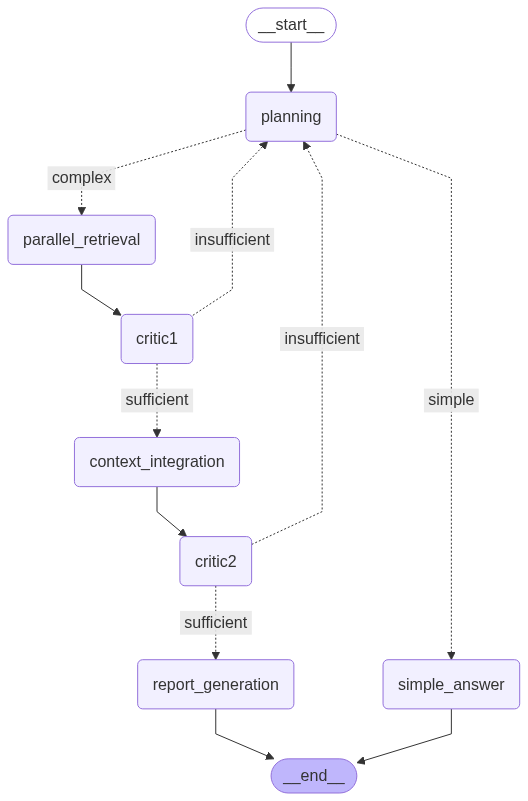

In [32]:
workflow_instance = RAGWorkflow()
app = workflow_instance._create_workflow()

from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

## RAG System Workflow Diagram (Graphviz)

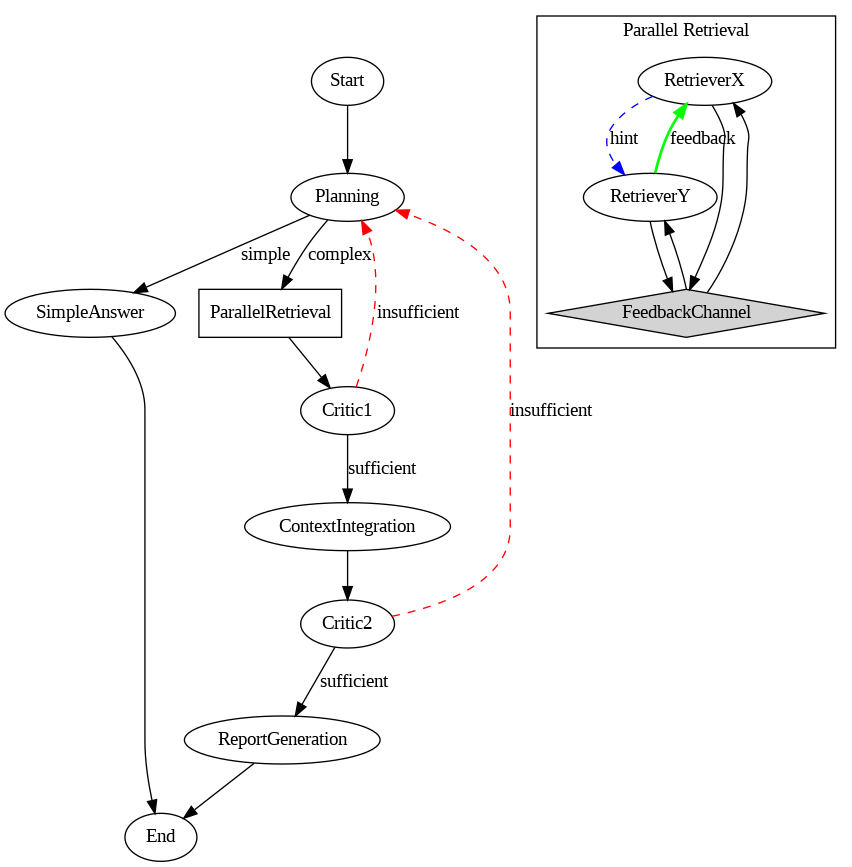

In [33]:
from graphviz import Digraph
from IPython.display import Image, display

dot = Digraph('RAG_Workflow', filename='rag_workflow', format='png')

# Main Node
dot.node('Start', shape='ellipse')
dot.node('Planning')
dot.node('SimpleAnswer')
dot.node('ParallelRetrieval', shape='box')
dot.node('Critic1')
dot.node('ContextIntegration')
dot.node('Critic2')
dot.node('ReportGeneration')
dot.node('End', shape='ellipse')

# Main Edge
dot.edge('Start', 'Planning')
dot.edge('Planning', 'SimpleAnswer', label='simple')
dot.edge('Planning', 'ParallelRetrieval', label='complex')
dot.edge('SimpleAnswer', 'End')
dot.edge('ParallelRetrieval', 'Critic1')

dot.edge('Critic1', 'Planning', label='insufficient', color='red', style='dashed')
dot.edge('Critic1', 'ContextIntegration', label='sufficient')
dot.edge('ContextIntegration', 'Critic2')
dot.edge('Critic2', 'Planning', label='insufficient', color='red', style='dashed')
dot.edge('Critic2', 'ReportGeneration', label='sufficient')
dot.edge('ReportGeneration', 'End')

# Parallel Retrieval ÎÇ¥Î∂Ä ÏÑúÎ∏åÍ∑∏ÎûòÌîÑ
with dot.subgraph(name='cluster_parallel') as c:
    c.attr(label='Parallel Retrieval')

    c.node('RetrieverX')
    c.node('RetrieverY')
    c.node('FeedbackChannel', shape='diamond', style='filled', fillcolor='lightgray')

    # Í≤ÄÏÉâ ÌùêÎ¶Ñ
    c.edge('RetrieverX', 'RetrieverY', label='hint', color='blue', style='dashed')
    c.edge('RetrieverY', 'RetrieverX', label='feedback', color='green', penwidth='2')

    # Feedback Channel
    c.edge('RetrieverX', 'FeedbackChannel')
    c.edge('FeedbackChannel', 'RetrieverY')
    c.edge('RetrieverY', 'FeedbackChannel')
    c.edge('FeedbackChannel', 'RetrieverX')

# Ï∂úÎ†• ÎûúÎçîÎßÅ
dot.render('rag_workflow', format='png')

display(Image(filename='rag_workflow.png'))

# Ï∂îÍ∞Ä Î≥¥ÏôÑ ÌïÑÏöî ÏÇ¨Ìï≠
1. critic -> planning Íµ¨Ï°∞Î°ú Î≥ÄÍ≤Ω Í≥†Î†§
 * ÌòÑÏû¨ critic -> retriever Íµ¨Ï°∞(ÏÜçÎèÑ Ï∏°Î©¥ÏóêÏÑú Îπ†Î¶Ñ, ÌïòÏßÄÎßå ÏùºÍ¥ÄÎêú Î∞©Ìñ•ÏÑ±ÏùÑ ÏßÄÎãàÍ≤å Îê®)
 * Ïã§Ï†úÎ°ú Îëê Íµ¨Ï°∞Ïùò ÏÑ±Îä• ÎπÑÍµê ÌõÑ ÌÅ∞ Ï∞®Ïù¥Í∞Ä ÏûàÎã§Î©¥ Íµ¨Ï°∞ Î≥ÄÍ≤Ω ÌïÑÏöî
2.	ÌîÑÎ°¨ÌîÑÌä∏ ÏóîÏßÄÎãàÏñ¥ÎßÅ Í∞ïÌôî
 * AgentÎ≥Ñ Ïó≠Ìï† ÏµúÏ†ÅÌôî
 * Ïª®ÌÖçÏä§Ìä∏ ÌÜµÌï©, ÌîºÎìúÎ∞±, ÌèâÍ∞Ä ÌîÑÎ°¨ÌîÑÌä∏ Í∞úÏÑ†
 * ÏùºÍ¥ÄÎêú Ïä§ÌÉÄÏùº Î∞è Ï∂úÎ†• Ìè¨Îß∑ Ïú†ÏßÄ
3.	Ïã§Ï†ú Îç∞Ïù¥ÌÑ∞Î≤†Ïù¥Ïä§ Ïó∞Í≤∞
 * Vector DB (ElasticSearch)
 * Graph DB (Neo4j)
 * RDB (Postgres)
4.	Retriever Feedback Íµ¨Ï°∞ ÏïàÏ†ïÌôî Î∞è ÏÑ±Îä• Í≤ÄÏ¶ù
 * ÌîºÎìúÎ∞± Î£®ÌîÑÏùò ÌÉÄÎãπÏÑ± Í≤ÄÏ¶ù
 * Ï†ïÎ≥¥ Î≥¥ÏôÑ Ìö®Í≥º Ïã§Ìóò (ÌîºÎìúÎ∞± Ï†Ñ/ÌõÑ Í≤ÄÏÉâ ÌíàÏßà ÎπÑÍµê)
 * ÌòÑÏû¨ max_feedback = 2, Ïã§ÌóòÏ†Å Í≤ÄÏ¶ùÏùÑ ÌÜµÌï¥ ÏàòÏ†ï ÌïÑÏöî
 * Ïò§Îäò Î≥¥Îãà Íµ¨Ï°∞ Ïù¥Ìï¥Î•º ÏûòÎ™ªÌï¥ÏÑú ÏàòÏ†ïÏù¥ ÌïÑÏöîÌï† ÎìØ Ìï®
5. Planning Agent ÏàòÏ†ï Î∞è Î≥¥ÏôÑ
 * ÌòÑÏû¨ Î≥µÏû° ÏøºÎ¶¨Î°ú ÌåêÎã®Îê† Í≤ΩÏö∞ Î™®Îì† databaseÎ•º Ï†ÑÎ∂Ä ÏÇ¨Ïö©ÌïòÎäî Í≤ÉÏúºÎ°ú Íµ¨ÌòÑÌï®
 * Í∞Å DBÏùò Íµ¨Ï≤¥Ï†ÅÏù∏ ÌäπÏßï ÎèÑÏ∂ú ÌõÑ, Ìï¥Îãπ ÌäπÏßïÏóê Îî∞Îùº ÌïÑÏöîÌïú DBÎßå ÏÇ¨Ïö©ÌïòÎäî Í≤ÉÏúºÎ°ú ÏàòÏ†ïÌï† ÌïÑÏöî ÏûàÏùå
6. Ïô∏Î∂Ä API Ïó∞Í≤∞ Î∞è Ïã§ÏãúÍ∞Ñ ÏõπÏÑúÏπ≠ Íµ¨ÌòÑ
7. Îû≠ÌÇπ Íµ¨ÌòÑ ÌïÑÏöî
8. Memory & History Í¥ÄÎ¶¨
